In [2]:
import cv2
import math                 
import numpy as np           
import scipy.io as sio       
import matplotlib as plt     
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.io import netcdf as nc      
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.metrics import MeanIoU
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, MaxPool2D, Concatenate
from tensorflow.keras.metrics import MeanIoU
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import custom_object_scope
from sklearn.model_selection import KFold
from tensorflow.keras.models import load_model
from sklearn.utils import shuffle
import datetime
from tensorflow.keras.models import save_model

Models

In [26]:
# U-Net +VGG19
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x
def build_vgg19_unet(input_shape):
    inputs = Input(input_shape)
    vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=inputs)
    s1 = vgg19.get_layer("block1_conv2").output 
    s2 = vgg19.get_layer("block2_conv2").output 
    s3 = vgg19.get_layer("block3_conv4").output 
    s4 = vgg19.get_layer("block4_conv4").output

    b1 = vgg19.get_layer("block5_conv4").output

    d1 = decoder_block(b1, s4, 512)    
    d2 = decoder_block(d1, s3, 256)    
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64) 
    outputs = Conv2D(1, (1, 1) , padding="same", activation="sigmoid")(d4)
    model = Model(inputs, outputs, name="VGG19_U-Net")
    return model


In [3]:
    input_shape = (512, 512, 3)
    model = build_vgg19_unet(input_shape)

In [3]:
# U-Net+ Inception
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import BatchNormalization
from keras.layers.core import Activation

def block(prevlayer, a, b, pooling):
    conva = Conv2D(a, (3, 3), activation='relu', padding='same')(prevlayer)
    conva = BatchNormalization()(conva)
    conva = Conv2D(b, (3, 3), activation='relu', padding='same')(conva)
    conva = BatchNormalization()(conva)
    if True == pooling:
        conva = MaxPooling2D(pool_size=(2, 2))(conva)
    convb = Conv2D(a, (5, 5), activation='relu', padding='same')(prevlayer)
    convb = BatchNormalization()(convb)
    convb = Conv2D(b, (5, 5), activation='relu', padding='same')(convb)
    convb = BatchNormalization()(convb)
    if True == pooling:
        convb = MaxPooling2D(pool_size=(2, 2))(convb)

    convc = Conv2D(b, (1, 1), activation='relu', padding='same')(prevlayer)
    convc = BatchNormalization()(convc)
    if True == pooling:
        convc = MaxPooling2D(pool_size=(2, 2))(convc)
        
    convd = Conv2D(a, (3, 3), activation='relu', padding='same')(prevlayer)
    convd = BatchNormalization()(convd)
    convd = Conv2D(b, (1, 1), activation='relu', padding='same')(convd)
    convd = BatchNormalization()(convd)
    if True == pooling:
        convd = MaxPooling2D(pool_size=(2, 2))(convd)
        
    up = concatenate([conva, convb, convc, convd])
    return up
    
def conv_block_simple(prevlayer, filters, prefix, strides=(1, 1)):
    conv = Conv2D(filters, (3, 3), padding="same", kernel_initializer="he_normal", strides=strides, name=prefix + "_conv")(prevlayer)
    conv = BatchNormalization(name=prefix + "_bn")(conv)
    conv = Activation('relu', name=prefix + "_activation")(conv)
    return conv
def unet_plus_inception(input_shape):
    inputs = Input(input_shape)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    xx1 = block(inputs, 16, 16, False)
    xx2 = block(xx1, 32, 32, True)
    xx3 = block(xx2, 64, 64, True)
    xx4 = block(xx3, 128, 128, True)
    
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4, xx4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3, xx3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2, xx2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1, xx1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)


    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    model = Model(inputs=[inputs], outputs=[conv10])    

    return model

In [6]:
# Customized U-Net
import tensorflow.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.regularizers import l2


def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True, regularization=None, kernel_initializer="he_normal"):
    if regularization == None:
        kernel_regularizer = None
    else:
        kernel_regularizer = l2(regularization)

    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer=kernel_initializer,
               padding="same", kernel_regularizer=kernel_regularizer)(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer=kernel_initializer,
               padding="same", kernel_regularizer=kernel_regularizer)(x)

    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    return x

def Unet(IMAGE_DIMS, n_filters=16, dropout=0.25, batchnorm=True, regularization=None, kernel_initializer="he_normal"):
   
    input_img = Input(IMAGE_DIMS, name='img')

    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm, regularization=regularization,
                      kernel_initializer=kernel_initializer)
    p1 = MaxPooling2D((2, 2)) (c1)
    if dropout !=  None:
        p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    if dropout !=  None:
        p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    if dropout !=  None:
        p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    if dropout !=  None:
        p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)

    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    if dropout !=  None:
        u6 = Dropout(dropout)(u6)
    
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    if dropout !=  None:
        u7 = Dropout(dropout)(u7)
    
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    if dropout !=  None:
        u8 = Dropout(dropout)(u8)
    
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    if dropout !=  None:
        u9 = Dropout(dropout)(u9)
    
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
 
    return model

In [4]:
# Attention U-Net
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, multiply, add, Activation
from tensorflow.keras.models import Model

def attention_block(x, g, inter_channel):

    theta_x = Conv2D(inter_channel, [1, 1], strides=[1, 1])(x)
    phi_g = Conv2D(inter_channel, [1, 1], strides=[1, 1])(g)
    f = Activation('relu')(add([theta_x, phi_g]))
    psi_f = Conv2D(1, [1, 1], strides=[1, 1])(f)
    rate = Activation('sigmoid')(psi_f)
    att_x = multiply([x, rate])
    return att_x

def attention_unet(input_size=(512,512,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    att6 = attention_block(conv4, up6, 256)
    merge6 = concatenate([att6, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    att7 = attention_block(conv3, up7, 128)
    merge7 = concatenate([att7, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    att8 = attention_block(conv2, up8, 64)
    merge8 = concatenate([att8, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    att9 = attention_block(conv1, up9, 32)
    merge9 = concatenate([att9, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    return model
model = attention_unet()

Functions

In [3]:
def read_files(input_dir,target_dir):

    input_img_paths = sorted(
        [
            os.path.join(input_dir, fname)
            for fname in os.listdir(input_dir)
            if fname.endswith(".png")
        ]
    )
    target_img_paths = sorted(
        [
            os.path.join(target_dir, fname)
            for fname in os.listdir(target_dir)
            if fname.endswith(".png") and not fname.startswith(".")
        ]
    )

    print("Number of samples:", len(input_img_paths))
    print("Number of samples:", len(target_img_paths))
    for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
        print(input_path, "|", target_path)
    return input_img_paths, target_img_paths

In [4]:
import os
import numpy as np
from PIL import Image
from skimage.transform import resize

def resize_images(input_dir, newsize, save_path):
    
    input_img_paths = sorted(
        [
            os.path.join(input_dir, fname)
            for fname in os.listdir(input_dir)
            if fname.endswith(".png")
        ]
    )
    for i in range(len(input_img_paths)):
        img = Image.open(input_img_paths[i])
        img_array = np.array(img)
        img_resized = resize(img_array, newsize, mode='constant', preserve_range=True)
        file_name, file_extension = os.path.splitext(os.path.basename(input_img_paths[i]))
        save_file_path = os.path.join(save_path, file_name + ".png")
        img_res = Image.fromarray(np.uint8(img_resized))
        img_res.save(save_file_path)

In [5]:
from tensorflow.keras import backend as K

def Recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def Precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def F1_score_Loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(K.cast(y_true, 'float32'))
    y_pred_f = K.flatten(K.cast(y_pred, 'float32'))
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)   
    return 1. - score

def F1_score(y_true, y_pred):
    precision = Precision(y_true, y_pred)
    recall = Recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [21]:

def Precision(y_true, y_pred):
    threshold = 0.5
    y_pred = K.cast(K.greater(y_pred, threshold), 'float32')
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def Recall(y_true, y_pred):
    threshold = 0.5
    y_pred = K.cast(K.greater(y_pred, threshold), 'float32')
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def F1_score_Loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)   
    return 1. - score

def F1_score(y_true, y_pred):
    precision = Precision(y_true, y_pred)
    recall = Recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

binary_iou = tf.keras.metrics.BinaryIoU(name='binary_iou', threshold=0.5)


In [6]:

smooth =1
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

binary_iou =tf.keras.metrics.BinaryIoU(name='binary_iou', threshold=0.5)

In [7]:
import os
import numpy as np

def read_files_arr(input_dir, target_dir):
    input_array_paths = sorted(
        [
            os.path.join(input_dir, fname)
            for fname in os.listdir(input_dir)
            if fname.endswith(".npy")
        ]
    )
    target_array_paths = sorted(
        [
            os.path.join(target_dir, fname)
            for fname in os.listdir(target_dir)
            if fname.endswith(".npy") and not fname.startswith(".")
        ]
    )

    print("Number of samples:", len(input_array_paths))
    print("Number of samples:", len(target_array_paths))
    
    input_arrays = []
    target_arrays = []
    
    for input_path, target_path in zip(input_array_paths, target_array_paths):
        input_array = np.load(input_path)
        target_array = np.load(target_path)
        
        input_arrays.append(input_array)
        target_arrays.append(target_array)
    
    return input_arrays, target_arrays




In [ ]:
import cv2
import numpy as np
from skimage.transform import resize

def create_image_mask_new(input_img_paths, target_img_paths, mask_IMAGE_DIMS, image_IMAGE_DIMS):
    images = []
    masks = []
   
    for (ii, (im_path, mask_path)) in enumerate(zip(input_img_paths,target_img_paths)):
        image = cv2.imread(im_path)
        image = resize(image, image_IMAGE_DIMS, mode='constant', preserve_range=True)
        image = image / 255
        images.append(image)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = resize(mask, mask_IMAGE_DIMS, mode='constant', preserve_range=True)

        # Apply the code snippet to convert the grayscale mask to binary (0 and 1)
        mask = np.where(mask>= 128, 1, 0)
        mask = mask.astype(np.float32)
        
        masks.append(mask)

    images = np.array(images)
    masks = np.array(masks)
    return images, masks

1. Run experiments with Clahe threshold.

Data is split 80/20 for the training/testing sets. A 5- fold cross-validation (5CV) strategy and early stopping are used on the training subset to ensure model generalizability and avoid overfitting. 

In [ ]:
# Data augmentation
images, masks = load_data()
print(f"Original Images: {len(images)} - Original Masks: {len(masks)}")
create_dir("/home/in18657@ad.umbc.edu/Laye_Detection/raw_clahe_aaai_aug")
create_dir("/home/in18657@ad.umbc.edu/Laye_Detection/gt_clahe_aaai_aug")
save_path="/home/in18657@ad.umbc.edu/Laye_Detection/"
augment_data(images, masks, save_path, augment=True)

In [20]:

import os
import cv2
from tqdm import tqdm
from glob import glob
from albumentations import CenterCrop, RandomRotate90, GridDistortion, HorizontalFlip, VerticalFlip
def augment_data(images, masks, save_path, augment=True):
    H = 512
    W = 512
    for x, y in tqdm(zip(images, masks), total=len(images)):
        name = x.split("/")[-1].split(".")
        image_name = name[0]
        image_extn = name[1]

        name = y.split("/")[-1].split(".")
        mask_name = name[0]
        mask_extn = name[1]
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)

        if augment == True:
            aug = GridDistortion(p=1.0)
            augmented = aug(image=x, mask=y)
            x3 = augmented['image']
            y3 = augmented['mask']
            aug = HorizontalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x4 = augmented['image']
            y4 = augmented['mask']
            save_images = [x,x3,x4]
            save_masks =  [y, y3,  y4]
        else:
            save_images = [x]
            save_masks = [y]
        idx = 0
        for i, m in zip(save_images, save_masks):
            i = cv2.resize(i, (W, H))
            m = cv2.resize(m, (W, H))

            if len(images) == 1:
                tmp_img_name = f"{image_name}.{image_extn}"
                tmp_mask_name = f"{mask_name}.{mask_extn}"
            else:
                tmp_img_name = f"{image_name}_{idx}.{image_extn}"
                tmp_mask_name = f"{mask_name}_{idx}.{mask_extn}"

            image_path = os.path.join(save_path, "raw_clahe_aaai_aug", tmp_img_name)
            mask_path = os.path.join(save_path, "gt_clahe_aaai_aug", tmp_mask_name)
            cv2.imwrite(image_path, i)
            print(save_path)
            print(image_path)
            cv2.imwrite(mask_path, m)

            idx += 1
def load_data():
    input_dir = "/home/in18657@ad.umbc.edu/Laye_Detection/raw"   
    target_dir = "/home/in18657@ad.umbc.edu/Laye_Detection/gt_clahe_thresh_binary"
    images = sorted(
        [
            os.path.join(input_dir, fname)
            for fname in os.listdir(input_dir)
            if fname.endswith(".png")
        ]
    )
    masks = sorted(
        [
            os.path.join(target_dir, fname)
            for fname in os.listdir(target_dir)
            if fname.endswith(".png") and not fname.startswith(".")
        ]
    )
    return images, masks
    
def create_dir(path):
    if not os.path.exists(path):
        print("not")
        os.makedirs(path)   

In [26]:
import cv2
import numpy as np
from skimage.transform import resize

def create_image_mask_new(input_img_paths, target_img_paths, mask_IMAGE_DIMS, image_IMAGE_DIMS):
    images = []
    masks = []
   
    for (ii, (im_path, mask_path)) in enumerate(zip(input_img_paths,target_img_paths)):
        image = cv2.imread(im_path)
        image = resize(image, image_IMAGE_DIMS, mode='constant', preserve_range=True)
        image = image / 255
        images.append(image)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = resize(mask, mask_IMAGE_DIMS, mode='constant', preserve_range=True)

        # Apply the code snippet to convert the grayscale mask to binary (0 and 1)
        mask = np.where(mask>= 128, 1, 0)
        mask = mask.astype(np.float32)
        
        masks.append(mask)

    images = np.array(images)
    masks = np.array(masks)
    return images, masks

In [27]:
input_dir = "/home/in18657@ad.umbc.edu/Laye_Detection/raw_clahe_aaai_aug"   
target_dir = "/home/in18657@ad.umbc.edu/Laye_Detection/gt_clahe_aaai_aug"
image_IMAGE_DIMS=(512,512,3) 
mask_IMAGE_DIMS=(512,512,1) 
input_img_paths,target_img_paths=read_files(input_dir,target_dir)
images,masks=create_image_mask_new(input_img_paths,target_img_paths,mask_IMAGE_DIMS,image_IMAGE_DIMS)
from sklearn.model_selection import train_test_split
image, X_test, mask, y_test= train_test_split(images, masks, test_size=0.2, random_state=0)

Number of samples: 900
Number of samples: 900
/home/in18657@ad.umbc.edu/Laye_Detection/raw_clahe_aaai_aug/Data_20110329_01_010_0.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt_clahe_aaai_aug/Data_20110329_01_010_0.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw_clahe_aaai_aug/Data_20110329_01_010_1.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt_clahe_aaai_aug/Data_20110329_01_010_1.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw_clahe_aaai_aug/Data_20110329_01_010_2.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt_clahe_aaai_aug/Data_20110329_01_010_2.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw_clahe_aaai_aug/Data_20110329_01_011_0.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt_clahe_aaai_aug/Data_20110329_01_011_0.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw_clahe_aaai_aug/Data_20110329_01_011_1.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt_clahe_aaai_aug/Data_20110329_01_011_1.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw_clahe_aaai_aug/Data_20110329_01_01

In [26]:
# Attention U-Net
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))
num_folds = 5
history_list = []
kf = KFold(n_splits=num_folds, shuffle=False, random_state=None)
indices = np.arange(len(image))
indices = shuffle(indices, random_state=0)
images_shuffled = image
masks_shuffled = mask
# Train and evaluate the model with k-fold cross-validation
train_loss_scores = []
train_binary_iou_scores = []
train_dice_coef_scores = []
train_f1_scores = []

val_loss_scores = []
val_binary_iou_scores = []
val_dice_coef_scores = []
val_f1_scores = []

test_f1_scores = []
test_loss_scores = []
test_binary_iou_scores = []
test_dice_coef_scores = []
test_f1_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(images_shuffled)):
    print(f'Fold {fold}')
    # Split the data into train and validation sets for this fold
    train_images, val_images = images_shuffled[train_index], images_shuffled[val_index]
    train_masks, val_masks = masks_shuffled[train_index], masks_shuffled[val_index]
    
    IMAGE_DIMS = (512,512,3)
    with strategy.scope():
        input_shape=(512,512,3)
        model = Attention_UNet(input_shape)
        binary_iou =tf.keras.metrics.BinaryIoU(name='binary_iou', threshold=0.5)
        # Compile the model
        model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=F1_score_Loss,
        metrics=[binary_iou,dice_coef,F1_score])
    
    
    # Define the EarlyStopping and ModelCheckpoint callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=40, verbose=1,  restore_best_weights=True)

    checkpoint = ModelCheckpoint(f'best_model_layer_300_attention_clahe_aaai_aug_fold_{fold}.h5', monitor='val_F1_score',mode='max', save_best_only=True, verbose=1)


    history = model.fit(train_images, train_masks, epochs=300, batch_size=8,
                        validation_data=(val_images, val_masks),
                        callbacks=[early_stop, checkpoint],verbose=0)

    save_model(model, f'complete_best_model_layer_300_attention_clahe_aaai_aug_fold_{fold}.h5')
    history_list.append(history.history)
    model.load_weights(f'best_model_layer_300_attention_clahe_aaai_aug_fold_{fold}.h5')
    # Evaluate the performance of the best model on the train, validation, and test sets
    train_scores = model.evaluate(train_images, train_masks, batch_size=8)
    val_scores = model.evaluate(val_images, val_masks, batch_size=8)
    test_scores=model.evaluate(X_test,y_test, batch_size=8)

    # Print the performance of the best model on this fold's train, validation, and test sets
    train_loss_scores.append(train_scores[0])
    train_binary_iou_scores.append(train_scores[1])
    train_dice_coef_scores.append(train_scores[2])
    train_f1_scores.append(train_scores[3])

    val_loss_scores.append(val_scores[0])
    val_binary_iou_scores.append(val_scores[1])
    val_dice_coef_scores.append(val_scores[2])
    val_f1_scores.append(val_scores[3])

    test_loss_scores.append(test_scores[0])
    test_binary_iou_scores.append(test_scores[1])
    test_dice_coef_scores.append(test_scores[2])
    test_f1_scores.append(test_scores[3])
    


    print('Fold', fold+1)
    print('Train loss:', train_scores[0])
    print('Train binary IOU:', train_scores[1])
    print('Train dice coef:', train_scores[2])
    print('Train F1:', train_scores[3])
    print('------------------------')
    print('Val loss:', val_scores[0])
    print('Val binary IOU:', val_scores[1])
    print('Val dice coef:', val_scores[2])
    print('Val F1:', val_scores[3])
    print('------------------------')
    print('test loss:', test_scores[0])
    print('test binary IOU:', test_scores[1])
    print('test_dice coef:', test_scores[2])
    print('test F1:', test_scores[3])
    print('------------------------')

# Calculate the average scores over all folds
avg_train_loss = np.mean(train_loss_scores)
avg_train_binary_iou = np.mean(train_binary_iou_scores)
avg_train_dice_coef = np.mean(train_dice_coef_scores)
avg_train_f1 = np.mean(train_f1_scores)
print('------------------------')
avg_val_loss = np.mean(val_loss_scores)
avg_val_binary_iou = np.mean(val_binary_iou_scores)
avg_val_dice_coef = np.mean(val_dice_coef_scores)
avg_val_f1 = np.mean(val_f1_scores)
print('------------------------')
avg_test_loss = np.mean(test_loss_scores)
avg_test_binary_iou = np.mean(test_binary_iou_scores)
avg_test_dice_coef = np.mean(test_dice_coef_scores)
avg_test_f1 = np.mean(test_f1_scores)

# Print the final average scores
print('Average train loss:', avg_train_loss)
print('Average train binary IoU:', avg_train_binary_iou)
print('Average train Dice coefficient:', avg_train_dice_coef)

print('Average train F1 score:', avg_train_f1)
print('------------------------')
print('Average validation loss:', avg_val_loss)
print('Average validation binary IoU:', avg_val_binary_iou)
print('Average validation Dice coefficient:', avg_val_dice_coef)

print('Average validation F1 score:', avg_val_f1)
print('------------------------')
print('Average test loss:', avg_test_loss)
print('Average test binary IoU:', avg_test_binary_iou)
print('Average test Dice coefficient:', avg_test_dice_coef)
print('Average test F1 score:', avg_test_f1)
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))

Current Time = 01:49:32
Fold 0

Epoch 1: val_F1_score improved from -inf to 0.11549, saving model to best_model_layer_300_attention_clahe_aaai_aug_fold_0.h5

Epoch 2: val_F1_score improved from 0.11549 to 0.20805, saving model to best_model_layer_300_attention_clahe_aaai_aug_fold_0.h5

Epoch 3: val_F1_score did not improve from 0.20805

Epoch 4: val_F1_score did not improve from 0.20805

Epoch 5: val_F1_score did not improve from 0.20805

Epoch 6: val_F1_score improved from 0.20805 to 0.22901, saving model to best_model_layer_300_attention_clahe_aaai_aug_fold_0.h5

Epoch 7: val_F1_score did not improve from 0.22901

Epoch 8: val_F1_score improved from 0.22901 to 0.26534, saving model to best_model_layer_300_attention_clahe_aaai_aug_fold_0.h5

Epoch 9: val_F1_score improved from 0.26534 to 0.29902, saving model to best_model_layer_300_attention_clahe_aaai_aug_fold_0.h5

Epoch 10: val_F1_score improved from 0.29902 to 0.30692, saving model to best_model_layer_300_attention_clahe_aaai_aug

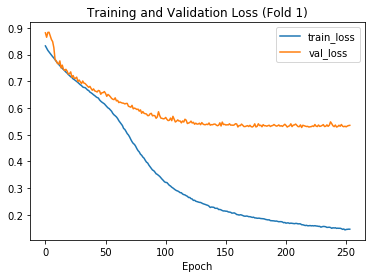

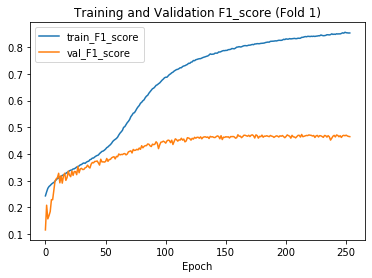

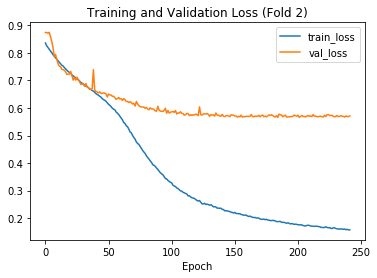

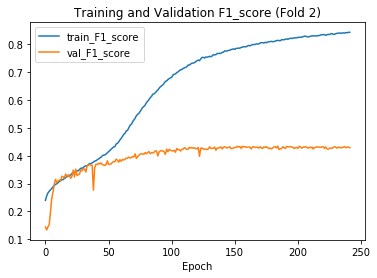

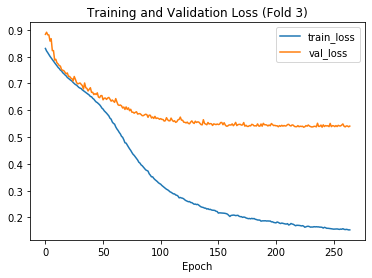

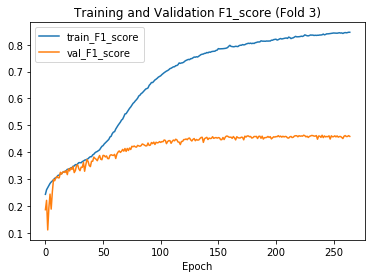

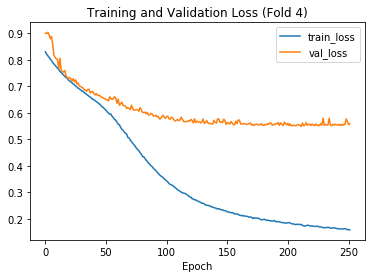

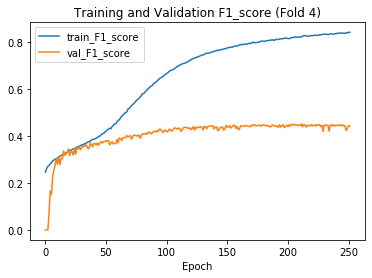

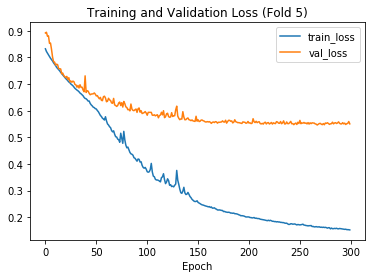

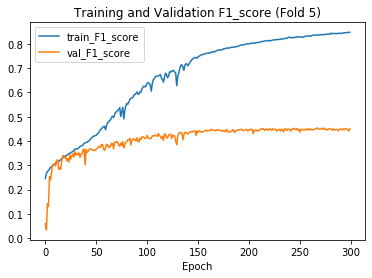

In [27]:
for fold in range(num_folds):
    train_loss = history_list[fold]['loss']
    val_loss = history_list[fold]['val_loss']
    train_F1_score = history_list[fold]['F1_score']
    val_F1_score = history_list[fold]['val_F1_score']

    plt.figure()
    plt.plot(train_loss, label='train_loss')
    plt.plot(val_loss, label='val_loss')
    plt.title('Training and Validation Loss (Fold {})'.format(fold+1))
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(train_F1_score, label='train_F1_score')
    plt.plot(val_F1_score, label='val_F1_score')
    plt.title('Training and Validation F1_score (Fold {})'.format(fold+1))
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [28]:
# Make prediction and save images
folder_path_train = '/home/in18657@ad.umbc.edu/Laye_Detection/Prediction/train_clahe_aaai_aug_attention'
folder_path_test = '/home/in18657@ad.umbc.edu/Laye_Detection/Prediction/test_clahe_aaai_aug_attention'
import numpy as np
import cv2
import os
model = Attention_UNet(input_shape)
model.load_weights('best_model_layer_300_attention_clahe_aaai_aug_fold_0.h5')

def save_test_prediction(predictions):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(predictions)):
        pred = (predictions[i] * 255).astype(np.uint8)
        file_name = "Predicted_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), pred)

predictions = model.predict(X_test, batch_size=1)
save_test_prediction(predictions)


def save_original_mask_test(y_test):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(y_test)):
        y_test_i = (y_test[i, :, :, 0] * 255).astype(np.uint8)
        file_name = "Mask_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), y_test_i)

save_original_mask_test(y_test)


def save_original_X_test(X_test):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(X_test)):
        X_test_i = (X_test[i] * 255).astype(np.uint8)
        file_name = "Image_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), X_test_i)

save_original_X_test(X_test)
def save_train_prediction(predictions):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(predictions)):
        pred = (predictions[i] * 255).astype(np.uint8)
        file_name = "Predicted_train_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), pred)

predictions_train = model.predict(image, batch_size=1)
save_train_prediction(predictions_train)


def save_original_mask_train(y_train):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(y_train)):
        mask_i = (y_train[i, :, :, 0] * 255).astype(np.uint8)
        file_name = "Train_mask_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), mask_i)

save_original_mask_train(mask)


def save_original_X_train(X_train):
    os.makedirs(folder_path_train, exist_ok=True) 
    for i in range(len(X_train)):
        image_i = (X_train[i] * 255).astype(np.uint8)
        file_name = "Train_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), image_i)

save_original_X_train(image)

720/720 [==============================] - 21s 29ms/step


In [42]:
# U-Net
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))

num_folds = 5
history_list = []

kf = KFold(n_splits=num_folds, shuffle=False, random_state=None)


indices = np.arange(len(image))
indices = shuffle(indices, random_state=0)
images_shuffled = image
masks_shuffled = mask


# Train and evaluate the model with k-fold cross-validation
train_loss_scores = []
train_binary_iou_scores = []
train_dice_coef_scores = []
train_f1_scores = []

val_loss_scores = []
val_binary_iou_scores = []
val_dice_coef_scores = []
val_f1_scores = []

test_f1_scores = []
test_loss_scores = []
test_binary_iou_scores = []
test_dice_coef_scores = []
test_f1_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(images_shuffled)):
    print(f'Fold {fold}')
    # Split the data into train and validation sets for this fold
    train_images, val_images = images_shuffled[train_index], images_shuffled[val_index]
    train_masks, val_masks = masks_shuffled[train_index], masks_shuffled[val_index]
    
    IMAGE_DIMS = (512,512,3)
    with strategy.scope():
        model = Unet(IMAGE_DIMS, n_filters=16,  dropout=0.5, batchnorm=True, regularization=None, kernel_initializer="he_normal")

        binary_iou =tf.keras.metrics.BinaryIoU(name='binary_iou', threshold=0.5)
        # Compile the model
        model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=F1_score_Loss,
        metrics=[binary_iou,dice_coef,F1_score])
    
    
    # Define the EarlyStopping and ModelCheckpoint callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=40, verbose=1,  restore_best_weights=True)

    checkpoint = ModelCheckpoint(f'best_model_layer_300_UNet_clahe_aaai_aug_fold_{fold}.h5', monitor='val_F1_score',mode='max', save_best_only=True, verbose=1)


    history = model.fit(train_images, train_masks, epochs=300, batch_size=8,
                        validation_data=(val_images, val_masks),
                        callbacks=[early_stop, checkpoint],verbose=0)


    save_model(model, f'complete_best_model_layer_300_UNet_clahe_aaai_aug_fold_{fold}.h5')
    history_list.append(history.history)
   
    model.load_weights(f'best_model_layer_300_UNet_clahe_aaai_aug_fold_{fold}.h5')
    # Evaluate the performance of the best model on the train, validation, and test sets
    train_scores = model.evaluate(train_images, train_masks, batch_size=8)
    val_scores = model.evaluate(val_images, val_masks, batch_size=8)
    test_scores=model.evaluate(X_test,y_test, batch_size=8)

    # Print the performance of the best model on this fold's train, validation, and test sets
    train_loss_scores.append(train_scores[0])
    train_binary_iou_scores.append(train_scores[1])
    train_dice_coef_scores.append(train_scores[2])
    train_f1_scores.append(train_scores[3])

    val_loss_scores.append(val_scores[0])
    val_binary_iou_scores.append(val_scores[1])
    val_dice_coef_scores.append(val_scores[2])
    val_f1_scores.append(val_scores[3])

    test_loss_scores.append(test_scores[0])
    test_binary_iou_scores.append(test_scores[1])
    test_dice_coef_scores.append(test_scores[2])
    test_f1_scores.append(test_scores[3])
    


    print('Fold', fold+1)
    print('Train loss:', train_scores[0])
    print('Train binary IOU:', train_scores[1])
    print('Train dice coef:', train_scores[2])
    print('Train F1:', train_scores[3])
    print('------------------------')
    print('Val loss:', val_scores[0])
    print('Val binary IOU:', val_scores[1])
    print('Val dice coef:', val_scores[2])
    print('Val F1:', val_scores[3])
    print('------------------------')
    print('test loss:', test_scores[0])
    print('test binary IOU:', test_scores[1])
    print('test_dice coef:', test_scores[2])
    print('test F1:', test_scores[3])
    print('------------------------')

# Calculate the average scores over all folds
avg_train_loss = np.mean(train_loss_scores)
avg_train_binary_iou = np.mean(train_binary_iou_scores)
avg_train_dice_coef = np.mean(train_dice_coef_scores)
avg_train_f1 = np.mean(train_f1_scores)
print('------------------------')
avg_val_loss = np.mean(val_loss_scores)
avg_val_binary_iou = np.mean(val_binary_iou_scores)
avg_val_dice_coef = np.mean(val_dice_coef_scores)
avg_val_f1 = np.mean(val_f1_scores)
print('------------------------')
avg_test_loss = np.mean(test_loss_scores)
avg_test_binary_iou = np.mean(test_binary_iou_scores)
avg_test_dice_coef = np.mean(test_dice_coef_scores)
avg_test_f1 = np.mean(test_f1_scores)

# Print the final average scores
print('Average train loss:', avg_train_loss)
print('Average train binary IoU:', avg_train_binary_iou)
print('Average train Dice coefficient:', avg_train_dice_coef)

print('Average train F1 score:', avg_train_f1)
print('------------------------')
print('Average validation loss:', avg_val_loss)
print('Average validation binary IoU:', avg_val_binary_iou)
print('Average validation Dice coefficient:', avg_val_dice_coef)

print('Average validation F1 score:', avg_val_f1)
print('------------------------')
print('Average test loss:', avg_test_loss)
print('Average test binary IoU:', avg_test_binary_iou)
print('Average test Dice coefficient:', avg_test_dice_coef)
print('Average test F1 score:', avg_test_f1)
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))

Current Time = 21:14:01
Fold 0


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

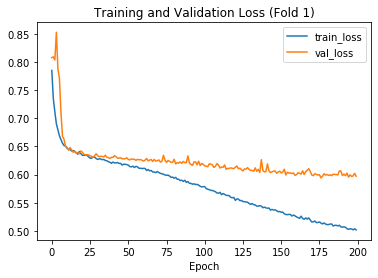

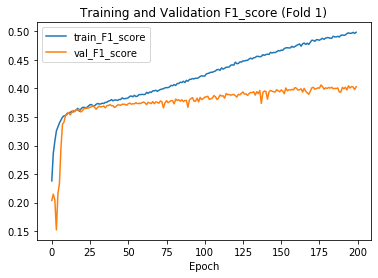

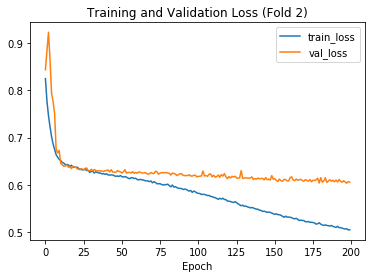

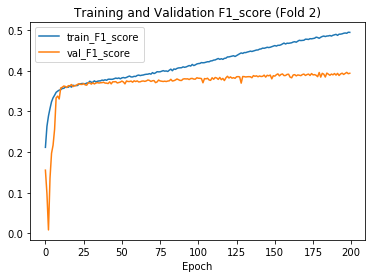

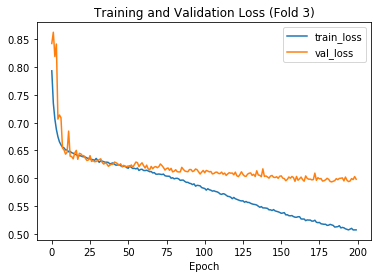

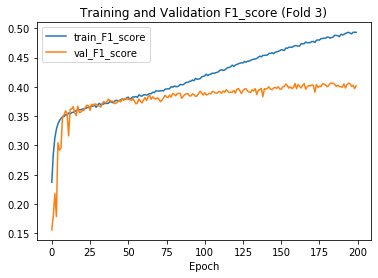

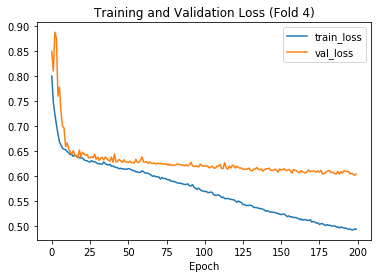

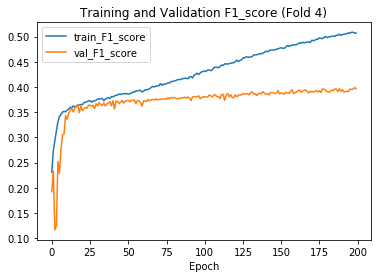

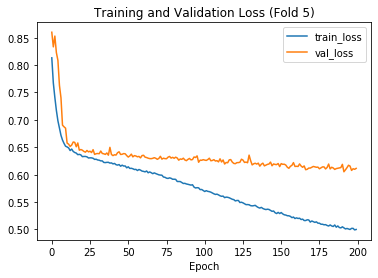

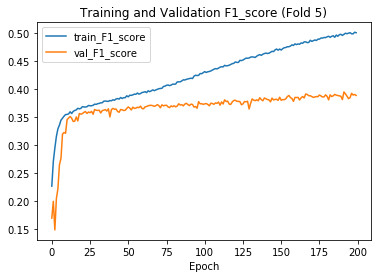

In [43]:
for fold in range(num_folds):
    train_loss = history_list[fold]['loss']
    val_loss = history_list[fold]['val_loss']
    train_F1_score = history_list[fold]['F1_score']
    val_F1_score = history_list[fold]['val_F1_score']
    plt.figure()
    plt.plot(train_loss, label='train_loss')
    plt.plot(val_loss, label='val_loss')
    plt.title('Training and Validation Loss (Fold {})'.format(fold+1))
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(train_F1_score, label='train_F1_score')
    plt.plot(val_F1_score, label='val_F1_score')
    plt.title('Training and Validation F1_score (Fold {})'.format(fold+1))
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [44]:
# Make predictions and save images
folder_path_train = '/home/in18657@ad.umbc.edu/Laye_Detection/Prediction/train_clahe_aaai_aug_UNet'
folder_path_test = '/home/in18657@ad.umbc.edu/Laye_Detection/Prediction/test_clahe_aaai_aug_UNet'
import numpy as np
import cv2
import os
model = Unet(IMAGE_DIMS, n_filters=16, dropout=0.5, batchnorm=True, regularization=None, kernel_initializer="he_normal")
model.load_weights('best_model_layer_300_UNet_clahe_aaai_aug_fold_1.h5')


def save_test_prediction(predictions):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(predictions)):
        pred = (predictions[i] * 255).astype(np.uint8)
        #save_path = folder_path_test + "/"
        file_name = "Predicted_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), pred)

predictions = model.predict(X_test, batch_size=1)
save_test_prediction(predictions)


def save_original_mask_test(y_test):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(y_test)):
        y_test_i = (y_test[i, :, :, 0] * 255).astype(np.uint8)
        file_name = "Mask_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), y_test_i)

save_original_mask_test(y_test)


def save_original_X_test(X_test):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(X_test)):
        X_test_i = (X_test[i] * 255).astype(np.uint8)
        file_name = "Image_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), X_test_i)

save_original_X_test(X_test)
def save_train_prediction(predictions):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(predictions)):
        pred = (predictions[i] * 255).astype(np.uint8)
        file_name = "Predicted_train_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), pred)

predictions_train = model.predict(image, batch_size=1)
save_train_prediction(predictions_train)


def save_original_mask_train(y_train):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(y_train)):
        mask_i = (y_train[i, :, :, 0] * 255).astype(np.uint8)
        file_name = "Train_mask_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), mask_i)

save_original_mask_train(mask)


def save_original_X_train(X_train):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(X_train)):
        image_i = (X_train[i] * 255).astype(np.uint8)
        file_name = "Train_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), image_i)

save_original_X_train(image)

720/720 [==============================] - 6s 9ms/step


In [13]:
# VGG19 + U-Net
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))

num_folds = 5
history_list = []

kf = KFold(n_splits=num_folds, shuffle=False, random_state=None)


indices = np.arange(len(image))
indices = shuffle(indices, random_state=0)
images_shuffled = image
masks_shuffled = mask


# Train and evaluate the model with k-fold cross-validation
train_loss_scores = []
train_binary_iou_scores = []
train_dice_coef_scores = []
train_f1_scores = []

val_loss_scores = []
val_binary_iou_scores = []
val_dice_coef_scores = []
val_f1_scores = []

test_f1_scores = []
test_loss_scores = []
test_binary_iou_scores = []
test_dice_coef_scores = []
test_f1_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(images_shuffled)):
    print(f'Fold {fold}')
    # Split the data into train and validation sets for this fold
    train_images, val_images = images_shuffled[train_index], images_shuffled[val_index]
    train_masks, val_masks = masks_shuffled[train_index], masks_shuffled[val_index]
    with strategy.scope():
        input_shape= (512,512,3)
        model = build_vgg19_unet(input_shape)

        binary_iou =tf.keras.metrics.BinaryIoU(name='binary_iou', threshold=0.5)
        # Compile the model
        model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=F1_score_Loss,
        metrics=[binary_iou,dice_coef,F1_score])
    
    
    # Define the EarlyStopping and ModelCheckpoint callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=40, verbose=1,  restore_best_weights=True)

    checkpoint = ModelCheckpoint(f'best_model_layer_300_vgg_clahe_aaai_aug_fold_{fold}.h5', monitor='val_F1_score',mode='max', save_best_only=True, verbose=1)


    history = model.fit(train_images, train_masks, epochs=300, batch_size=8,
                        validation_data=(val_images, val_masks),
                        callbacks=[early_stop, checkpoint],verbose=0)


    save_model(model, f'complete_best_model_layer_300_vgg_clahe_aaai_aug_fold_{fold}.h5')
    history_list.append(history.history)
   
    model.load_weights(f'best_model_layer_300_vgg_clahe_aaai_aug_fold_{fold}.h5')
    # Evaluate the performance of the best model on the train, validation, and test sets
    train_scores = model.evaluate(train_images, train_masks, batch_size=8)
    val_scores = model.evaluate(val_images, val_masks, batch_size=8)
    test_scores=model.evaluate(X_test,y_test, batch_size=8)

    # Print the performance of the best model on this fold's train, validation, and test sets
    train_loss_scores.append(train_scores[0])
    train_binary_iou_scores.append(train_scores[1])
    train_dice_coef_scores.append(train_scores[2])
    train_f1_scores.append(train_scores[3])

    val_loss_scores.append(val_scores[0])
    val_binary_iou_scores.append(val_scores[1])
    val_dice_coef_scores.append(val_scores[2])
    val_f1_scores.append(val_scores[3])

    test_loss_scores.append(test_scores[0])
    test_binary_iou_scores.append(test_scores[1])
    test_dice_coef_scores.append(test_scores[2])
    test_f1_scores.append(test_scores[3])
    


    print('Fold', fold+1)
    print('Train loss:', train_scores[0])
    print('Train binary IOU:', train_scores[1])
    print('Train dice coef:', train_scores[2])
    print('Train F1:', train_scores[3])
    print('------------------------')
    print('Val loss:', val_scores[0])
    print('Val binary IOU:', val_scores[1])
    print('Val dice coef:', val_scores[2])
    print('Val F1:', val_scores[3])
    print('------------------------')
    print('test loss:', test_scores[0])
    print('test binary IOU:', test_scores[1])
    print('test_dice coef:', test_scores[2])
    print('test F1:', test_scores[3])
    print('------------------------')

# Calculate the average scores over all folds
avg_train_loss = np.mean(train_loss_scores)
avg_train_binary_iou = np.mean(train_binary_iou_scores)
avg_train_dice_coef = np.mean(train_dice_coef_scores)
avg_train_f1 = np.mean(train_f1_scores)
print('------------------------')
avg_val_loss = np.mean(val_loss_scores)
avg_val_binary_iou = np.mean(val_binary_iou_scores)
avg_val_dice_coef = np.mean(val_dice_coef_scores)
avg_val_f1 = np.mean(val_f1_scores)
print('------------------------')
avg_test_loss = np.mean(test_loss_scores)
avg_test_binary_iou = np.mean(test_binary_iou_scores)
avg_test_dice_coef = np.mean(test_dice_coef_scores)
avg_test_f1 = np.mean(test_f1_scores)

# Print the final average scores
print('Average train loss:', avg_train_loss)
print('Average train binary IoU:', avg_train_binary_iou)
print('Average train Dice coefficient:', avg_train_dice_coef)

print('Average train F1 score:', avg_train_f1)
print('------------------------')
print('Average validation loss:', avg_val_loss)
print('Average validation binary IoU:', avg_val_binary_iou)
print('Average validation Dice coefficient:', avg_val_dice_coef)

print('Average validation F1 score:', avg_val_f1)
print('------------------------')
print('Average test loss:', avg_test_loss)
print('Average test binary IoU:', avg_test_binary_iou)
print('Average test Dice coefficient:', avg_test_dice_coef)
print('Average test F1 score:', avg_test_f1)
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))

Current Time = 00:50:39
Fold 0


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

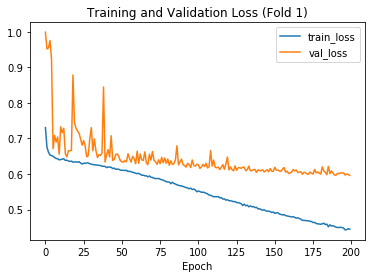

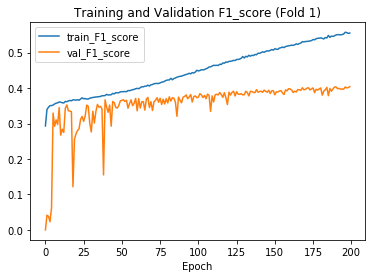

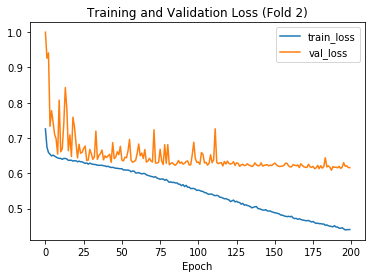

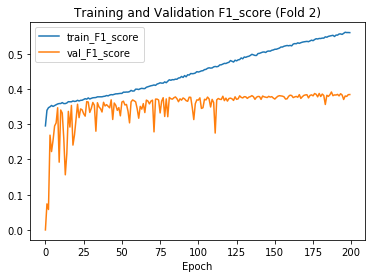

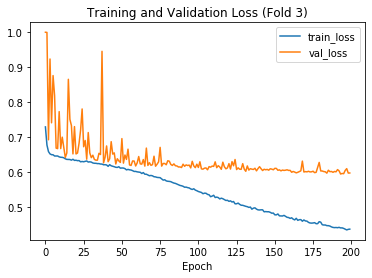

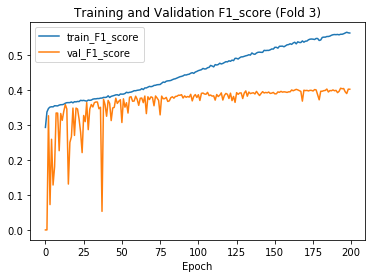

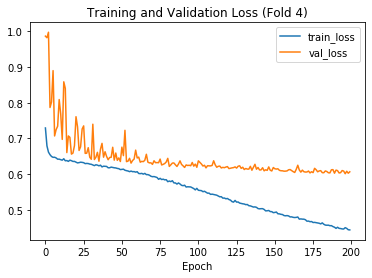

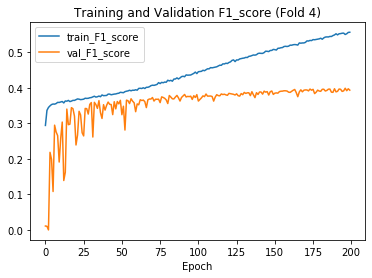

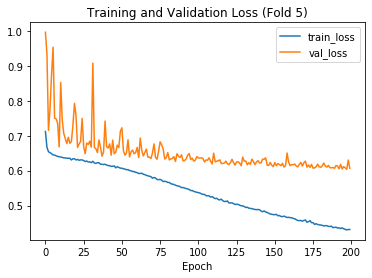

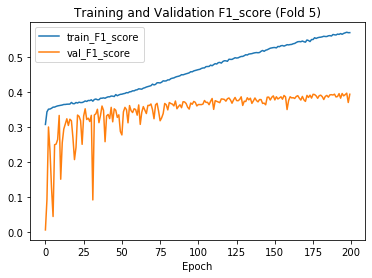

In [14]:
for fold in range(num_folds):
    train_loss = history_list[fold]['loss']
    val_loss = history_list[fold]['val_loss']
    train_F1_score = history_list[fold]['F1_score']
    val_F1_score = history_list[fold]['val_F1_score']
    plt.figure()
    plt.plot(train_loss, label='train_loss')
    plt.plot(val_loss, label='val_loss')
    plt.title('Training and Validation Loss (Fold {})'.format(fold+1))
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(train_F1_score, label='train_F1_score')
    plt.plot(val_F1_score, label='val_F1_score')
    plt.title('Training and Validation F1_score (Fold {})'.format(fold+1))
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [15]:
# Make predictions with the best fold before overfitting and save images.
folder_path_train = '/home/in18657@ad.umbc.edu/Laye_Detection/Prediction/train_clahe_aaai_aug_vgg19'
folder_path_test = '/home/in18657@ad.umbc.edu/Laye_Detection/Prediction/test_clahe_aaai_aug_vgg19'
import numpy as np
import cv2
import os
model = build_vgg19_unet(input_shape)
model.load_weights('best_model_layer_300_vgg_clahe_aaai_aug_fold_1.h5')
def save_test_prediction(predictions):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(predictions)):
        pred = (predictions[i] * 255).astype(np.uint8)
        file_name = "Predicted_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), pred)

predictions = model.predict(X_test, batch_size=1)
save_test_prediction(predictions)


def save_original_mask_test(y_test):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(y_test)):
        y_test_i = (y_test[i, :, :, 0] * 255).astype(np.uint8)
        file_name = "Mask_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), y_test_i)

save_original_mask_test(y_test)


def save_original_X_test(X_test):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(X_test)):
        X_test_i = (X_test[i] * 255).astype(np.uint8)
        file_name = "Image_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), X_test_i)

save_original_X_test(X_test)
def save_train_prediction(predictions):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(predictions)):
        pred = (predictions[i] * 255).astype(np.uint8)
        file_name = "Predicted_train_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), pred)

predictions_train = model.predict(image, batch_size=1)
save_train_prediction(predictions_train)


def save_original_mask_train(y_train):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(y_train)):
        mask_i = (y_train[i, :, :, 0] * 255).astype(np.uint8)
        file_name = "Train_mask_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), mask_i)

save_original_mask_train(mask)

def save_original_X_train(X_train):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(X_train)):
        image_i = (X_train[i] * 255).astype(np.uint8)
        file_name = "Train_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), image_i)

save_original_X_train(image)

720/720 [==============================] - 17s 23ms/step


In [16]:
# Inception U-Net
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))

num_folds = 5
history_list = []

kf = KFold(n_splits=num_folds, shuffle=False, random_state=None)
indices = np.arange(len(image))
indices = shuffle(indices, random_state=0)
images_shuffled = image
masks_shuffled = mask
# Train and evaluate the model with k-fold cross-validation
train_loss_scores = []
train_binary_iou_scores = []
train_dice_coef_scores = []
train_f1_scores = []

val_loss_scores = []
val_binary_iou_scores = []
val_dice_coef_scores = []
val_f1_scores = []

test_f1_scores = []
test_loss_scores = []
test_binary_iou_scores = []
test_dice_coef_scores = []
test_f1_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(images_shuffled)):
    print(f'Fold {fold}')
    # Split the data into train and validation sets for this fold
    train_images, val_images = images_shuffled[train_index], images_shuffled[val_index]
    train_masks, val_masks = masks_shuffled[train_index], masks_shuffled[val_index]
    
    IMAGE_DIMS = (512,512,3)
    with strategy.scope():
        model = unet_plus_inception(IMAGE_DIMS)
        binary_iou =tf.keras.metrics.BinaryIoU(name='binary_iou', threshold=0.5)
        # Compile the model
        model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=F1_score_Loss,
        metrics=[binary_iou,dice_coef,F1_score])
    
    
    # Define the EarlyStopping and ModelCheckpoint callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=40, verbose=1,  restore_best_weights=True)

    checkpoint = ModelCheckpoint(f'best_model_layer_300_inception_clahe_aaai_aug_fold_{fold}.h5', monitor='val_F1_score',mode='max', save_best_only=True, verbose=1)


    history = model.fit(train_images, train_masks, epochs=300, batch_size=8,
                        validation_data=(val_images, val_masks),
                        callbacks=[early_stop, checkpoint],verbose=0)


    save_model(model, f'complete_best_model_layer_300_inception_clahe_aaai_aug_fold_{fold}.h5')
    history_list.append(history.history)
   
    model.load_weights(f'best_model_layer_300_inception_clahe_aaai_aug_fold_{fold}.h5')
    # Evaluate the performance of the best model on the train, validation, and test sets
    train_scores = model.evaluate(train_images, train_masks, batch_size=8)
    val_scores = model.evaluate(val_images, val_masks, batch_size=8)
    test_scores=model.evaluate(X_test,y_test, batch_size=8)

    # Print the performance of the best model on this fold's train, validation, and test sets
    train_loss_scores.append(train_scores[0])
    train_binary_iou_scores.append(train_scores[1])
    train_dice_coef_scores.append(train_scores[2])
    train_f1_scores.append(train_scores[3])

    val_loss_scores.append(val_scores[0])
    val_binary_iou_scores.append(val_scores[1])
    val_dice_coef_scores.append(val_scores[2])
    val_f1_scores.append(val_scores[3])

    test_loss_scores.append(test_scores[0])
    test_binary_iou_scores.append(test_scores[1])
    test_dice_coef_scores.append(test_scores[2])
    test_f1_scores.append(test_scores[3])
    print('Fold', fold+1)
    print('Train loss:', train_scores[0])
    print('Train binary IOU:', train_scores[1])
    print('Train dice coef:', train_scores[2])
    print('Train F1:', train_scores[3])
    print('------------------------')
    print('Val loss:', val_scores[0])
    print('Val binary IOU:', val_scores[1])
    print('Val dice coef:', val_scores[2])
    print('Val F1:', val_scores[3])
    print('------------------------')
    print('test loss:', test_scores[0])
    print('test binary IOU:', test_scores[1])
    print('test_dice coef:', test_scores[2])
    print('test F1:', test_scores[3])
    print('------------------------')

# Calculate the average scores over all folds
avg_train_loss = np.mean(train_loss_scores)
avg_train_binary_iou = np.mean(train_binary_iou_scores)
avg_train_dice_coef = np.mean(train_dice_coef_scores)
avg_train_f1 = np.mean(train_f1_scores)
print('------------------------')
avg_val_loss = np.mean(val_loss_scores)
avg_val_binary_iou = np.mean(val_binary_iou_scores)
avg_val_dice_coef = np.mean(val_dice_coef_scores)
avg_val_f1 = np.mean(val_f1_scores)
print('------------------------')
avg_test_loss = np.mean(test_loss_scores)
avg_test_binary_iou = np.mean(test_binary_iou_scores)
avg_test_dice_coef = np.mean(test_dice_coef_scores)
avg_test_f1 = np.mean(test_f1_scores)

# Print the final average scores
print('Average train loss:', avg_train_loss)
print('Average train binary IoU:', avg_train_binary_iou)
print('Average train Dice coefficient:', avg_train_dice_coef)

print('Average train F1 score:', avg_train_f1)
print('------------------------')
print('Average validation loss:', avg_val_loss)
print('Average validation binary IoU:', avg_val_binary_iou)
print('Average validation Dice coefficient:', avg_val_dice_coef)

print('Average validation F1 score:', avg_val_f1)
print('------------------------')
print('Average test loss:', avg_test_loss)
print('Average test binary IoU:', avg_test_binary_iou)
print('Average test Dice coefficient:', avg_test_dice_coef)
print('Average test F1 score:', avg_test_f1)
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))

Current Time = 05:55:22
Fold 0

Epoch 1: val_F1_score improved from -inf to 0.07464, saving model to best_model_layer_300_inception_clahe_aaai_aug_fold_0.h5

Epoch 2: val_F1_score did not improve from 0.07464

Epoch 3: val_F1_score did not improve from 0.07464

Epoch 4: val_F1_score did not improve from 0.07464

Epoch 5: val_F1_score improved from 0.07464 to 0.16989, saving model to best_model_layer_300_inception_clahe_aaai_aug_fold_0.h5

Epoch 6: val_F1_score improved from 0.16989 to 0.23358, saving model to best_model_layer_300_inception_clahe_aaai_aug_fold_0.h5

Epoch 7: val_F1_score improved from 0.23358 to 0.25813, saving model to best_model_layer_300_inception_clahe_aaai_aug_fold_0.h5

Epoch 8: val_F1_score improved from 0.25813 to 0.30845, saving model to best_model_layer_300_inception_clahe_aaai_aug_fold_0.h5

Epoch 9: val_F1_score improved from 0.30845 to 0.31384, saving model to best_model_layer_300_inception_clahe_aaai_aug_fold_0.h5

Epoch 10: val_F1_score improved from 0.31

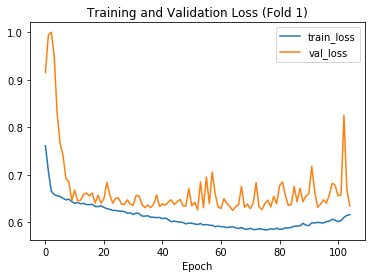

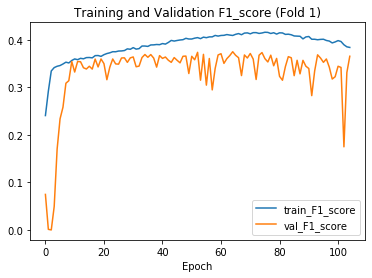

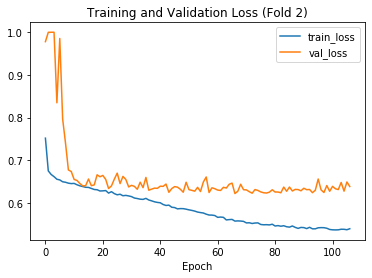

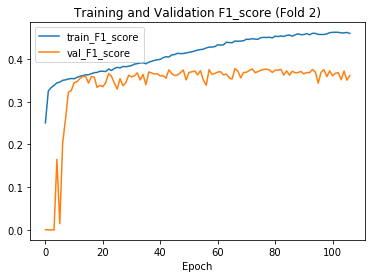

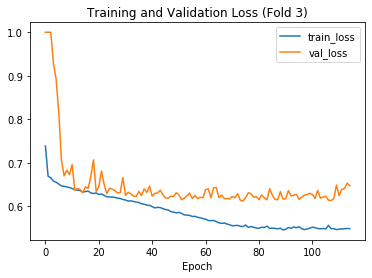

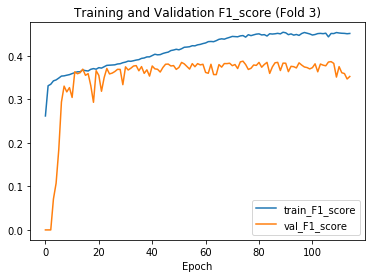

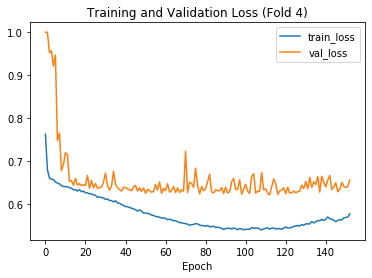

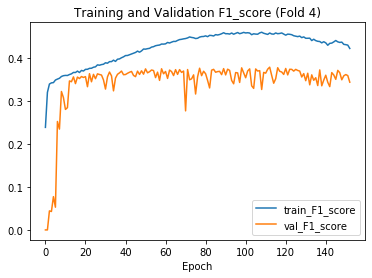

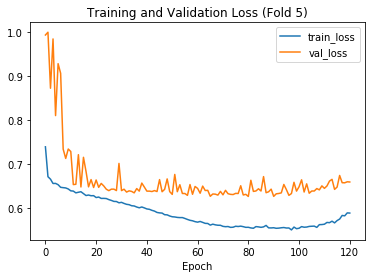

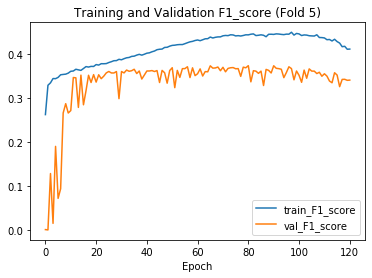

In [17]:
for fold in range(num_folds):
    train_loss = history_list[fold]['loss']
    val_loss = history_list[fold]['val_loss']
    train_F1_score = history_list[fold]['F1_score']
    val_F1_score = history_list[fold]['val_F1_score']
    plt.figure()
    plt.plot(train_loss, label='train_loss')
    plt.plot(val_loss, label='val_loss')
    plt.title('Training and Validation Loss (Fold {})'.format(fold+1))
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(train_F1_score, label='train_F1_score')
    plt.plot(val_F1_score, label='val_F1_score')
    plt.title('Training and Validation F1_score (Fold {})'.format(fold+1))
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()


In [18]:

# Make predictions with the best fold before overfitting and save images.

folder_path_train = '/home/in18657@ad.umbc.edu/Laye_Detection/Prediction/train_clahe_aaai_aug_inception'
folder_path_test = '/home/in18657@ad.umbc.edu/Laye_Detection/Prediction/test_clahe_aaai_aug_inception'
import numpy as np
import cv2
import os
model = unet_plus_inception(IMAGE_DIMS)
model.load_weights('best_model_layer_300_inception_clahe_aaai_aug_fold_1.h5')


def save_test_prediction(predictions):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(predictions)):
        pred = (predictions[i] * 255).astype(np.uint8)
        #save_path = folder_path_test + "/"
        file_name = "Predicted_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), pred)

predictions = model.predict(X_test, batch_size=1)
save_test_prediction(predictions)


def save_original_mask_test(y_test):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(y_test)):
        y_test_i = (y_test[i, :, :, 0] * 255).astype(np.uint8)
       # save_path = folder_path_test + "/"
        file_name = "Mask_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), y_test_i)

save_original_mask_test(y_test)


def save_original_X_test(X_test):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(X_test)):
        X_test_i = (X_test[i] * 255).astype(np.uint8)
       # save_path = folder_path_test + "/"
        file_name = "Image_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), X_test_i)

save_original_X_test(X_test)
def save_train_prediction(predictions):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(predictions)):
        pred = (predictions[i] * 255).astype(np.uint8)
       # save_path = folder_path_train + "/"
        file_name = "Predicted_train_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), pred)

predictions_train = model.predict(image, batch_size=1)
save_train_prediction(predictions_train)


def save_original_mask_train(y_train):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(y_train)):
        mask_i = (y_train[i, :, :, 0] * 255).astype(np.uint8)
      #  save_path = folder_path_train + "/"
        file_name = "Train_mask_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), mask_i)

save_original_mask_train(mask)


def save_original_X_train(X_train):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(X_train)):
        image_i = (X_train[i] * 255).astype(np.uint8)
       # save_path = folder_path_train + "/"
        file_name = "Train_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), image_i)

save_original_X_train(image)

720/720 [==============================] - 23s 32ms/step


In [ ]:
# train models with the original size

In [12]:
input_dir = "/home/in18657@ad.umbc.edu/Laye_Detection/raw"   
target_dir = "/home/in18657@ad.umbc.edu/Laye_Detection/gt_clahe_thresh_binary"
image_IMAGE_DIMS=(1024,1408,1) 
mask_IMAGE_DIMS=(1024,1408,1) 
input_img_paths,target_img_paths=read_files(input_dir,target_dir)
images,masks=create_image_mask_new(input_img_paths,target_img_paths,mask_IMAGE_DIMS,image_IMAGE_DIMS)
from sklearn.model_selection import train_test_split
image, X_test, mask, y_test= train_test_split(images, masks, test_size=0.2, random_state=0)

Number of samples: 300
Number of samples: 300
/home/in18657@ad.umbc.edu/Laye_Detection/raw/Data_20110329_01_010.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt_clahe_thresh_binary/Data_20110329_01_010.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw/Data_20110329_01_011.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt_clahe_thresh_binary/Data_20110329_01_011.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw/Data_20110329_01_012.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt_clahe_thresh_binary/Data_20110329_01_012.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw/Data_20110329_01_013.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt_clahe_thresh_binary/Data_20110329_01_013.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw/Data_20110329_01_018.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt_clahe_thresh_binary/Data_20110329_01_018.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw/Data_20110329_01_019.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt_clahe_thresh_binary/Data_20110329

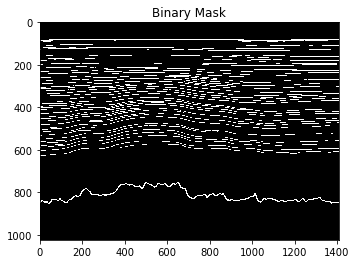

True

In [13]:
import matplotlib.pyplot as plt
binary_mask = mask[0]
binary_mask = np.squeeze(binary_mask, axis=-1) 

plt.imshow(binary_mask, cmap='gray')
plt.title('Binary Mask')
plt.show()
cv2.imwrite('mask-_clahe.png', binary_mask * 255)

In [14]:
import numpy as np
binary_mask = np.squeeze(masks[10], axis=-1)
min_value = np.min(binary_mask)
max_value = np.max(binary_mask)

print("Minimum value:", min_value)
print("Maximum value:", max_value)

Minimum value: 0
Maximum value: 1


In [15]:
# U-Net
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))
num_folds = 5
history_list = []

kf = KFold(n_splits=num_folds, shuffle=False, random_state=None)


indices = np.arange(len(image))
indices = shuffle(indices, random_state=0)
images_shuffled = image
masks_shuffled = mask


# Train and evaluate the model with k-fold cross-validation
train_loss_scores = []
train_binary_iou_scores = []
train_dice_coef_scores = []
train_f1_scores = []

val_loss_scores = []
val_binary_iou_scores = []
val_dice_coef_scores = []
val_f1_scores = []

test_f1_scores = []
test_loss_scores = []
test_binary_iou_scores = []
test_dice_coef_scores = []
test_f1_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(images_shuffled)):
    print(f'Fold {fold}')
    # Split the data into train and validation sets for this fold
    train_images, val_images = images_shuffled[train_index], images_shuffled[val_index]
    train_masks, val_masks = masks_shuffled[train_index], masks_shuffled[val_index]
    
    IMAGE_DIMS = (1024,1408,1)
    
   
    import tensorflow as tf
    gpus = tf.config.experimental.list_physical_devices("GPU")
    tf.config.experimental.set_visible_devices(gpus[:4], "GPU")
    
    strategy = tf.distribute.MirroredStrategy(devices=["GPU:0", "GPU:1","GPU:2", "GPU:3"])
    with strategy.scope():
    
        

        model = Unet(IMAGE_DIMS, n_filters=16,  dropout=0.5, batchnorm=True, regularization=None, kernel_initializer="he_normal")

        binary_iou =tf.keras.metrics.BinaryIoU(name='binary_iou', threshold=0.5)
        # Compile the model
        model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=F1_score_Loss,
        metrics=[binary_iou,dice_coef,F1_score])
    
    
    # Define the EarlyStopping and ModelCheckpoint callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=40, verbose=1,  restore_best_weights=True)

    checkpoint = ModelCheckpoint(f'best_model_layer_300_clahe_UNet_fold_{fold}.h5', monitor='val_F1_score',mode='max', save_best_only=True, verbose=1)


    history = model.fit(train_images, train_masks, epochs=300, batch_size=8,
                        validation_data=(val_images, val_masks),
                        callbacks=[early_stop, checkpoint],verbose=0)


    save_model(model, f'complete_model_layer_300_clahe_UNet_fold_{fold}.h5')
    history_list.append(history.history)
   
    model.load_weights(f'best_model_layer_300_clahe_UNet_fold_{fold}.h5')
    # Evaluate the performance of the best model on the train, validation, and test sets
    train_scores = model.evaluate(train_images, train_masks, batch_size=8)
    val_scores = model.evaluate(val_images, val_masks, batch_size=8)
    test_scores=model.evaluate(X_test,y_test, batch_size=8)

    # Print the performance of the best model on this fold's train, validation, and test sets
    train_loss_scores.append(train_scores[0])
    train_binary_iou_scores.append(train_scores[1])
    train_dice_coef_scores.append(train_scores[2])
    train_f1_scores.append(train_scores[3])

    val_loss_scores.append(val_scores[0])
    val_binary_iou_scores.append(val_scores[1])
    val_dice_coef_scores.append(val_scores[2])
    val_f1_scores.append(val_scores[3])

    test_loss_scores.append(test_scores[0])
    test_binary_iou_scores.append(test_scores[1])
    test_dice_coef_scores.append(test_scores[2])
    test_f1_scores.append(test_scores[3])
    


    print('Fold', fold+1)
    print('Train loss:', train_scores[0])
    print('Train binary IOU:', train_scores[1])
    print('Train dice coef:', train_scores[2])
    print('Train F1:', train_scores[3])
    print('------------------------')
    print('Val loss:', val_scores[0])
    print('Val binary IOU:', val_scores[1])
    print('Val dice coef:', val_scores[2])
    print('Val F1:', val_scores[3])
    print('------------------------')
    print('test loss:', test_scores[0])
    print('test binary IOU:', test_scores[1])
    print('test_dice coef:', test_scores[2])
    print('test F1:', test_scores[3])
    print('------------------------')

# Calculate the average scores over all folds
avg_train_loss = np.mean(train_loss_scores)
avg_train_binary_iou = np.mean(train_binary_iou_scores)
avg_train_dice_coef = np.mean(train_dice_coef_scores)
avg_train_f1 = np.mean(train_f1_scores)
print('------------------------')
avg_val_loss = np.mean(val_loss_scores)
avg_val_binary_iou = np.mean(val_binary_iou_scores)
avg_val_dice_coef = np.mean(val_dice_coef_scores)
avg_val_f1 = np.mean(val_f1_scores)
print('------------------------')
avg_test_loss = np.mean(test_loss_scores)
avg_test_binary_iou = np.mean(test_binary_iou_scores)
avg_test_dice_coef = np.mean(test_dice_coef_scores)
avg_test_f1 = np.mean(test_f1_scores)

# Print the final average scores
print('Average train loss:', avg_train_loss)
print('Average train binary IoU:', avg_train_binary_iou)
print('Average train Dice coefficient:', avg_train_dice_coef)
print('------------------------')
print('Average train F1 score:', avg_train_f1)
print('Average validation loss:', avg_val_loss)
print('Average validation binary IoU:', avg_val_binary_iou)
print('Average validation Dice coefficient:', avg_val_dice_coef)
print('------------------------')
print('Average validation F1 score:', avg_val_f1)
print('Average test loss:', avg_test_loss)
print('Average test binary IoU:', avg_test_binary_iou)
print('Average test Dice coefficient:', avg_test_dice_coef)
print('Average test F1 score:', avg_test_f1)
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))

Current Time = 22:33:57
Fold 0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce t

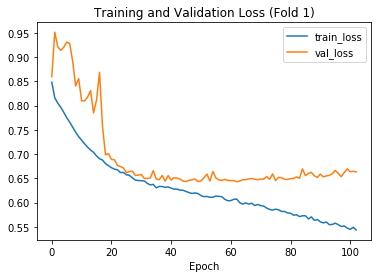

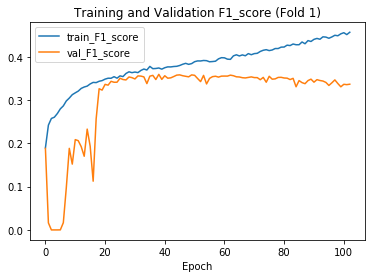

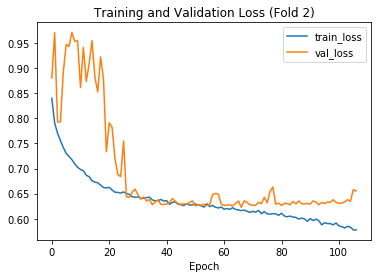

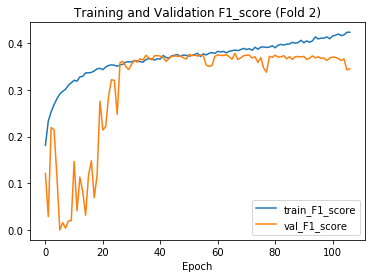

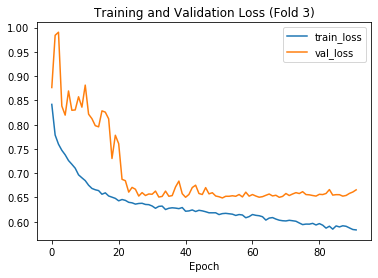

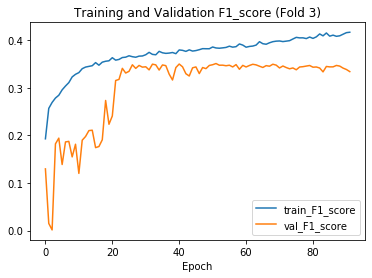

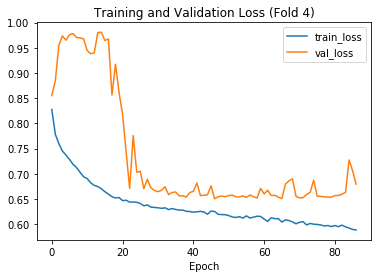

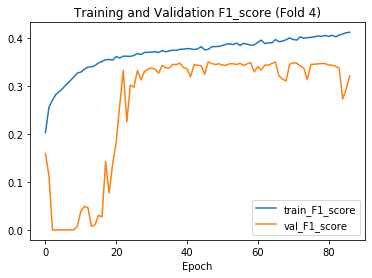

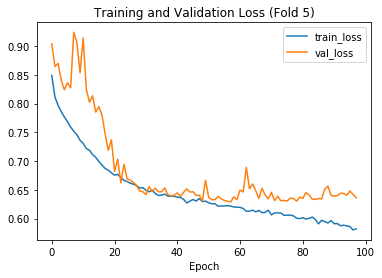

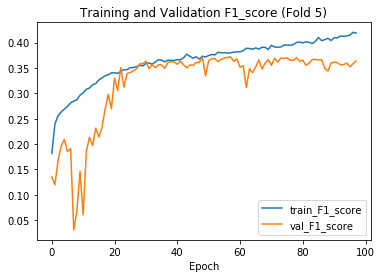

In [16]:
for fold in range(num_folds):
    train_loss = history_list[fold]['loss']
    val_loss = history_list[fold]['val_loss']
    train_F1_score = history_list[fold]['F1_score']
    val_F1_score = history_list[fold]['val_F1_score']
    plt.figure()
    plt.plot(train_loss, label='train_loss')
    plt.plot(val_loss, label='val_loss')
    plt.title('Training and Validation Loss (Fold {})'.format(fold+1))
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(train_F1_score, label='train_F1_score')
    plt.plot(val_F1_score, label='val_F1_score')
    plt.title('Training and Validation F1_score (Fold {})'.format(fold+1))
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()


In [18]:

# Make predictions with the best fold before overfitting and save images.
folder_path_train = '/home/in18657@ad.umbc.edu/Laye_Detection/Prediction/train_clahe_UNet'
folder_path_test = '/home/in18657@ad.umbc.edu/Laye_Detection/Prediction/test_clahe_UNet'
import numpy as np
import cv2
import os
model = Unet(IMAGE_DIMS, n_filters=16, dropout=0.5, batchnorm=True, regularization=None, kernel_initializer="he_normal")
model.load_weights('best_model_layer_300_clahe_UNet_fold_1.h5')


def save_test_prediction(predictions):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(predictions)):
        pred = (predictions[i] * 255).astype(np.uint8)
        file_name = "Predicted_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), pred)

predictions = model.predict(X_test, batch_size=1)
save_test_prediction(predictions)


def save_original_mask_test(y_test):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(y_test)):
        y_test_i = (y_test[i, :, :, 0] * 255).astype(np.uint8)
        file_name = "Mask_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), y_test_i)

save_original_mask_test(y_test)

def save_original_X_test(X_test):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(X_test)):
        X_test_i = (X_test[i] * 255).astype(np.uint8)
        file_name = "Image_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), X_test_i)

save_original_X_test(X_test)
def save_train_prediction(predictions):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(predictions)):
        pred = (predictions[i] * 255).astype(np.uint8)
        file_name = "Predicted_train_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), pred)

predictions_train = model.predict(image, batch_size=1)
save_train_prediction(predictions_train)

def save_original_mask_train(y_train):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(y_train)):
        mask_i = (y_train[i, :, :, 0] * 255).astype(np.uint8)
        file_name = "Train_mask_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), mask_i)

save_original_mask_train(mask)

def save_original_X_train(X_train):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(X_train)):
        image_i = (X_train[i] * 255).astype(np.uint8)
        file_name = "Train_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), image_i)

save_original_X_train(image)

240/240 [==============================] - 5s 20ms/step


In [19]:
# Train the models without augmentation
input_dir = "/home/in18657@ad.umbc.edu/Laye_Detection/raw"   
target_dir = "/home/in18657@ad.umbc.edu/Laye_Detection/gt_clahe_thresh_binary"
image_IMAGE_DIMS=(512,512,3) 
mask_IMAGE_DIMS=(512,512,1) 
input_img_paths,target_img_paths=read_files(input_dir,target_dir)
images,masks=create_image_mask_new(input_img_paths,target_img_paths,mask_IMAGE_DIMS,image_IMAGE_DIMS)
from sklearn.model_selection import train_test_split
image, X_test, mask, y_test= train_test_split(images, masks, test_size=0.2, random_state=0)

Number of samples: 300
Number of samples: 300
/home/in18657@ad.umbc.edu/Laye_Detection/raw/Data_20110329_01_010.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt_clahe_thresh_binary/Data_20110329_01_010.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw/Data_20110329_01_011.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt_clahe_thresh_binary/Data_20110329_01_011.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw/Data_20110329_01_012.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt_clahe_thresh_binary/Data_20110329_01_012.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw/Data_20110329_01_013.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt_clahe_thresh_binary/Data_20110329_01_013.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw/Data_20110329_01_018.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt_clahe_thresh_binary/Data_20110329_01_018.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw/Data_20110329_01_019.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt_clahe_thresh_binary/Data_20110329

In [20]:
# U-Net + Inception
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))
num_folds = 5
history_list = []

kf = KFold(n_splits=num_folds, shuffle=False, random_state=None)


indices = np.arange(len(image))
indices = shuffle(indices, random_state=0)
images_shuffled = image
masks_shuffled = mask
# Train and evaluate the model with k-fold cross-validation
train_loss_scores = []
train_binary_iou_scores = []
train_dice_coef_scores = []
train_f1_scores = []

val_loss_scores = []
val_binary_iou_scores = []
val_dice_coef_scores = []
val_f1_scores = []

test_f1_scores = []
test_loss_scores = []
test_binary_iou_scores = []
test_dice_coef_scores = []
test_f1_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(images_shuffled)):
    print(f'Fold {fold}')
    # Split the data into train and validation sets for this fold
    train_images, val_images = images_shuffled[train_index], images_shuffled[val_index]
    train_masks, val_masks = masks_shuffled[train_index], masks_shuffled[val_index]
    
    IMAGE_DIMS = (512,512,3)
    
    import tensorflow as tf
    gpus = tf.config.experimental.list_physical_devices("GPU")
    tf.config.experimental.set_visible_devices(gpus[:4], "GPU")
    
    strategy = tf.distribute.MirroredStrategy(devices=["GPU:0", "GPU:1","GPU:2", "GPU:3"])
    with strategy.scope():
    
        

        model = unet_plus_inception(IMAGE_DIMS)

        binary_iou =tf.keras.metrics.BinaryIoU(name='binary_iou', threshold=0.5)
        # Compile the model
        model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=F1_score_Loss,
        metrics=[binary_iou,dice_coef,F1_score])
    # Define the EarlyStopping and ModelCheckpoint callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=40, verbose=1,  restore_best_weights=True)

    checkpoint = ModelCheckpoint(f'best_model_layer_300_clahe_inception_fold_{fold}.h5', monitor='val_F1_score',mode='max', save_best_only=True, verbose=1)


    history = model.fit(train_images, train_masks, epochs=300, batch_size=8,
                        validation_data=(val_images, val_masks),
                        callbacks=[early_stop, checkpoint],verbose=0)

    save_model(model, f'complete_model_layer_300_clahe_inception_fold_{fold}.h5')
    history_list.append(history.history)
   
    model.load_weights(f'best_model_layer_300_clahe_inception_fold_{fold}.h5')
    # Evaluate the performance of the best model on the train, validation, and test sets
    train_scores = model.evaluate(train_images, train_masks, batch_size=8)
    val_scores = model.evaluate(val_images, val_masks, batch_size=8)
    test_scores=model.evaluate(X_test,y_test, batch_size=8)
    # Print the performance of the best model on this fold's train, validation, and test sets
    train_loss_scores.append(train_scores[0])
    train_binary_iou_scores.append(train_scores[1])
    train_dice_coef_scores.append(train_scores[2])
    train_f1_scores.append(train_scores[3])

    val_loss_scores.append(val_scores[0])
    val_binary_iou_scores.append(val_scores[1])
    val_dice_coef_scores.append(val_scores[2])
    val_f1_scores.append(val_scores[3])

    test_loss_scores.append(test_scores[0])
    test_binary_iou_scores.append(test_scores[1])
    test_dice_coef_scores.append(test_scores[2])
    test_f1_scores.append(test_scores[3])

    print('Fold', fold+1)
    print('Train loss:', train_scores[0])
    print('Train binary IOU:', train_scores[1])
    print('Train dice coef:', train_scores[2])
    print('Train F1:', train_scores[3])
    print('------------------------')
    print('Val loss:', val_scores[0])
    print('Val binary IOU:', val_scores[1])
    print('Val dice coef:', val_scores[2])
    print('Val F1:', val_scores[3])
    print('------------------------')
    print('test loss:', test_scores[0])
    print('test binary IOU:', test_scores[1])
    print('test_dice coef:', test_scores[2])
    print('test F1:', test_scores[3])
    print('------------------------')

# Calculate the average scores over all folds
avg_train_loss = np.mean(train_loss_scores)
avg_train_binary_iou = np.mean(train_binary_iou_scores)
avg_train_dice_coef = np.mean(train_dice_coef_scores)
avg_train_f1 = np.mean(train_f1_scores)
print('------------------------')
avg_val_loss = np.mean(val_loss_scores)
avg_val_binary_iou = np.mean(val_binary_iou_scores)
avg_val_dice_coef = np.mean(val_dice_coef_scores)
avg_val_f1 = np.mean(val_f1_scores)
print('------------------------')
avg_test_loss = np.mean(test_loss_scores)
avg_test_binary_iou = np.mean(test_binary_iou_scores)
avg_test_dice_coef = np.mean(test_dice_coef_scores)
avg_test_f1 = np.mean(test_f1_scores)

# Print the final average scores
print('Average train loss:', avg_train_loss)
print('Average train binary IoU:', avg_train_binary_iou)
print('Average train Dice coefficient:', avg_train_dice_coef)
print('------------------------')
print('Average train F1 score:', avg_train_f1)
print('Average validation loss:', avg_val_loss)
print('Average validation binary IoU:', avg_val_binary_iou)
print('Average validation Dice coefficient:', avg_val_dice_coef)
print('------------------------')
print('Average validation F1 score:', avg_val_f1)
print('Average test loss:', avg_test_loss)
print('Average test binary IoU:', avg_test_binary_iou)
print('Average test Dice coefficient:', avg_test_dice_coef)
print('Average test F1 score:', avg_test_f1)
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))

Current Time = 00:21:55
Fold 0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')

Epoch 1: val_F1_score improved from -inf to 0.14892, saving model to best_model_layer_300_clahe_inception_fold_0.h5

Epoch 2: val_F1_score did not improve from 0.14892

Epoch 3: val_F1_score did not improve from 0.14892

Epoch 4: val_F1_score did not improve from 0.14892

Epoch 5: val_F1_score did not improve from 0.14892

Epoch 6: val_F1_score did not improve from 0.14892

Epoch 7: val_F1_score did not improve from 0.14892

Epoch 8: val_F1_score did not improve from 0.14892

Epoch 9: val_F1_score did not improve from 0.14892

Epoch 10: val_F1_score did not improve from 0.14892

Epoch 11: val_F1_score did not improve from 0.14892

Epoch 12: val_F1_score did not improve from 0.14892

Epoch 13: val_F1_score did not 

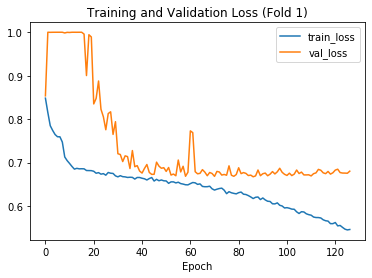

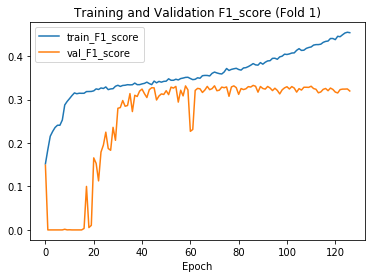

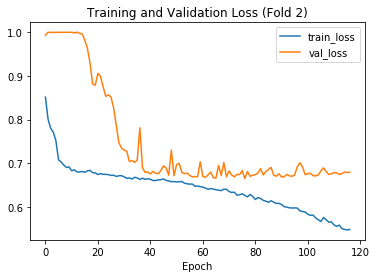

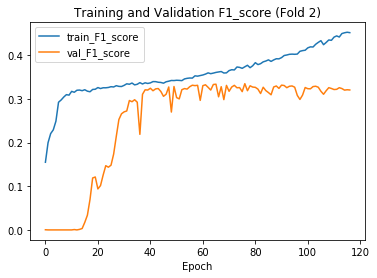

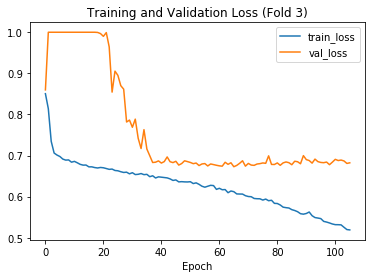

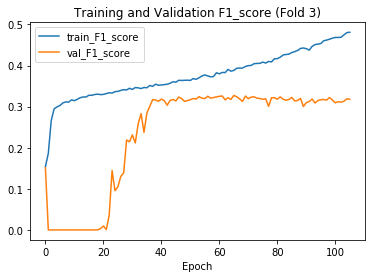

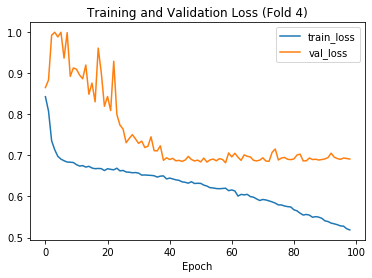

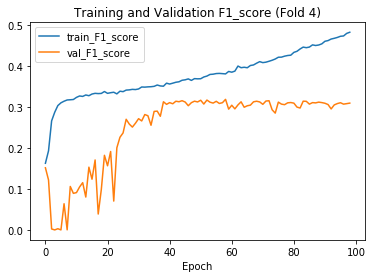

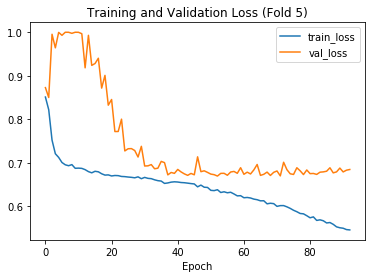

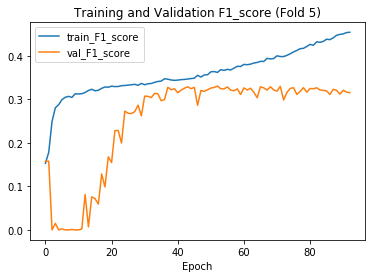

In [21]:
for fold in range(num_folds):
    train_loss = history_list[fold]['loss']
    val_loss = history_list[fold]['val_loss']
    train_F1_score = history_list[fold]['F1_score']
    val_F1_score = history_list[fold]['val_F1_score']

    plt.figure()
    plt.plot(train_loss, label='train_loss')
    plt.plot(val_loss, label='val_loss')
    plt.title('Training and Validation Loss (Fold {})'.format(fold+1))
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(train_F1_score, label='train_F1_score')
    plt.plot(val_F1_score, label='val_F1_score')
    plt.title('Training and Validation F1_score (Fold {})'.format(fold+1))
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()


In [23]:

# Make predictions with the best fold before overfitting and save images.
folder_path_train = '/home/in18657@ad.umbc.edu/Laye_Detection/Prediction/train_clahe_inception'
folder_path_test = '/home/in18657@ad.umbc.edu/Laye_Detection/Prediction/test_clahe_inception'
import numpy as np
import cv2
import os
model = unet_plus_inception(IMAGE_DIMS)

model.load_weights('best_model_layer_300_clahe_inception_fold_1.h5')
def save_test_prediction(predictions):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(predictions)):
        pred = (predictions[i] * 255).astype(np.uint8)

        file_name = "Predicted_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), pred)

predictions = model.predict(X_test, batch_size=1)
save_test_prediction(predictions)
def save_original_mask_test(y_test):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(y_test)):
        y_test_i = (y_test[i, :, :, 0] * 255).astype(np.uint8)
        file_name = "Mask_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), y_test_i)

save_original_mask_test(y_test)


def save_original_X_test(X_test):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(X_test)):
        X_test_i = (X_test[i] * 255).astype(np.uint8)
        file_name = "Image_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), X_test_i)

save_original_X_test(X_test)
def save_train_prediction(predictions):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(predictions)):
        pred = (predictions[i] * 255).astype(np.uint8)
        file_name = "Predicted_train_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), pred)

predictions_train = model.predict(image, batch_size=1)
save_train_prediction(predictions_train)


def save_original_mask_train(y_train):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(y_train)):
        mask_i = (y_train[i, :, :, 0] * 255).astype(np.uint8)"
        file_name = "Train_mask_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), mask_i)

save_original_mask_train(mask)


def save_original_X_train(X_train):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(X_train)):
        image_i = (X_train[i] * 255).astype(np.uint8)
        file_name = "Train_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), image_i)

save_original_X_train(image)

240/240 [==============================] - 8s 32ms/step


In [24]:
# VGG19 + U-Net
input_shape = (512, 512, 3)
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))
num_folds = 5
history_list = []

kf = KFold(n_splits=num_folds, shuffle=False, random_state=None)


indices = np.arange(len(image))
indices = shuffle(indices, random_state=0)
images_shuffled = image
masks_shuffled = mask


# Train and evaluate the model with k-fold cross-validation
train_loss_scores = []
train_binary_iou_scores = []
train_dice_coef_scores = []
train_f1_scores = []

val_loss_scores = []
val_binary_iou_scores = []
val_dice_coef_scores = []
val_f1_scores = []

test_f1_scores = []
test_loss_scores = []
test_binary_iou_scores = []
test_dice_coef_scores = []
test_f1_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(images_shuffled)):
    print(f'Fold {fold}')
    # Split the data into train and validation sets for this fold
    train_images, val_images = images_shuffled[train_index], images_shuffled[val_index]
    train_masks, val_masks = masks_shuffled[train_index], masks_shuffled[val_index]
    import tensorflow as tf
    gpus = tf.config.experimental.list_physical_devices("GPU")
    tf.config.experimental.set_visible_devices(gpus[:4], "GPU")
    
    strategy = tf.distribute.MirroredStrategy(devices=["GPU:0", "GPU:1","GPU:2", "GPU:3"])
    with strategy.scope():
    
        model = build_vgg19_unet(input_shape)

        binary_iou =tf.keras.metrics.BinaryIoU(name='binary_iou', threshold=0.5)
        # Compile the model
        model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=F1_score_Loss,
        metrics=[binary_iou,dice_coef,F1_score])
    
    
    # Define the EarlyStopping and ModelCheckpoint callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=40, verbose=1,  restore_best_weights=True)

    checkpoint = ModelCheckpoint(f'best_model_layer_300_clahe_vgg_fold_{fold}.h5', monitor='val_F1_score',mode='max', save_best_only=True, verbose=1)
    history = model.fit(train_images, train_masks, epochs=300, batch_size=8,
                        validation_data=(val_images, val_masks),
                        callbacks=[early_stop, checkpoint],verbose=0)


    save_model(model, f'complete_model_layer_300_clahe_vgg_fold_{fold}.h5')
    history_list.append(history.history)
   
    model.load_weights(f'best_model_layer_300_clahe_vgg_fold_{fold}.h5')
    # Evaluate the performance of the best model on the train, validation, and test sets
    train_scores = model.evaluate(train_images, train_masks, batch_size=8)
    val_scores = model.evaluate(val_images, val_masks, batch_size=8)
    test_scores=model.evaluate(X_test,y_test, batch_size=8)
    # Print the performance of the best model on this fold's train, validation, and test sets
    train_loss_scores.append(train_scores[0])
    train_binary_iou_scores.append(train_scores[1])
    train_dice_coef_scores.append(train_scores[2])
    train_f1_scores.append(train_scores[3])

    val_loss_scores.append(val_scores[0])
    val_binary_iou_scores.append(val_scores[1])
    val_dice_coef_scores.append(val_scores[2])
    val_f1_scores.append(val_scores[3])

    test_loss_scores.append(test_scores[0])
    test_binary_iou_scores.append(test_scores[1])
    test_dice_coef_scores.append(test_scores[2])
    test_f1_scores.append(test_scores[3])
    print('Fold', fold+1)
    print('Train loss:', train_scores[0])
    print('Train binary IOU:', train_scores[1])
    print('Train dice coef:', train_scores[2])
    print('Train F1:', train_scores[3])
    print('------------------------')
    print('Val loss:', val_scores[0])
    print('Val binary IOU:', val_scores[1])
    print('Val dice coef:', val_scores[2])
    print('Val F1:', val_scores[3])
    print('------------------------')
    print('test loss:', test_scores[0])
    print('test binary IOU:', test_scores[1])
    print('test_dice coef:', test_scores[2])
    print('test F1:', test_scores[3])
    print('------------------------')

# Calculate the average scores over all folds
avg_train_loss = np.mean(train_loss_scores)
avg_train_binary_iou = np.mean(train_binary_iou_scores)
avg_train_dice_coef = np.mean(train_dice_coef_scores)
avg_train_f1 = np.mean(train_f1_scores)
print('------------------------')
avg_val_loss = np.mean(val_loss_scores)
avg_val_binary_iou = np.mean(val_binary_iou_scores)
avg_val_dice_coef = np.mean(val_dice_coef_scores)
avg_val_f1 = np.mean(val_f1_scores)
print('------------------------')
avg_test_loss = np.mean(test_loss_scores)
avg_test_binary_iou = np.mean(test_binary_iou_scores)
avg_test_dice_coef = np.mean(test_dice_coef_scores)
avg_test_f1 = np.mean(test_f1_scores)

# Print the final average scores
print('Average train loss:', avg_train_loss)
print('Average train binary IoU:', avg_train_binary_iou)
print('Average train Dice coefficient:', avg_train_dice_coef)
print('------------------------')
print('Average train F1 score:', avg_train_f1)
print('Average validation loss:', avg_val_loss)
print('Average validation binary IoU:', avg_val_binary_iou)
print('Average validation Dice coefficient:', avg_val_dice_coef)
print('------------------------')
print('Average validation F1 score:', avg_val_f1)
print('Average test loss:', avg_test_loss)
print('Average test binary IoU:', avg_test_binary_iou)
print('Average test Dice coefficient:', avg_test_dice_coef)
print('Average test F1 score:', avg_test_f1)
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))

Current Time = 01:45:24
Fold 0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')

Epoch 1: val_F1_score improved from -inf to 0.00000, saving model to best_model_layer_300_clahe_vgg_fold_0.h5

Epoch 2: val_F1_score did not improve from 0.00000

Epoch 3: val_F1_score improved from 0.00000 to 0.01512, saving model to best_model_layer_300_clahe_vgg_fold_0.h5

Epoch 4: val_F1_score improved from 0.01512 to 0.07195, saving model to best_model_layer_300_clahe_vgg_fold_0.h5

Epoch 5: val_F1_score improved from 0.07195 to 0.08409, saving model to best_model_layer_300_clahe_vgg_fold_0.h5

Epoch 6: val_F1_score improved from 0.08409 to 0.08823, saving model to best_model_layer_300_clahe_vgg_fold_0.h5

Epoch 7: val_F1_score did not improve from 0.08823

Epoch 8: val_F1_score did not improve from 0.08823



End of CLAHE

2. Binary Threshold

Run experiments with Binary threshold.

Data is split 80/20 for the training/testing sets. A 5- fold cross-validation (5CV) strategy and early stopping are used on the training subset to ensure model generalizability and avoid overfitting. 

In [10]:
# Augmentation
import os
import cv2
from tqdm import tqdm
from glob import glob
from albumentations import CenterCrop, RandomRotate90, GridDistortion, HorizontalFlip, VerticalFlip
def augment_data(images, masks, save_path, augment=True):
    H = 1024
    W = 1408

    for x, y in tqdm(zip(images, masks), total=len(images)):
        name = x.split("/")[-1].split(".")
        image_name = name[0]
        image_extn = name[1]

        name = y.split("/")[-1].split(".")
        mask_name = name[0]
        mask_extn = name[1]
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = cv2.imread(y, cv2.IMREAD_COLOR)

        if augment == True:
    
            aug = GridDistortion(p=1.0)
            augmented = aug(image=x, mask=y)
            x3 = augmented['image']
            y3 = augmented['mask']

            aug = HorizontalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x4 = augmented['image']
            y4 = augmented['mask']

            save_images = [x,x3,x4]
            save_masks =  [y, y3,  y4]

        else:
            save_images = [x]
            save_masks = [y]
        idx = 0
        for i, m in zip(save_images, save_masks):
            i = cv2.resize(i, (W, H))
            m = cv2.resize(m, (W, H))

            if len(images) == 1:
                tmp_img_name = f"{image_name}.{image_extn}"
                tmp_mask_name = f"{mask_name}.{mask_extn}"
            else:
                tmp_img_name = f"{image_name}_{idx}.{image_extn}"
                tmp_mask_name = f"{mask_name}_{idx}.{mask_extn}"

            image_path = os.path.join(save_path, "raw_aaai", tmp_img_name)
            mask_path = os.path.join(save_path, "gt_aaai", tmp_mask_name)

            cv2.imwrite(image_path, i)
            print(save_path)
            print(image_path)
            cv2.imwrite(mask_path, m)
            idx += 1

In [11]:
def load_data():
    input_dir = "/home/in18657@ad.umbc.edu/Laye_Detection/raw"   
    target_dir = "/home/in18657@ad.umbc.edu/Laye_Detection/gt"
    images = sorted(
        [
            os.path.join(input_dir, fname)
            for fname in os.listdir(input_dir)
            if fname.endswith(".png")
        ]
    )
    masks = sorted(
        [
            os.path.join(target_dir, fname)
            for fname in os.listdir(target_dir)
            if fname.endswith(".png") and not fname.startswith(".")
        ]
    )
    return images, masks
    
def create_dir(path):

    if not os.path.exists(path):
        print("not")
        os.makedirs(path)   

In [ ]:
images, masks = load_data()
print(f"Original Images: {len(images)} - Original Masks: {len(masks)}")
create_dir("/home/in18657@ad.umbc.edu/Laye_Detection/raw_aaai")
create_dir("/home/in18657@ad.umbc.edu/Laye_Detection/gt_aaai")
save_path="/home/in18657@ad.umbc.edu/Laye_Detection/"
augment_data(images, masks, save_path, augment=True)

In [12]:
import cv2
import numpy as np
from skimage.transform import resize

def create_image_mask_new(input_img_paths, target_img_paths, mask_IMAGE_DIMS, image_IMAGE_DIMS):
    images = []
    masks = []
    for (ii, (im_path, mask_path)) in enumerate(zip(input_img_paths,target_img_paths)):
        image = cv2.imread(im_path)
        image = resize(image, image_IMAGE_DIMS, mode='constant', preserve_range=True)
        image = image / 255
        images.append(image)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = resize(mask, mask_IMAGE_DIMS, mode='constant', preserve_range=True)

        mask = np.where(mask>= 128, 1, 0)
        mask = mask.astype(np.float32)
        
        masks.append(mask)

    images = np.array(images)
    masks = np.array(masks)
    return images, masks


In [11]:
# Train models with the original data
input_dir = "/home/in18657@ad.umbc.edu/Laye_Detection/raw"   
target_dir = "/home/in18657@ad.umbc.edu/Laye_Detection/gt"
image_IMAGE_DIMS=(1024,1408,1) 
mask_IMAGE_DIMS=(1024,1408,1) 
input_img_paths,target_img_paths=read_files(input_dir,target_dir)
images,masks=create_image_mask_new(input_img_paths,target_img_paths,mask_IMAGE_DIMS,image_IMAGE_DIMS)
from sklearn.model_selection import train_test_split
image, X_test, mask, y_test= train_test_split(images, masks, test_size=0.2, random_state=0)

Number of samples: 300
Number of samples: 300
/home/in18657@ad.umbc.edu/Laye_Detection/raw/Data_20110329_01_010.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt/Data_20110329_01_010.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw/Data_20110329_01_011.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt/Data_20110329_01_011.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw/Data_20110329_01_012.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt/Data_20110329_01_012.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw/Data_20110329_01_013.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt/Data_20110329_01_013.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw/Data_20110329_01_018.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt/Data_20110329_01_018.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw/Data_20110329_01_019.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt/Data_20110329_01_019.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw/Data_20110329_01_020.png | /home/in18657@ad.umbc.edu/Laye_Detec

In [14]:
# U-Net
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))

num_folds = 5
history_list = []

kf = KFold(n_splits=num_folds, shuffle=False, random_state=None)


indices = np.arange(len(image))
indices = shuffle(indices, random_state=0)
images_shuffled = image
masks_shuffled = mask


# Train and evaluate the model with k-fold cross-validation
train_loss_scores = []
train_binary_iou_scores = []
train_dice_coef_scores = []
train_f1_scores = []

val_loss_scores = []
val_binary_iou_scores = []
val_dice_coef_scores = []
val_f1_scores = []

test_f1_scores = []
test_loss_scores = []
test_binary_iou_scores = []
test_dice_coef_scores = []
test_f1_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(images_shuffled)):
    print(f'Fold {fold}')
    # Split the data into train and validation sets for this fold
    train_images, val_images = images_shuffled[train_index], images_shuffled[val_index]
    train_masks, val_masks = masks_shuffled[train_index], masks_shuffled[val_index]
    
    IMAGE_DIMS = (1024,1408,1)

    with strategy.scope():
    
        model = Unet(IMAGE_DIMS, n_filters=16,  dropout=0.5, batchnorm=True, regularization=None, kernel_initializer="he_normal")

        binary_iou =tf.keras.metrics.BinaryIoU(name='binary_iou', threshold=0.5)
        # Compile the model
        model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=F1_score_Loss,
        metrics=[binary_iou,dice_coef,F1_score])
    
    # Define the EarlyStopping and ModelCheckpoint callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1,  restore_best_weights=True)

    checkpoint = ModelCheckpoint(f'best_model_layer_300_1408_UNet_aaai_fold_{fold}.h5', monitor='val_F1_score',mode='max', save_best_only=True, verbose=1)

    history = model.fit(train_images, train_masks, epochs=300, batch_size=8,
                        validation_data=(val_images, val_masks),
                        callbacks=[early_stop, checkpoint],verbose=0)


    save_model(model, f'complete_best_model_layer_300_1408_UNet_aaai_fold_{fold}.h5')
    history_list.append(history.history)
   
    model.load_weights(f'best_model_layer_300_1408_UNet_aaai_fold_{fold}.h5')
    # Evaluate the performance of the best model on the train, validation, and test sets
    train_scores = model.evaluate(train_images, train_masks, batch_size=8)
    val_scores = model.evaluate(val_images, val_masks, batch_size=8)
    test_scores=model.evaluate(X_test,y_test, batch_size=8)

    # Print the performance of the best model on this fold's train, validation, and test sets
    train_loss_scores.append(train_scores[0])
    train_binary_iou_scores.append(train_scores[1])
    train_dice_coef_scores.append(train_scores[2])
    train_f1_scores.append(train_scores[3])

    val_loss_scores.append(val_scores[0])
    val_binary_iou_scores.append(val_scores[1])
    val_dice_coef_scores.append(val_scores[2])
    val_f1_scores.append(val_scores[3])

    test_loss_scores.append(test_scores[0])
    test_binary_iou_scores.append(test_scores[1])
    test_dice_coef_scores.append(test_scores[2])
    test_f1_scores.append(test_scores[3])
    print('Fold', fold+1)
    print('Train loss:', train_scores[0])
    print('Train binary IOU:', train_scores[1])
    print('Train dice coef:', train_scores[2])
    print('Train F1:', train_scores[3])
    print('------------------------')
    print('Val loss:', val_scores[0])
    print('Val binary IOU:', val_scores[1])
    print('Val dice coef:', val_scores[2])
    print('Val F1:', val_scores[3])
    print('------------------------')
    print('test loss:', test_scores[0])
    print('test binary IOU:', test_scores[1])
    print('test_dice coef:', test_scores[2])
    print('test F1:', test_scores[3])
    print('------------------------')

# Calculate the average scores over all folds
avg_train_loss = np.mean(train_loss_scores)
avg_train_binary_iou = np.mean(train_binary_iou_scores)
avg_train_dice_coef = np.mean(train_dice_coef_scores)
avg_train_f1 = np.mean(train_f1_scores)
print('------------------------')
avg_val_loss = np.mean(val_loss_scores)
avg_val_binary_iou = np.mean(val_binary_iou_scores)
avg_val_dice_coef = np.mean(val_dice_coef_scores)
avg_val_f1 = np.mean(val_f1_scores)
print('------------------------')
avg_test_loss = np.mean(test_loss_scores)
avg_test_binary_iou = np.mean(test_binary_iou_scores)
avg_test_dice_coef = np.mean(test_dice_coef_scores)
avg_test_f1 = np.mean(test_f1_scores)

# Print the final average scores
print('Average train loss:', avg_train_loss)
print('Average train binary IoU:', avg_train_binary_iou)
print('Average train Dice coefficient:', avg_train_dice_coef)

print('Average train F1 score:', avg_train_f1)
print('------------------------')
print('Average validation loss:', avg_val_loss)
print('Average validation binary IoU:', avg_val_binary_iou)
print('Average validation Dice coefficient:', avg_val_dice_coef)

print('Average validation F1 score:', avg_val_f1)
print('------------------------')
print('Average test loss:', avg_test_loss)
print('Average test binary IoU:', avg_test_binary_iou)
print('Average test Dice coefficient:', avg_test_dice_coef)
print('Average test F1 score:', avg_test_f1)
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))

Current Time = 20:36:14
Fold 0


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [41]:
# U-Net + size (512,512,3)
input_dir = "/home/in18657@ad.umbc.edu/Laye_Detection/raw"   
target_dir = "/home/in18657@ad.umbc.edu/Laye_Detection/gt"
image_IMAGE_DIMS=(512,512,3)
mask_IMAGE_DIMS=(512,512,1) 
input_img_paths,target_img_paths=read_files(input_dir,target_dir)
images,masks=create_image_mask_new(input_img_paths,target_img_paths,mask_IMAGE_DIMS,image_IMAGE_DIMS)
from sklearn.model_selection import train_test_split
image, X_test, mask, y_test= train_test_split(images, masks, test_size=0.2, random_state=0)

Number of samples: 300
Number of samples: 300
/home/in18657@ad.umbc.edu/Laye_Detection/raw/Data_20110329_01_010.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt/Data_20110329_01_010.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw/Data_20110329_01_011.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt/Data_20110329_01_011.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw/Data_20110329_01_012.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt/Data_20110329_01_012.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw/Data_20110329_01_013.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt/Data_20110329_01_013.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw/Data_20110329_01_018.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt/Data_20110329_01_018.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw/Data_20110329_01_019.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt/Data_20110329_01_019.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw/Data_20110329_01_020.png | /home/in18657@ad.umbc.edu/Laye_Detec

In [43]:
# U-Net
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))

num_folds = 5
history_list = []

kf = KFold(n_splits=num_folds, shuffle=False, random_state=None)
indices = np.arange(len(image))
indices = shuffle(indices, random_state=0)
images_shuffled = image
masks_shuffled = mask


# Train and evaluate the model with k-fold cross-validation
train_loss_scores = []
train_binary_iou_scores = []
train_dice_coef_scores = []
train_f1_scores = []

val_loss_scores = []
val_binary_iou_scores = []
val_dice_coef_scores = []
val_f1_scores = []

test_f1_scores = []
test_loss_scores = []
test_binary_iou_scores = []
test_dice_coef_scores = []
test_f1_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(images_shuffled)):
    print(f'Fold {fold}')
    # Split the data into train and validation sets for this fold
    train_images, val_images = images_shuffled[train_index], images_shuffled[val_index]
    train_masks, val_masks = masks_shuffled[train_index], masks_shuffled[val_index]
    
    IMAGE_DIMS = (512,512,3)
    with strategy.scope():
    
        model = Unet(IMAGE_DIMS, n_filters=16,  dropout=0.5, batchnorm=True, regularization=None, kernel_initializer="he_normal")

        binary_iou =tf.keras.metrics.BinaryIoU(name='binary_iou', threshold=0.5)
        # Compile the model
        model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=F1_score_Loss,
        metrics=[binary_iou,dice_coef,F1_score])
    
    # Define the EarlyStopping and ModelCheckpoint callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1,  restore_best_weights=True)

    checkpoint = ModelCheckpoint(f'best_model_layer_300_512_UNet_aaai_fold_{fold}.h5', monitor='val_F1_score',mode='max', save_best_only=True, verbose=1)
    history = model.fit(train_images, train_masks, epochs=300, batch_size=8,
                        validation_data=(val_images, val_masks),
                        callbacks=[early_stop, checkpoint],verbose=0)


    save_model(model, f'complete_best_model_layer_300_512_UNet_aaai_fold_{fold}.h5')
    history_list.append(history.history)
   
    model.load_weights(f'best_model_layer_300_512_UNet_aaai_fold_{fold}.h5')
    # Evaluate the performance of the best model on the train, validation, and test sets
    train_scores = model.evaluate(train_images, train_masks, batch_size=8)
    val_scores = model.evaluate(val_images, val_masks, batch_size=8)
    test_scores=model.evaluate(X_test,y_test, batch_size=8)

    # Print the performance of the best model on this fold's train, validation, and test sets
    train_loss_scores.append(train_scores[0])
    train_binary_iou_scores.append(train_scores[1])
    train_dice_coef_scores.append(train_scores[2])
    train_f1_scores.append(train_scores[3])

    val_loss_scores.append(val_scores[0])
    val_binary_iou_scores.append(val_scores[1])
    val_dice_coef_scores.append(val_scores[2])
    val_f1_scores.append(val_scores[3])

    test_loss_scores.append(test_scores[0])
    test_binary_iou_scores.append(test_scores[1])
    test_dice_coef_scores.append(test_scores[2])
    test_f1_scores.append(test_scores[3])
    


    print('Fold', fold+1)
    print('Train loss:', train_scores[0])
    print('Train binary IOU:', train_scores[1])
    print('Train dice coef:', train_scores[2])
    print('Train F1:', train_scores[3])
    print('------------------------')
    print('Val loss:', val_scores[0])
    print('Val binary IOU:', val_scores[1])
    print('Val dice coef:', val_scores[2])
    print('Val F1:', val_scores[3])
    print('------------------------')
    print('test loss:', test_scores[0])
    print('test binary IOU:', test_scores[1])
    print('test_dice coef:', test_scores[2])
    print('test F1:', test_scores[3])
    print('------------------------')

# Calculate the average scores over all folds
avg_train_loss = np.mean(train_loss_scores)
avg_train_binary_iou = np.mean(train_binary_iou_scores)
avg_train_dice_coef = np.mean(train_dice_coef_scores)
avg_train_f1 = np.mean(train_f1_scores)
print('------------------------')
avg_val_loss = np.mean(val_loss_scores)
avg_val_binary_iou = np.mean(val_binary_iou_scores)
avg_val_dice_coef = np.mean(val_dice_coef_scores)
avg_val_f1 = np.mean(val_f1_scores)
print('------------------------')
avg_test_loss = np.mean(test_loss_scores)
avg_test_binary_iou = np.mean(test_binary_iou_scores)
avg_test_dice_coef = np.mean(test_dice_coef_scores)
avg_test_f1 = np.mean(test_f1_scores)

# Print the final average scores
print('Average train loss:', avg_train_loss)
print('Average train binary IoU:', avg_train_binary_iou)
print('Average train Dice coefficient:', avg_train_dice_coef)

print('Average train F1 score:', avg_train_f1)
print('------------------------')
print('Average validation loss:', avg_val_loss)
print('Average validation binary IoU:', avg_val_binary_iou)
print('Average validation Dice coefficient:', avg_val_dice_coef)

print('Average validation F1 score:', avg_val_f1)
print('------------------------')
print('Average test loss:', avg_test_loss)
print('Average test binary IoU:', avg_test_binary_iou)
print('Average test Dice coefficient:', avg_test_dice_coef)
print('Average test F1 score:', avg_test_f1)
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))

Current Time = 15:27:54
Fold 0

Epoch 1: val_F1_score improved from -inf to 0.09838, saving model to best_model_layer_300_512_UNet_aaai_fold_0.h5

Epoch 2: val_F1_score improved from 0.09838 to 0.16439, saving model to best_model_layer_300_512_UNet_aaai_fold_0.h5

Epoch 3: val_F1_score improved from 0.16439 to 0.20809, saving model to best_model_layer_300_512_UNet_aaai_fold_0.h5

Epoch 4: val_F1_score did not improve from 0.20809

Epoch 5: val_F1_score did not improve from 0.20809

Epoch 6: val_F1_score did not improve from 0.20809

Epoch 7: val_F1_score did not improve from 0.20809

Epoch 8: val_F1_score did not improve from 0.20809

Epoch 9: val_F1_score did not improve from 0.20809

Epoch 10: val_F1_score did not improve from 0.20809

Epoch 11: val_F1_score did not improve from 0.20809

Epoch 12: val_F1_score did not improve from 0.20809

Epoch 13: val_F1_score did not improve from 0.20809

Epoch 14: val_F1_score did not improve from 0.20809

Epoch 15: val_F1_score did not improve f

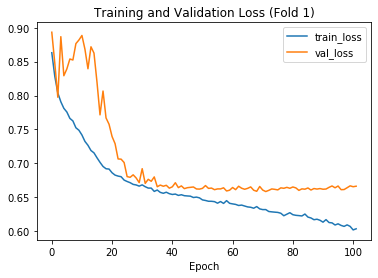

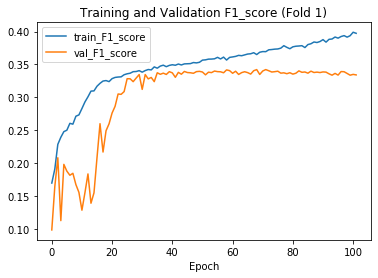

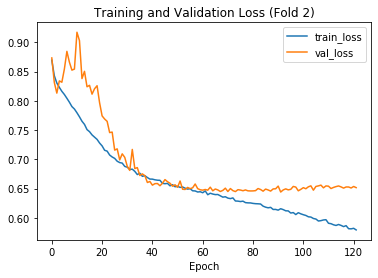

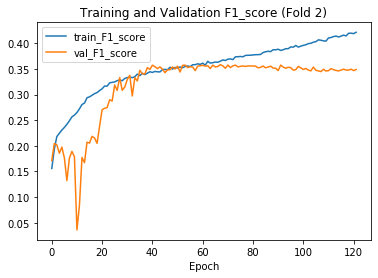

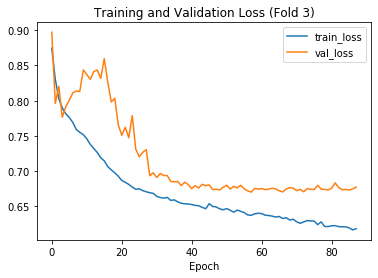

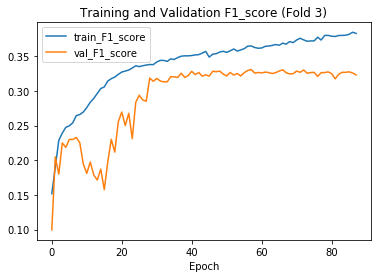

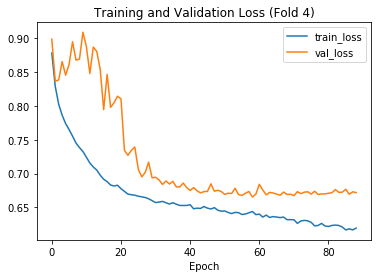

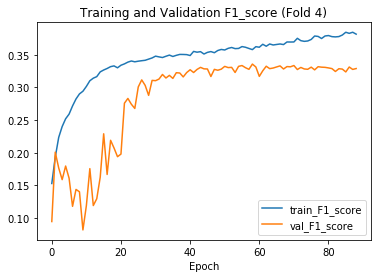

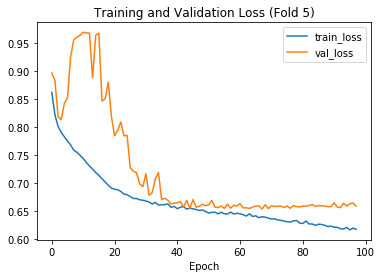

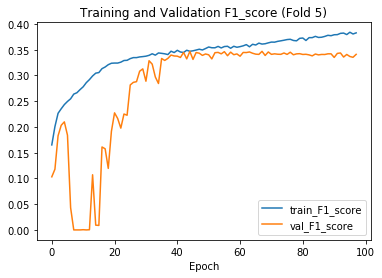

In [44]:

for fold in range(num_folds):
    train_loss = history_list[fold]['loss']
    val_loss = history_list[fold]['val_loss']
    train_F1_score = history_list[fold]['F1_score']
    val_F1_score = history_list[fold]['val_F1_score']

    plt.figure()
    plt.plot(train_loss, label='train_loss')
    plt.plot(val_loss, label='val_loss')
    plt.title('Training and Validation Loss (Fold {})'.format(fold+1))
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(train_F1_score, label='train_F1_score')
    plt.plot(val_F1_score, label='val_F1_score')
    plt.title('Training and Validation F1_score (Fold {})'.format(fold+1))
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()


In [46]:

# Make predictions with the best fold before overfitting and save images.
folder_path_train = '/home/in18657@ad.umbc.edu/Laye_Detection/Prediction/train_thresh_Unet_300_512_aaai'
folder_path_test = '/home/in18657@ad.umbc.edu/Laye_Detection/Prediction/test_thresh_Unet_300_512_aaai'
import numpy as np
import cv2
import os
model = Unet(IMAGE_DIMS, n_filters=16,  dropout=0.5, batchnorm=True, regularization=None, kernel_initializer="he_normal")
model.load_weights('best_model_layer_300_512_UNet_aaai_fold_0.h5')


def save_test_prediction(predictions):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(predictions)):
        pred = (predictions[i] * 255).astype(np.uint8)
        file_name = "Predicted_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), pred)

predictions = model.predict(X_test, batch_size=1)
save_test_prediction(predictions)


def save_original_mask_test(y_test):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(y_test)):
        y_test_i = (y_test[i, :, :, 0] * 255).astype(np.uint8)
        file_name = "Mask_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), y_test_i)

save_original_mask_test(y_test)


def save_original_X_test(X_test):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(X_test)):
        X_test_i = (X_test[i] * 255).astype(np.uint8)
        file_name = "Image_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), X_test_i)

save_original_X_test(X_test)
def save_train_prediction(predictions):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(predictions)):
        pred = (predictions[i] * 255).astype(np.uint8)
        file_name = "Predicted_train_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), pred)

predictions_train = model.predict(image, batch_size=1)
save_train_prediction(predictions_train)


def save_original_mask_train(y_train):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(y_train)):
        mask_i = (y_train[i, :, :, 0] * 255).astype(np.uint8)
        file_name = "Train_mask_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), mask_i)

save_original_mask_train(mask)

def save_original_X_train(X_train):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(X_train)):
        image_i = (X_train[i] * 255).astype(np.uint8)
        file_name = "Train_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), image_i)

save_original_X_train(image)

240/240 [==============================] - 2s 9ms/step


In [13]:
# Train models with augmented data
input_dir = "/home/in18657@ad.umbc.edu/Laye_Detection/raw_aaai"   
target_dir = "/home/in18657@ad.umbc.edu/Laye_Detection/gt_aug_aaai"
image_IMAGE_DIMS=(512,512,3)
mask_IMAGE_DIMS=(512,512,1) 
input_img_paths,target_img_paths=read_files(input_dir,target_dir)
images,masks=create_image_mask_new(input_img_paths,target_img_paths,mask_IMAGE_DIMS,image_IMAGE_DIMS)
from sklearn.model_selection import train_test_split
image, X_test, mask, y_test= train_test_split(images, masks, test_size=0.2, random_state=0)

Number of samples: 900
Number of samples: 900
/home/in18657@ad.umbc.edu/Laye_Detection/raw_aaai/Data_20110329_01_010_0.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt_aug_aaai/Data_20110329_01_010_0.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw_aaai/Data_20110329_01_010_1.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt_aug_aaai/Data_20110329_01_010_1.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw_aaai/Data_20110329_01_010_2.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt_aug_aaai/Data_20110329_01_010_2.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw_aaai/Data_20110329_01_011_0.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt_aug_aaai/Data_20110329_01_011_0.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw_aaai/Data_20110329_01_011_1.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt_aug_aaai/Data_20110329_01_011_1.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw_aaai/Data_20110329_01_011_2.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt_aug_aaai/Data_20110329_01_011_2.png


In [16]:
# Attention U-Net
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))

num_folds = 5
history_list = []
kf = KFold(n_splits=num_folds, shuffle=False, random_state=None)
indices = np.arange(len(image))
indices = shuffle(indices, random_state=0)
images_shuffled = image
masks_shuffled = mask

# Train and evaluate the model with k-fold cross-validation
train_loss_scores = []
train_binary_iou_scores = []
train_dice_coef_scores = []
train_f1_scores = []

val_loss_scores = []
val_binary_iou_scores = []
val_dice_coef_scores = []
val_f1_scores = []

test_f1_scores = []
test_loss_scores = []
test_binary_iou_scores = []
test_dice_coef_scores = []
test_f1_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(images_shuffled)):
    print(f'Fold {fold}')
    # Split the data into train and validation sets for this fold
    train_images, val_images = images_shuffled[train_index], images_shuffled[val_index]
    train_masks, val_masks = masks_shuffled[train_index], masks_shuffled[val_index]
    with strategy.scope():
        input_shape=(512,512,3)
        model = Attention_UNet(input_shape)

        binary_iou =tf.keras.metrics.BinaryIoU(name='binary_iou', threshold=0.5)
        # Compile the model
        model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=F1_score_Loss,
        metrics=[binary_iou,dice_coef,F1_score])
    # Define the EarlyStopping and ModelCheckpoint callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=40, verbose=1,  restore_best_weights=True)

    checkpoint = ModelCheckpoint(f'best_model_layer_300_attention_aaai_aug_fold_{fold}.h5', monitor='val_F1_score',mode='max', save_best_only=True, verbose=1)


    history = model.fit(train_images, train_masks, epochs=300, batch_size=8,
                        validation_data=(val_images, val_masks),
                        callbacks=[early_stop, checkpoint],verbose=0)


    save_model(model, f'complete_best_model_layer_300_attention_aaai_aug_fold_{fold}.h5')
    history_list.append(history.history)
   
    model.load_weights(f'best_model_layer_300_attention_aaai_aug_fold_{fold}.h5')
    # Evaluate the performance of the best model on the train, validation, and test sets
    train_scores = model.evaluate(train_images, train_masks, batch_size=8)
    val_scores = model.evaluate(val_images, val_masks, batch_size=8)
    test_scores=model.evaluate(X_test,y_test, batch_size=8)

    # Print the performance of the best model on this fold's train, validation, and test sets
    train_loss_scores.append(train_scores[0])
    train_binary_iou_scores.append(train_scores[1])
    train_dice_coef_scores.append(train_scores[2])
    train_f1_scores.append(train_scores[3])

    val_loss_scores.append(val_scores[0])
    val_binary_iou_scores.append(val_scores[1])
    val_dice_coef_scores.append(val_scores[2])
    val_f1_scores.append(val_scores[3])

    test_loss_scores.append(test_scores[0])
    test_binary_iou_scores.append(test_scores[1])
    test_dice_coef_scores.append(test_scores[2])
    test_f1_scores.append(test_scores[3])
    


    print('Fold', fold+1)
    print('Train loss:', train_scores[0])
    print('Train binary IOU:', train_scores[1])
    print('Train dice coef:', train_scores[2])
    print('Train F1:', train_scores[3])
    print('------------------------')
    print('Val loss:', val_scores[0])
    print('Val binary IOU:', val_scores[1])
    print('Val dice coef:', val_scores[2])
    print('Val F1:', val_scores[3])
    print('------------------------')
    print('test loss:', test_scores[0])
    print('test binary IOU:', test_scores[1])
    print('test_dice coef:', test_scores[2])
    print('test F1:', test_scores[3])
    print('------------------------')

# Calculate the average scores over all folds
avg_train_loss = np.mean(train_loss_scores)
avg_train_binary_iou = np.mean(train_binary_iou_scores)
avg_train_dice_coef = np.mean(train_dice_coef_scores)
avg_train_f1 = np.mean(train_f1_scores)
print('------------------------')
avg_val_loss = np.mean(val_loss_scores)
avg_val_binary_iou = np.mean(val_binary_iou_scores)
avg_val_dice_coef = np.mean(val_dice_coef_scores)
avg_val_f1 = np.mean(val_f1_scores)
print('------------------------')
avg_test_loss = np.mean(test_loss_scores)
avg_test_binary_iou = np.mean(test_binary_iou_scores)
avg_test_dice_coef = np.mean(test_dice_coef_scores)
avg_test_f1 = np.mean(test_f1_scores)

# Print the final average scores
print('Average train loss:', avg_train_loss)
print('Average train binary IoU:', avg_train_binary_iou)
print('Average train Dice coefficient:', avg_train_dice_coef)

print('Average train F1 score:', avg_train_f1)
print('------------------------')
print('Average validation loss:', avg_val_loss)
print('Average validation binary IoU:', avg_val_binary_iou)
print('Average validation Dice coefficient:', avg_val_dice_coef)

print('Average validation F1 score:', avg_val_f1)
print('------------------------')
print('Average test loss:', avg_test_loss)
print('Average test binary IoU:', avg_test_binary_iou)
print('Average test Dice coefficient:', avg_test_dice_coef)
print('Average test F1 score:', avg_test_f1)
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))

Current Time = 01:07:39
Fold 0
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device

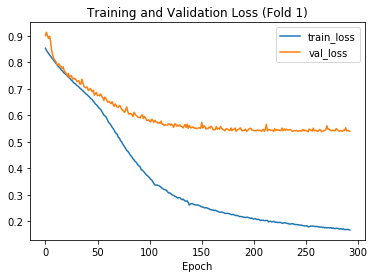

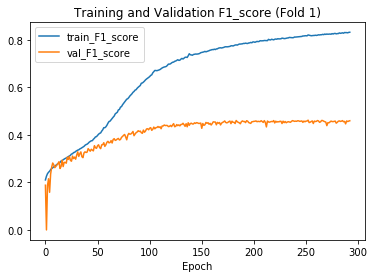

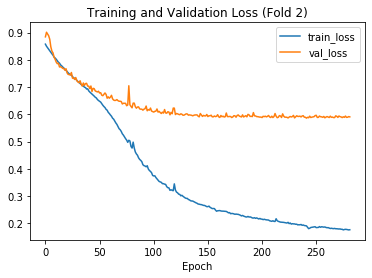

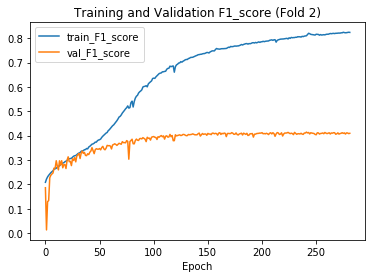

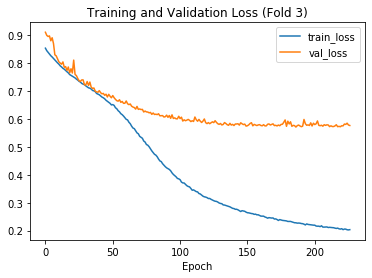

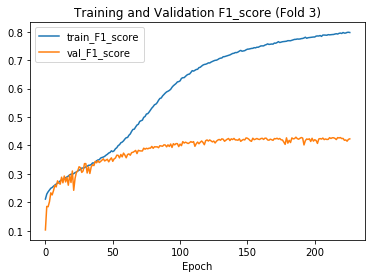

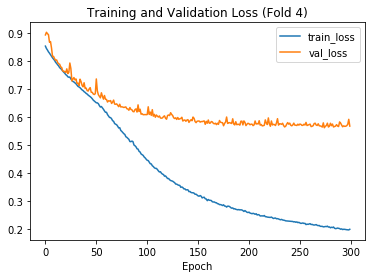

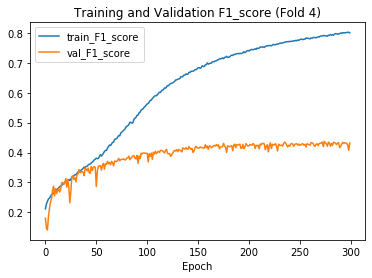

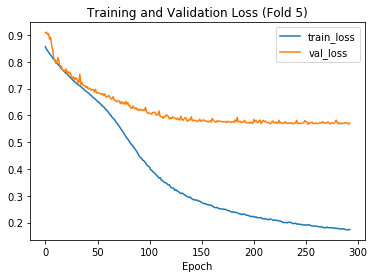

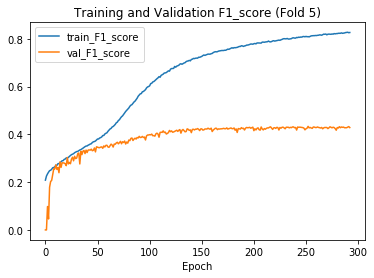

In [17]:
for fold in range(num_folds):
    train_loss = history_list[fold]['loss']
    val_loss = history_list[fold]['val_loss']
    train_F1_score = history_list[fold]['F1_score']
    val_F1_score = history_list[fold]['val_F1_score']
    plt.figure()
    plt.plot(train_loss, label='train_loss')
    plt.plot(val_loss, label='val_loss')
    plt.title('Training and Validation Loss (Fold {})'.format(fold+1))
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(train_F1_score, label='train_F1_score')
    plt.plot(val_F1_score, label='val_F1_score')
    plt.title('Training and Validation F1_score (Fold {})'.format(fold+1))
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [18]:
# Make predictions with the best fold before overfitting and save images.
folder_path_train = '/home/in18657@ad.umbc.edu/Laye_Detection/Prediction/train_thresh_attention_300_aug_aaai'
folder_path_test = '/home/in18657@ad.umbc.edu/Laye_Detection/Prediction/test_thresh_attention_300_aug_aaai'
import numpy as np
import cv2
import os
model = Attention_UNet(input_shape)

model.load_weights('best_model_layer_300_attention_aaai_aug_fold_0.h5')


def save_test_prediction(predictions):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(predictions)):
        pred = (predictions[i] * 255).astype(np.uint8)
        file_name = "Predicted_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), pred)

predictions = model.predict(X_test, batch_size=1)
save_test_prediction(predictions)


def save_original_mask_test(y_test):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(y_test)):
        y_test_i = (y_test[i, :, :, 0] * 255).astype(np.uint8)
        file_name = "Mask_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), y_test_i)

save_original_mask_test(y_test)


def save_original_X_test(X_test):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(X_test)):
        X_test_i = (X_test[i] * 255).astype(np.uint8)
        file_name = "Image_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), X_test_i)

save_original_X_test(X_test)
def save_train_prediction(predictions):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(predictions)):
        pred = (predictions[i] * 255).astype(np.uint8)
        file_name = "Predicted_train_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), pred)

predictions_train = model.predict(image, batch_size=1)
save_train_prediction(predictions_train)

def save_original_mask_train(y_train):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(y_train)):
        mask_i = (y_train[i, :, :, 0] * 255).astype(np.uint8)
        file_name = "Train_mask_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), mask_i)

save_original_mask_train(mask)


def save_original_X_train(X_train):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(X_train)):
        image_i = (X_train[i] * 255).astype(np.uint8)
        file_name = "Train_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), image_i)

save_original_X_train(image)

720/720 [==============================] - 21s 29ms/step


In [15]:
# U-Net
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))
num_folds = 5
history_list = []

kf = KFold(n_splits=num_folds, shuffle=False, random_state=None)
indices = np.arange(len(image))
indices = shuffle(indices, random_state=0)
images_shuffled = image
masks_shuffled = mask


# Train and evaluate the model with k-fold cross-validation
train_loss_scores = []
train_binary_iou_scores = []
train_dice_coef_scores = []
train_f1_scores = []

val_loss_scores = []
val_binary_iou_scores = []
val_dice_coef_scores = []
val_f1_scores = []

test_f1_scores = []
test_loss_scores = []
test_binary_iou_scores = []
test_dice_coef_scores = []
test_f1_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(images_shuffled)):
    print(f'Fold {fold}')
    # Split the data into train and validation sets for this fold
    train_images, val_images = images_shuffled[train_index], images_shuffled[val_index]
    train_masks, val_masks = masks_shuffled[train_index], masks_shuffled[val_index]
    
    IMAGE_DIMS = (512,512,3)

    with strategy.scope():
        model = Unet(IMAGE_DIMS, n_filters=16,  dropout=0.5, batchnorm=True, regularization=None, kernel_initializer="he_normal")

        binary_iou =tf.keras.metrics.BinaryIoU(name='binary_iou', threshold=0.5)
        # Compile the model
        model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=F1_score_Loss,
        metrics=[binary_iou,dice_coef,F1_score])
    
    
    # Define the EarlyStopping and ModelCheckpoint callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=40, verbose=1,  restore_best_weights=True)

    checkpoint = ModelCheckpoint(f'best_model_layer_300_UNet_aaai_aug_fold_{fold}.h5', monitor='val_F1_score',mode='max', save_best_only=True, verbose=1)
    history = model.fit(train_images, train_masks, epochs=300, batch_size=8,
                        validation_data=(val_images, val_masks),
                        callbacks=[early_stop, checkpoint],verbose=0)


    save_model(model, f'complete_best_model_layer_300_UNet_aaai_aug_fold_{fold}.h5')
    history_list.append(history.history)
    model.load_weights(f'best_model_layer_300_UNet_aaai_aug_fold_{fold}.h5')
    # Evaluate the performance of the best model on the train, validation, and test sets
    train_scores = model.evaluate(train_images, train_masks, batch_size=8)
    val_scores = model.evaluate(val_images, val_masks, batch_size=8)
    test_scores=model.evaluate(X_test,y_test, batch_size=8)

    # Print the performance of the best model on this fold's train, validation, and test sets
    train_loss_scores.append(train_scores[0])
    train_binary_iou_scores.append(train_scores[1])
    train_dice_coef_scores.append(train_scores[2])
    train_f1_scores.append(train_scores[3])

    val_loss_scores.append(val_scores[0])
    val_binary_iou_scores.append(val_scores[1])
    val_dice_coef_scores.append(val_scores[2])
    val_f1_scores.append(val_scores[3])

    test_loss_scores.append(test_scores[0])
    test_binary_iou_scores.append(test_scores[1])
    test_dice_coef_scores.append(test_scores[2])
    test_f1_scores.append(test_scores[3])

    print('Fold', fold+1)
    print('Train loss:', train_scores[0])
    print('Train binary IOU:', train_scores[1])
    print('Train dice coef:', train_scores[2])
    print('Train F1:', train_scores[3])
    print('------------------------')
    print('Val loss:', val_scores[0])
    print('Val binary IOU:', val_scores[1])
    print('Val dice coef:', val_scores[2])
    print('Val F1:', val_scores[3])
    print('------------------------')
    print('test loss:', test_scores[0])
    print('test binary IOU:', test_scores[1])
    print('test_dice coef:', test_scores[2])
    print('test F1:', test_scores[3])
    print('------------------------')

# Calculate the average scores over all folds
avg_train_loss = np.mean(train_loss_scores)
avg_train_binary_iou = np.mean(train_binary_iou_scores)
avg_train_dice_coef = np.mean(train_dice_coef_scores)
avg_train_f1 = np.mean(train_f1_scores)
print('------------------------')
avg_val_loss = np.mean(val_loss_scores)
avg_val_binary_iou = np.mean(val_binary_iou_scores)
avg_val_dice_coef = np.mean(val_dice_coef_scores)
avg_val_f1 = np.mean(val_f1_scores)
print('------------------------')
avg_test_loss = np.mean(test_loss_scores)
avg_test_binary_iou = np.mean(test_binary_iou_scores)
avg_test_dice_coef = np.mean(test_dice_coef_scores)
avg_test_f1 = np.mean(test_f1_scores)

# Print the final average scores
print('Average train loss:', avg_train_loss)
print('Average train binary IoU:', avg_train_binary_iou)
print('Average train Dice coefficient:', avg_train_dice_coef)

print('Average train F1 score:', avg_train_f1)
print('------------------------')
print('Average validation loss:', avg_val_loss)
print('Average validation binary IoU:', avg_val_binary_iou)
print('Average validation Dice coefficient:', avg_val_dice_coef)

print('Average validation F1 score:', avg_val_f1)
print('------------------------')
print('Average test loss:', avg_test_loss)
print('Average test binary IoU:', avg_test_binary_iou)
print('Average test Dice coefficient:', avg_test_dice_coef)
print('Average test F1 score:', avg_test_f1)
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))

Current Time = 18:42:31
Fold 0

Epoch 1: val_F1_score improved from -inf to 0.20532, saving model to best_model_layer_300_UNet_aaai_aug_fold_0.h5

Epoch 2: val_F1_score did not improve from 0.20532

Epoch 3: val_F1_score did not improve from 0.20532

Epoch 4: val_F1_score did not improve from 0.20532

Epoch 5: val_F1_score did not improve from 0.20532

Epoch 6: val_F1_score improved from 0.20532 to 0.20535, saving model to best_model_layer_300_UNet_aaai_aug_fold_0.h5

Epoch 7: val_F1_score did not improve from 0.20535

Epoch 8: val_F1_score improved from 0.20535 to 0.26452, saving model to best_model_layer_300_UNet_aaai_aug_fold_0.h5

Epoch 9: val_F1_score improved from 0.26452 to 0.27534, saving model to best_model_layer_300_UNet_aaai_aug_fold_0.h5

Epoch 10: val_F1_score did not improve from 0.27534

Epoch 11: val_F1_score improved from 0.27534 to 0.30471, saving model to best_model_layer_300_UNet_aaai_aug_fold_0.h5

Epoch 12: val_F1_score improved from 0.30471 to 0.31827, saving mod

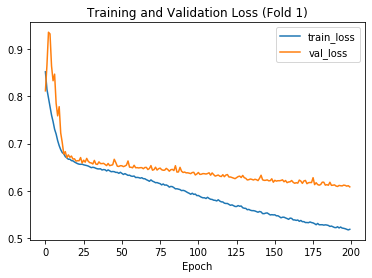

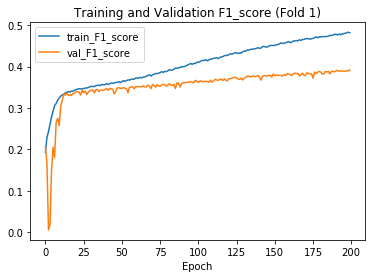

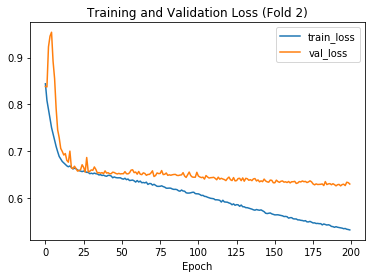

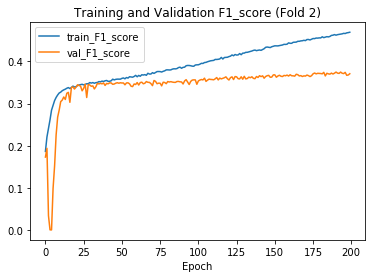

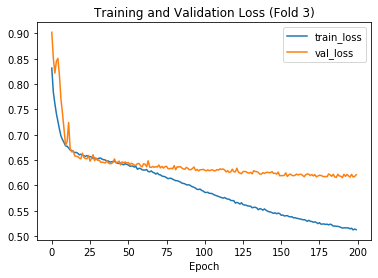

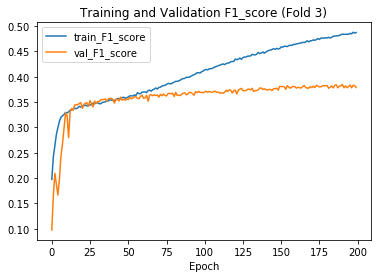

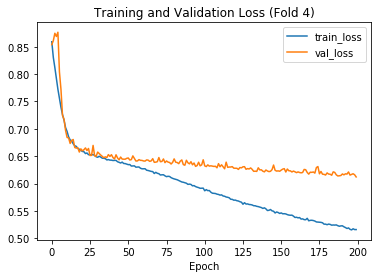

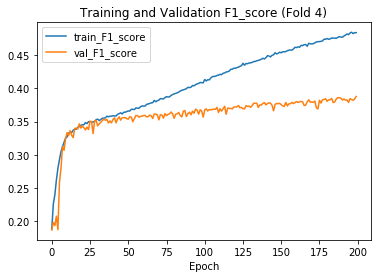

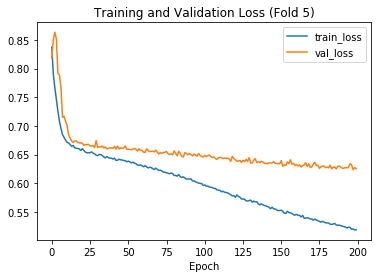

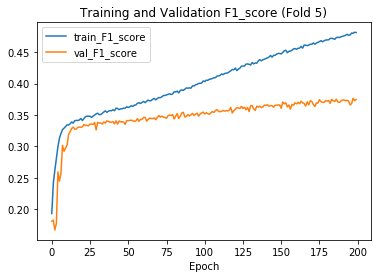

In [16]:

for fold in range(num_folds):
    train_loss = history_list[fold]['loss']
    val_loss = history_list[fold]['val_loss']
    train_F1_score = history_list[fold]['F1_score']
    val_F1_score = history_list[fold]['val_F1_score']
    plt.figure()
    plt.plot(train_loss, label='train_loss')
    plt.plot(val_loss, label='val_loss')
    plt.title('Training and Validation Loss (Fold {})'.format(fold+1))
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(train_F1_score, label='train_F1_score')
    plt.plot(val_F1_score, label='val_F1_score')
    plt.title('Training and Validation F1_score (Fold {})'.format(fold+1))
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [19]:

# Make predictions with the best fold before overfitting and save images.
folder_path_train = '/home/in18657@ad.umbc.edu/Laye_Detection/Prediction/train_thresh_Unet_300_aug_aaai'
folder_path_test = '/home/in18657@ad.umbc.edu/Laye_Detection/Prediction/test_thresh_Unet_300_aug_aaai'
import numpy as np
import cv2
import os
model = Unet(IMAGE_DIMS, n_filters=16,  dropout=0.5, batchnorm=True, regularization=None, kernel_initializer="he_normal")
model.load_weights('best_model_layer_300_UNet_aaai_aug_fold_0.h5')


def save_test_prediction(predictions):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(predictions)):
        pred = (predictions[i] * 255).astype(np.uint8)
        file_name = "Predicted_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), pred)

predictions = model.predict(X_test, batch_size=1)
save_test_prediction(predictions)


def save_original_mask_test(y_test):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(y_test)):
        y_test_i = (y_test[i, :, :, 0] * 255).astype(np.uint8)
        file_name = "Mask_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), y_test_i)

save_original_mask_test(y_test)


def save_original_X_test(X_test):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(X_test)):
        X_test_i = (X_test[i] * 255).astype(np.uint8)
        file_name = "Image_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), X_test_i)

save_original_X_test(X_test)
def save_train_prediction(predictions):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(predictions)):
        pred = (predictions[i] * 255).astype(np.uint8)
        file_name = "Predicted_train_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), pred)

predictions_train = model.predict(image, batch_size=1)
save_train_prediction(predictions_train)


def save_original_mask_train(y_train):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(y_train)):
        mask_i = (y_train[i, :, :, 0] * 255).astype(np.uint8)
        file_name = "Train_mask_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), mask_i)

save_original_mask_train(mask)

def save_original_X_train(X_train):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(X_train)):
        image_i = (X_train[i] * 255).astype(np.uint8)
        file_name = "Train_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), image_i)

save_original_X_train(image)

720/720 [==============================] - 6s 8ms/step


In [23]:
# VGG19 + U-Net

print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))
num_folds = 5
history_list = []

kf = KFold(n_splits=num_folds, shuffle=False, random_state=None)
indices = np.arange(len(image))
indices = shuffle(indices, random_state=0)
images_shuffled = image
masks_shuffled = mask

# Train and evaluate the model with k-fold cross-validation
train_loss_scores = []
train_binary_iou_scores = []
train_dice_coef_scores = []
train_f1_scores = []

val_loss_scores = []
val_binary_iou_scores = []
val_dice_coef_scores = []
val_f1_scores = []

test_f1_scores = []
test_loss_scores = []
test_binary_iou_scores = []
test_dice_coef_scores = []
test_f1_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(images_shuffled)):
    print(f'Fold {fold}')
    # Split the data into train and validation sets for this fold
    train_images, val_images = images_shuffled[train_index], images_shuffled[val_index]
    train_masks, val_masks = masks_shuffled[train_index], masks_shuffled[val_index]
    
    input_shape = (512,512,3)
    import tensorflow as tf
    gpus = tf.config.experimental.list_physical_devices("GPU")
    tf.config.experimental.set_visible_devices(gpus[1:4], "GPU")
    
    strategy = tf.distribute.MirroredStrategy(devices=[ "GPU:1","GPU:2", "GPU:3"])
    with strategy.scope():
    
        model = build_vgg19_unet(input_shape) 

        binary_iou =tf.keras.metrics.BinaryIoU(name='binary_iou', threshold=0.5)
        # Compile the model
        model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=F1_score_Loss,
        metrics=[binary_iou,dice_coef,F1_score])
    
    
    # Define the EarlyStopping and ModelCheckpoint callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=25, verbose=1,  restore_best_weights=True)

    checkpoint = ModelCheckpoint(f'best_model_layer_300_thresh_128_vgg_aug_aaai_fold_{fold}.h5', monitor='val_F1_score',mode='max', save_best_only=True, verbose=1)


    history = model.fit(train_images, train_masks, epochs=300, batch_size=8,
                        validation_data=(val_images, val_masks),
                        callbacks=[early_stop, checkpoint],verbose=0)


    save_model(model, f'complete_model_layer_300_thresh_128_vgg_aug_aaai_fold_{fold}.h5')
    history_list.append(history.history)
   
    model.load_weights(f'best_model_layer_300_thresh_128_vgg_aug_aaai_fold_{fold}.h5')
    # Evaluate the performance of the best model on the train, validation, and test sets
    train_scores = model.evaluate(train_images, train_masks, batch_size=8)
    val_scores = model.evaluate(val_images, val_masks, batch_size=8)
    test_scores=model.evaluate(X_test,y_test, batch_size=8)
    # Print the performance of the best model on this fold's train, validation, and test sets
    train_loss_scores.append(train_scores[0])
    train_binary_iou_scores.append(train_scores[1])
    train_dice_coef_scores.append(train_scores[2])
    train_f1_scores.append(train_scores[3])

    val_loss_scores.append(val_scores[0])
    val_binary_iou_scores.append(val_scores[1])
    val_dice_coef_scores.append(val_scores[2])
    val_f1_scores.append(val_scores[3])

    test_loss_scores.append(test_scores[0])
    test_binary_iou_scores.append(test_scores[1])
    test_dice_coef_scores.append(test_scores[2])
    test_f1_scores.append(test_scores[3])
    


    print('Fold', fold+1)
    print('Train loss:', train_scores[0])
    print('Train binary IOU:', train_scores[1])
    print('Train dice coef:', train_scores[2])
    print('Train F1:', train_scores[3])
    print('------------------------')
    print('Val loss:', val_scores[0])
    print('Val binary IOU:', val_scores[1])
    print('Val dice coef:', val_scores[2])
    print('Val F1:', val_scores[3])
    print('------------------------')
    print('test loss:', test_scores[0])
    print('test binary IOU:', test_scores[1])
    print('test_dice coef:', test_scores[2])
    print('test F1:', test_scores[3])
    print('------------------------')

# Calculate the average scores over all folds
avg_train_loss = np.mean(train_loss_scores)
avg_train_binary_iou = np.mean(train_binary_iou_scores)
avg_train_dice_coef = np.mean(train_dice_coef_scores)
avg_train_f1 = np.mean(train_f1_scores)
print('------------------------')
avg_val_loss = np.mean(val_loss_scores)
avg_val_binary_iou = np.mean(val_binary_iou_scores)
avg_val_dice_coef = np.mean(val_dice_coef_scores)
avg_val_f1 = np.mean(val_f1_scores)
print('------------------------')
avg_test_loss = np.mean(test_loss_scores)
avg_test_binary_iou = np.mean(test_binary_iou_scores)
avg_test_dice_coef = np.mean(test_dice_coef_scores)
avg_test_f1 = np.mean(test_f1_scores)

# Print the final average scores
print('Average train loss:', avg_train_loss)
print('Average train binary IoU:', avg_train_binary_iou)
print('Average train Dice coefficient:', avg_train_dice_coef)
print('------------------------')
print('Average train F1 score:', avg_train_f1)
print('Average validation loss:', avg_val_loss)
print('Average validation binary IoU:', avg_val_binary_iou)
print('Average validation Dice coefficient:', avg_val_dice_coef)
print('------------------------')
print('Average validation F1 score:', avg_val_f1)
print('Average test loss:', avg_test_loss)
print('Average test binary IoU:', avg_test_binary_iou)
print('Average test Dice coefficient:', avg_test_dice_coef)
print('Average test F1 score:', avg_test_f1)
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))

Current Time = 01:31:22
Fold 0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')

Epoch 1: val_F1_score improved from -inf to 0.00000, saving model to best_model_layer_300_thresh_128_vgg_aug_aaai_fold_0.h5

Epoch 2: val_F1_score improved from 0.00000 to 0.03092, saving model to best_model_layer_300_thresh_128_vgg_aug_aaai_fold_0.h5

Epoch 3: val_F1_score improved from 0.03092 to 0.05426, saving model to best_model_layer_300_thresh_128_vgg_aug_aaai_fold_0.h5

Epoch 4: val_F1_score did not improve from 0.05426

Epoch 5: val_F1_score improved from 0.05426 to 0.14966, saving model to best_model_layer_300_thresh_128_vgg_aug_aaai_fold_0.h5

Epoch 6: val_F1_score improved from 0.14966 to 0.27584, saving model to best_model_layer_300_thresh_128_vgg_aug_aaai_fold_0.h5

Epoch 7: val_F1_score did not improve from 0.27584

Epoch 8: val_F1_score improved

In [27]:

# Make predictions with the best fold before overfitting and save images.
folder_path_train = '/home/in18657@ad.umbc.edu/Laye_Detection/Prediction/train_thresh_vgg_300_aug_aaai'
folder_path_test = '/home/in18657@ad.umbc.edu/Laye_Detection/Prediction/test_thresh_vgg_300_aug_aaai'
import numpy as np
import cv2
import os
model = build_vgg19_unet(input_shape)
model.load_weights('best_model_layer_300_thresh_128_vgg_aug_aaai_fold_0.h5')


def save_test_prediction(predictions):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(predictions)):
        pred = (predictions[i] * 255).astype(np.uint8)
        file_name = "Predicted_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), pred)

predictions = model.predict(X_test, batch_size=1)
save_test_prediction(predictions)


def save_original_mask_test(y_test):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(y_test)):
        y_test_i = (y_test[i, :, :, 0] * 255).astype(np.uint8)
        file_name = "Mask_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), y_test_i)

save_original_mask_test(y_test)


def save_original_X_test(X_test):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(X_test)):
        X_test_i = (X_test[i] * 255).astype(np.uint8)
        file_name = "Image_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), X_test_i)

save_original_X_test(X_test)
def save_train_prediction(predictions):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(predictions)):
        pred = (predictions[i] * 255).astype(np.uint8)
        file_name = "Predicted_train_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), pred)

predictions_train = model.predict(image, batch_size=1)
save_train_prediction(predictions_train)


def save_original_mask_train(y_train):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(y_train)):
        mask_i = (y_train[i, :, :, 0] * 255).astype(np.uint8)
        file_name = "Train_mask_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), mask_i)

save_original_mask_train(mask)
def save_original_X_train(X_train):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(X_train)):
        image_i = (X_train[i] * 255).astype(np.uint8)
        file_name = "Train_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), image_i)

save_original_X_train(image)

720/720 [==============================] - 17s 23ms/step


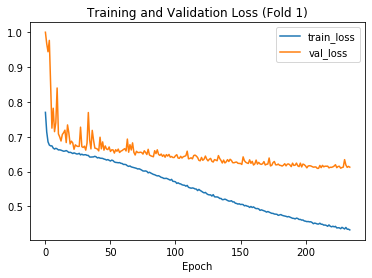

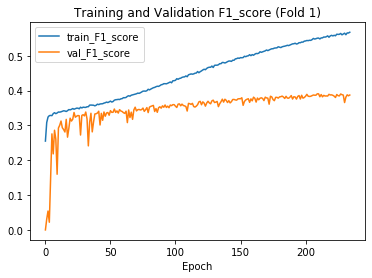

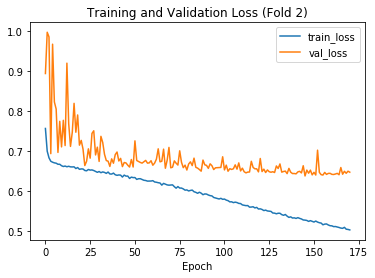

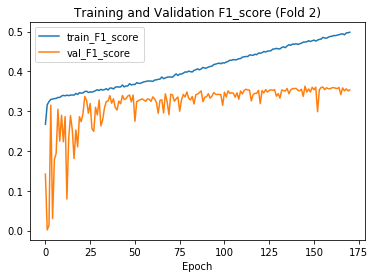

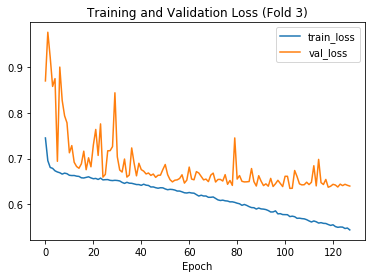

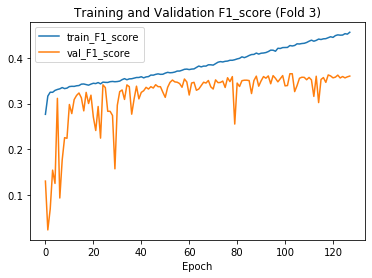

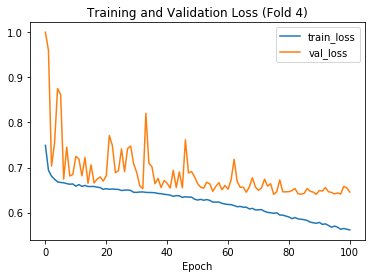

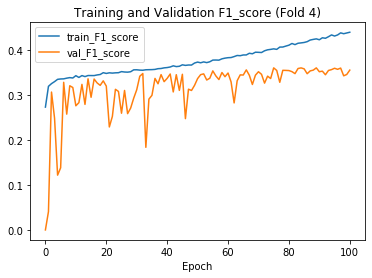

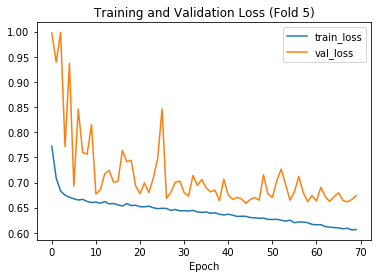

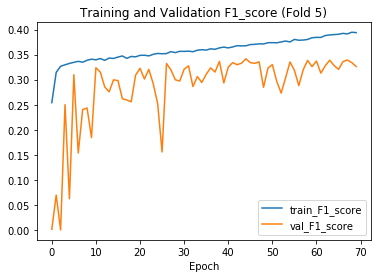

In [24]:
for fold in range(num_folds):
    train_loss = history_list[fold]['loss']
    val_loss = history_list[fold]['val_loss']
    train_F1_score = history_list[fold]['F1_score']
    val_F1_score = history_list[fold]['val_F1_score']
    plt.figure()
    plt.plot(train_loss, label='train_loss')
    plt.plot(val_loss, label='val_loss')
    plt.title('Training and Validation Loss (Fold {})'.format(fold+1))
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(train_F1_score, label='train_F1_score')
    plt.plot(val_F1_score, label='val_F1_score')
    plt.title('Training and Validation F1_score (Fold {})'.format(fold+1))
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [28]:
# Inception + U-Net

print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))
num_folds = 5
history_list = []
kf = KFold(n_splits=num_folds, shuffle=False, random_state=None)
indices = np.arange(len(image))
indices = shuffle(indices, random_state=0)
images_shuffled = image
masks_shuffled = mask

# Train and evaluate the model with k-fold cross-validation
train_loss_scores = []
train_binary_iou_scores = []
train_dice_coef_scores = []
train_f1_scores = []

val_loss_scores = []
val_binary_iou_scores = []
val_dice_coef_scores = []
val_f1_scores = []

test_f1_scores = []
test_loss_scores = []
test_binary_iou_scores = []
test_dice_coef_scores = []
test_f1_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(images_shuffled)):
    print(f'Fold {fold}')
    # Split the data into train and validation sets for this fold
    train_images, val_images = images_shuffled[train_index], images_shuffled[val_index]
    train_masks, val_masks = masks_shuffled[train_index], masks_shuffled[val_index]
    
    input_shape = (512,512,3)
    import tensorflow as tf
    gpus = tf.config.experimental.list_physical_devices("GPU")
    tf.config.experimental.set_visible_devices(gpus[1:4], "GPU")
    
    strategy = tf.distribute.MirroredStrategy(devices=[ "GPU:1","GPU:2", "GPU:3"])
    with strategy.scope():

        model = unet_plus_inception(IMAGE_DIMS) 
        binary_iou =tf.keras.metrics.BinaryIoU(name='binary_iou', threshold=0.5)
        # Compile the model
        model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=F1_score_Loss,
        metrics=[binary_iou,dice_coef,F1_score])
    
    
    # Define the EarlyStopping and ModelCheckpoint callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=25, verbose=1,  restore_best_weights=True)

    checkpoint = ModelCheckpoint(f'best_model_layer_300_thresh_128_inception_aug_aaai_fold_{fold}.h5', monitor='val_F1_score',mode='max', save_best_only=True, verbose=1)

    history = model.fit(train_images, train_masks, epochs=300, batch_size=8,
                        validation_data=(val_images, val_masks),
                        callbacks=[early_stop, checkpoint],verbose=0)


    save_model(model, f'complete_model_layer_300_thresh_128_inception_aug_aaai_fold_{fold}.h5')
    history_list.append(history.history)
   
    model.load_weights(f'best_model_layer_300_thresh_128_inception_aug_aaai_fold_{fold}.h5')
    # Evaluate the performance of the best model on the train, validation, and test sets
    train_scores = model.evaluate(train_images, train_masks, batch_size=8)
    val_scores = model.evaluate(val_images, val_masks, batch_size=8)
    test_scores=model.evaluate(X_test,y_test, batch_size=8)
    
    # Print the performance of the best model on this fold's train, validation, and test sets
    train_loss_scores.append(train_scores[0])
    train_binary_iou_scores.append(train_scores[1])
    train_dice_coef_scores.append(train_scores[2])
    train_f1_scores.append(train_scores[3])

    val_loss_scores.append(val_scores[0])
    val_binary_iou_scores.append(val_scores[1])
    val_dice_coef_scores.append(val_scores[2])
    val_f1_scores.append(val_scores[3])

    test_loss_scores.append(test_scores[0])
    test_binary_iou_scores.append(test_scores[1])
    test_dice_coef_scores.append(test_scores[2])
    test_f1_scores.append(test_scores[3])
    


    print('Fold', fold+1)
    print('Train loss:', train_scores[0])
    print('Train binary IOU:', train_scores[1])
    print('Train dice coef:', train_scores[2])
    print('Train F1:', train_scores[3])
    print('------------------------')
    print('Val loss:', val_scores[0])
    print('Val binary IOU:', val_scores[1])
    print('Val dice coef:', val_scores[2])
    print('Val F1:', val_scores[3])
    print('------------------------')
    print('test loss:', test_scores[0])
    print('test binary IOU:', test_scores[1])
    print('test_dice coef:', test_scores[2])
    print('test F1:', test_scores[3])
    print('------------------------')

# Calculate the average scores over all folds
avg_train_loss = np.mean(train_loss_scores)
avg_train_binary_iou = np.mean(train_binary_iou_scores)
avg_train_dice_coef = np.mean(train_dice_coef_scores)
avg_train_f1 = np.mean(train_f1_scores)
print('------------------------')
avg_val_loss = np.mean(val_loss_scores)
avg_val_binary_iou = np.mean(val_binary_iou_scores)
avg_val_dice_coef = np.mean(val_dice_coef_scores)
avg_val_f1 = np.mean(val_f1_scores)
print('------------------------')
avg_test_loss = np.mean(test_loss_scores)
avg_test_binary_iou = np.mean(test_binary_iou_scores)
avg_test_dice_coef = np.mean(test_dice_coef_scores)
avg_test_f1 = np.mean(test_f1_scores)

# Print the final average scores
print('Average train loss:', avg_train_loss)
print('Average train binary IoU:', avg_train_binary_iou)
print('Average train Dice coefficient:', avg_train_dice_coef)
print('------------------------')
print('Average train F1 score:', avg_train_f1)
print('Average validation loss:', avg_val_loss)
print('Average validation binary IoU:', avg_val_binary_iou)
print('Average validation Dice coefficient:', avg_val_dice_coef)
print('------------------------')
print('Average validation F1 score:', avg_val_f1)
print('Average test loss:', avg_test_loss)
print('Average test binary IoU:', avg_test_binary_iou)
print('Average test Dice coefficient:', avg_test_dice_coef)
print('Average test F1 score:', avg_test_f1)
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))

Current Time = 11:18:44
Fold 0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')

Epoch 1: val_F1_score improved from -inf to 0.00000, saving model to best_model_layer_300_thresh_128_inception_aug_aaai_fold_0.h5

Epoch 2: val_F1_score improved from 0.00000 to 0.01450, saving model to best_model_layer_300_thresh_128_inception_aug_aaai_fold_0.h5

Epoch 3: val_F1_score improved from 0.01450 to 0.02178, saving model to best_model_layer_300_thresh_128_inception_aug_aaai_fold_0.h5

Epoch 4: val_F1_score improved from 0.02178 to 0.07870, saving model to best_model_layer_300_thresh_128_inception_aug_aaai_fold_0.h5

Epoch 5: val_F1_score did not improve from 0.07870

Epoch 6: val_F1_score improved from 0.07870 to 0.20609, saving model to best_model_layer_300_thresh_128_inception_aug_aaai_fold_0.h5

Epoch 7: val_F1_score did not improve from 0.20609



In [31]:

# Make predictions with the best fold before overfitting and save images.
folder_path_train = '/home/in18657@ad.umbc.edu/Laye_Detection/Prediction/train_thresh_inception_300_aug_aaai'
folder_path_test = '/home/in18657@ad.umbc.edu/Laye_Detection/Prediction/test_thresh_inception_300_aug_aaai'
import numpy as np
import cv2
import os
model = unet_plus_inception(IMAGE_DIMS)
model.load_weights('best_model_layer_300_thresh_128_inception_aug_aaai_fold_0.h5')


def save_test_prediction(predictions):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(predictions)):
        pred = (predictions[i] * 255).astype(np.uint8)
        file_name = "Predicted_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), pred)

predictions = model.predict(X_test, batch_size=1)
save_test_prediction(predictions)


def save_original_mask_test(y_test):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(y_test)):
        y_test_i = (y_test[i, :, :, 0] * 255).astype(np.uint8)
        file_name = "Mask_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), y_test_i)

save_original_mask_test(y_test)


def save_original_X_test(X_test):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(X_test)):
        X_test_i = (X_test[i] * 255).astype(np.uint8)
        file_name = "Image_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), X_test_i)

save_original_X_test(X_test)
def save_train_prediction(predictions):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(predictions)):
        pred = (predictions[i] * 255).astype(np.uint8)
        file_name = "Predicted_train_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), pred)

predictions_train = model.predict(image, batch_size=1)
save_train_prediction(predictions_train)


def save_original_mask_train(y_train):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(y_train)):
        mask_i = (y_train[i, :, :, 0] * 255).astype(np.uint8)
        file_name = "Train_mask_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), mask_i)

save_original_mask_train(mask)


def save_original_X_train(X_train):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(X_train)):
        image_i = (X_train[i] * 255).astype(np.uint8)
        file_name = "Train_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), image_i)

save_original_X_train(image)


720/720 [==============================] - 23s 32ms/step


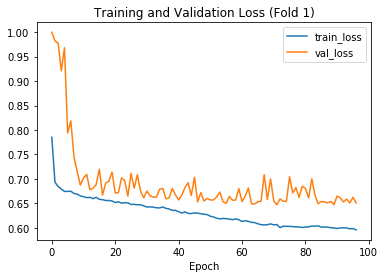

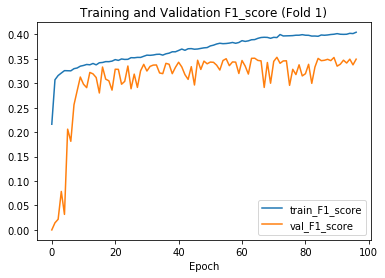

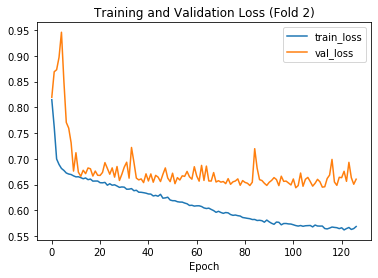

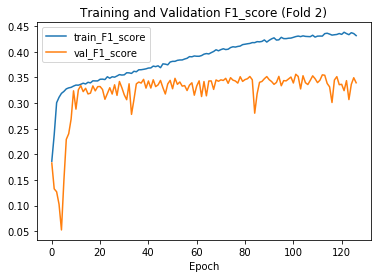

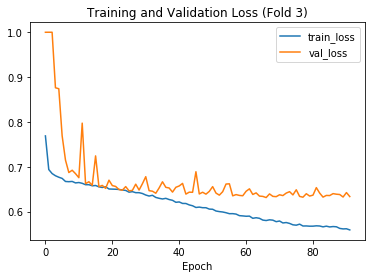

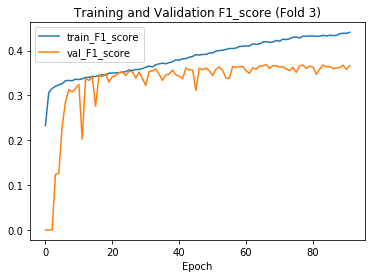

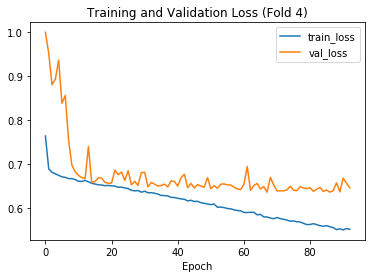

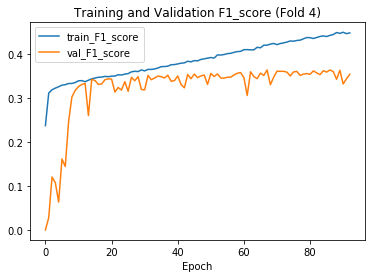

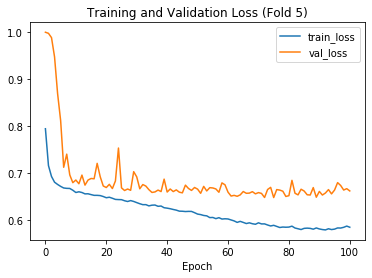

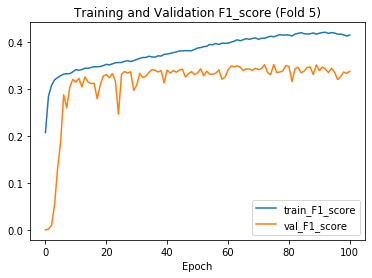

In [29]:
for fold in range(num_folds):
    train_loss = history_list[fold]['loss']
    val_loss = history_list[fold]['val_loss']
    train_F1_score = history_list[fold]['F1_score']
    val_F1_score = history_list[fold]['val_F1_score']
    plt.figure()
    plt.plot(train_loss, label='train_loss')
    plt.plot(val_loss, label='val_loss')
    plt.title('Training and Validation Loss (Fold {})'.format(fold+1))
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(train_F1_score, label='train_F1_score')
    plt.plot(val_F1_score, label='val_F1_score')
    plt.title('Training and Validation F1_score (Fold {})'.format(fold+1))
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [38]:
# Train models with the original number of images
input_dir = "/home/in18657@ad.umbc.edu/Laye_Detection/raw"   
target_dir = "/home/in18657@ad.umbc.edu/Laye_Detection/gt"
image_IMAGE_DIMS=(512,512,3)
mask_IMAGE_DIMS=(512,512,1) 
input_img_paths,target_img_paths=read_files(input_dir,target_dir)
images,masks=create_image_mask_new(input_img_paths,target_img_paths,mask_IMAGE_DIMS,image_IMAGE_DIMS)
from sklearn.model_selection import train_test_split
image, X_test, mask, y_test= train_test_split(images, masks, test_size=0.2, random_state=0)

Number of samples: 300
Number of samples: 300
/home/in18657@ad.umbc.edu/Laye_Detection/raw/Data_20110329_01_010.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt/Data_20110329_01_010.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw/Data_20110329_01_011.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt/Data_20110329_01_011.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw/Data_20110329_01_012.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt/Data_20110329_01_012.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw/Data_20110329_01_013.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt/Data_20110329_01_013.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw/Data_20110329_01_018.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt/Data_20110329_01_018.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw/Data_20110329_01_019.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt/Data_20110329_01_019.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw/Data_20110329_01_020.png | /home/in18657@ad.umbc.edu/Laye_Detec

In [50]:
# vgg19 + U-Net

print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))
num_folds = 5
history_list = []
kf = KFold(n_splits=num_folds, shuffle=False, random_state=None)
indices = np.arange(len(image))
indices = shuffle(indices, random_state=0)
images_shuffled = image
masks_shuffled = mask
# Train and evaluate the model with k-fold cross-validation
train_loss_scores = []
train_binary_iou_scores = []
train_dice_coef_scores = []
train_f1_scores = []

val_loss_scores = []
val_binary_iou_scores = []
val_dice_coef_scores = []
val_f1_scores = []

test_f1_scores = []
test_loss_scores = []
test_binary_iou_scores = []
test_dice_coef_scores = []
test_f1_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(images_shuffled)):
    print(f'Fold {fold}')
    # Split the data into train and validation sets for this fold
    train_images, val_images = images_shuffled[train_index], images_shuffled[val_index]
    train_masks, val_masks = masks_shuffled[train_index], masks_shuffled[val_index]
    
    input_shape = (512,512,3)
    
    import tensorflow as tf
    gpus = tf.config.experimental.list_physical_devices("GPU")
    tf.config.experimental.set_visible_devices(gpus[:4], "GPU")
    
    strategy = tf.distribute.MirroredStrategy(devices=["GPU:0", "GPU:1","GPU:2", "GPU:3"])
    with strategy.scope():
        model = build_vgg19_unet(input_shape) 

        binary_iou =tf.keras.metrics.BinaryIoU(name='binary_iou', threshold=0.5)
        # Compile the model
        model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=F1_score_Loss,
        metrics=[binary_iou,dice_coef,F1_score])
    
    
    # Define the EarlyStopping and ModelCheckpoint callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=40, verbose=1,  restore_best_weights=True)

    checkpoint = ModelCheckpoint(f'best_model_layer_300_thresh_128_vgg_fold_{fold}.h5', monitor='val_F1_score',mode='max', save_best_only=True, verbose=1)


    history = model.fit(train_images, train_masks, epochs=300, batch_size=8,
                        validation_data=(val_images, val_masks),
                        callbacks=[early_stop, checkpoint],verbose=0)
    save_model(model, f'complete_model_layer_300_thresh_128_vgg_fold_{fold}.h5')
    history_list.append(history.history)
   
    model.load_weights(f'best_model_layer_300_thresh_128_vgg_fold_{fold}.h5')
    # Evaluate the performance of the best model on the train, validation, and test sets
    train_scores = model.evaluate(train_images, train_masks, batch_size=8)
    val_scores = model.evaluate(val_images, val_masks, batch_size=8)
    test_scores=model.evaluate(X_test,y_test, batch_size=8)
    # Print the performance of the best model on this fold's train, validation, and test sets
    train_loss_scores.append(train_scores[0])
    train_binary_iou_scores.append(train_scores[1])
    train_dice_coef_scores.append(train_scores[2])
    train_f1_scores.append(train_scores[3])

    val_loss_scores.append(val_scores[0])
    val_binary_iou_scores.append(val_scores[1])
    val_dice_coef_scores.append(val_scores[2])
    val_f1_scores.append(val_scores[3])

    test_loss_scores.append(test_scores[0])
    test_binary_iou_scores.append(test_scores[1])
    test_dice_coef_scores.append(test_scores[2])
    test_f1_scores.append(test_scores[3])

    print('Fold', fold+1)
    print('Train loss:', train_scores[0])
    print('Train binary IOU:', train_scores[1])
    print('Train dice coef:', train_scores[2])
    print('Train F1:', train_scores[3])
    print('------------------------')
    print('Val loss:', val_scores[0])
    print('Val binary IOU:', val_scores[1])
    print('Val dice coef:', val_scores[2])
    print('Val F1:', val_scores[3])
    print('------------------------')
    print('test loss:', test_scores[0])
    print('test binary IOU:', test_scores[1])
    print('test_dice coef:', test_scores[2])
    print('test F1:', test_scores[3])
    print('------------------------')

# Calculate the average scores over all folds
avg_train_loss = np.mean(train_loss_scores)
avg_train_binary_iou = np.mean(train_binary_iou_scores)
avg_train_dice_coef = np.mean(train_dice_coef_scores)
avg_train_f1 = np.mean(train_f1_scores)
print('------------------------')
avg_val_loss = np.mean(val_loss_scores)
avg_val_binary_iou = np.mean(val_binary_iou_scores)
avg_val_dice_coef = np.mean(val_dice_coef_scores)
avg_val_f1 = np.mean(val_f1_scores)
print('------------------------')
avg_test_loss = np.mean(test_loss_scores)
avg_test_binary_iou = np.mean(test_binary_iou_scores)
avg_test_dice_coef = np.mean(test_dice_coef_scores)
avg_test_f1 = np.mean(test_f1_scores)

# Print the final average scores
print('Average train loss:', avg_train_loss)
print('Average train binary IoU:', avg_train_binary_iou)
print('Average train Dice coefficient:', avg_train_dice_coef)
print('------------------------')
print('Average train F1 score:', avg_train_f1)
print('Average validation loss:', avg_val_loss)
print('Average validation binary IoU:', avg_val_binary_iou)
print('Average validation Dice coefficient:', avg_val_dice_coef)
print('------------------------')
print('Average validation F1 score:', avg_val_f1)
print('Average test loss:', avg_test_loss)
print('Average test binary IoU:', avg_test_binary_iou)
print('Average test Dice coefficient:', avg_test_dice_coef)
print('Average test F1 score:', avg_test_f1)
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))

Current Time = 00:16:50
Fold 0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')

Epoch 1: val_F1_score improved from -inf to 0.00000, saving model to best_model_layer_300_thresh_128_vgg_fold_0.h5

Epoch 2: val_F1_score did not improve from 0.00000

Epoch 3: val_F1_score improved from 0.00000 to 0.00499, saving model to best_model_layer_300_thresh_128_vgg_fold_0.h5

Epoch 4: val_F1_score improved from 0.00499 to 0.29748, saving model to best_model_layer_300_thresh_128_vgg_fold_0.h5

Epoch 5: val_F1_score did not improve from 0.29748

Epoch 6: val_F1_score did not improve from 0.29748

Epoch 7: val_F1_score did not improve from 0.29748

Epoch 8: val_F1_score improved from 0.29748 to 0.30487, saving model to best_model_layer_300_thresh_128_vgg_fold_0.h5

Epoch 9: val_F1_score did not improve from

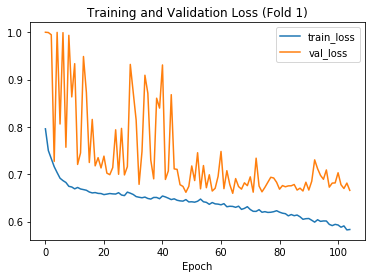

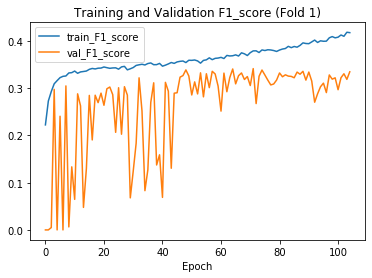

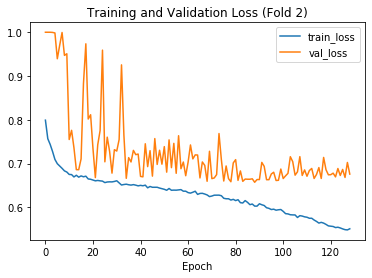

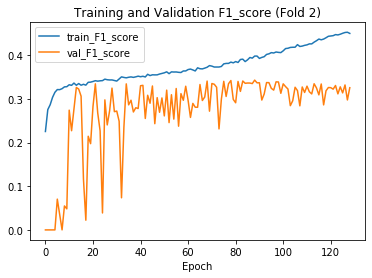

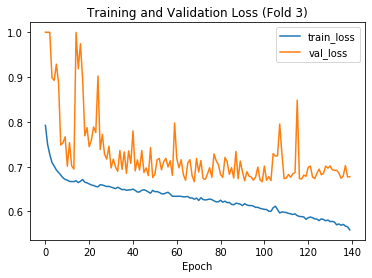

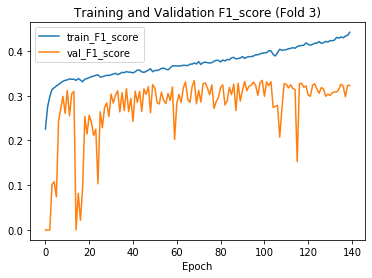

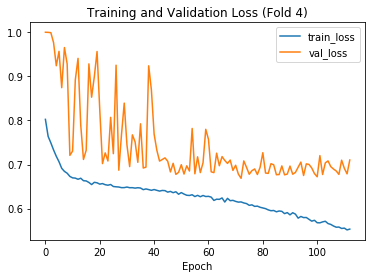

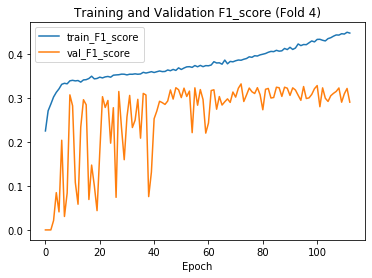

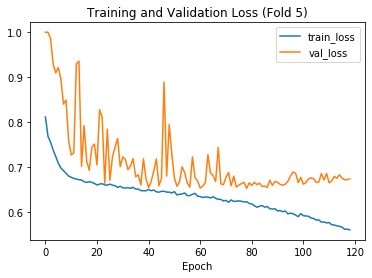

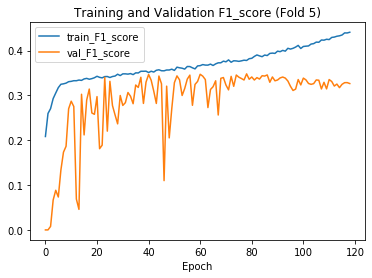

In [51]:
for fold in range(num_folds):
    train_loss = history_list[fold]['loss']
    val_loss = history_list[fold]['val_loss']
    train_F1_score = history_list[fold]['F1_score']
    val_F1_score = history_list[fold]['val_F1_score']

    plt.figure()
    plt.plot(train_loss, label='train_loss')
    plt.plot(val_loss, label='val_loss')
    plt.title('Training and Validation Loss (Fold {})'.format(fold+1))
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(train_F1_score, label='train_F1_score')
    plt.plot(val_F1_score, label='val_F1_score')
    plt.title('Training and Validation F1_score (Fold {})'.format(fold+1))
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()


In [52]:
# Make predictions with the best fold before overfitting and save images

folder_path_train = '/home/in18657@ad.umbc.edu/Laye_Detection/Prediction/test_thresh_vgg19_300'
folder_path_test = '/home/in18657@ad.umbc.edu/Laye_Detection/Prediction/test_thresh_vgg19_300'
import numpy as np
import cv2
import os
model = build_vgg19_unet(input_shape) 
model.load_weights('best_model_layer_300_thresh_128_vgg_fold_1.h5')


def save_test_prediction(predictions):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(predictions)):
        pred = (predictions[i] * 255).astype(np.uint8)
        file_name = "Predicted_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), pred)

predictions = model.predict(X_test, batch_size=1)
save_test_prediction(predictions)


def save_original_mask_test(y_test):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(y_test)):
        y_test_i = (y_test[i, :, :, 0] * 255).astype(np.uint8)
        file_name = "Mask_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), y_test_i)

save_original_mask_test(y_test)


def save_original_X_test(X_test):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(X_test)):
        X_test_i = (X_test[i] * 255).astype(np.uint8)
        file_name = "Image_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), X_test_i)

save_original_X_test(X_test)
def save_train_prediction(predictions):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(predictions)):
        pred = (predictions[i] * 255).astype(np.uint8)
        file_name = "Predicted_train_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), pred)

predictions_train = model.predict(image, batch_size=1)
save_train_prediction(predictions_train)


def save_original_mask_train(y_train):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(y_train)):
        mask_i = (y_train[i, :, :, 0] * 255).astype(np.uint8)
        file_name = "Train_mask_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), mask_i)

save_original_mask_train(mask)


def save_original_X_train(X_train):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(X_train)):
        image_i = (X_train[i] * 255).astype(np.uint8)
        file_name = "Train_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), image_i)

save_original_X_train(image)

240/240 [==============================] - 6s 23ms/step


In [53]:
# U-Net + Inception
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))
num_folds = 5
history_list = []

kf = KFold(n_splits=num_folds, shuffle=False, random_state=None)

indices = np.arange(len(image))
indices = shuffle(indices, random_state=0)
images_shuffled = image
masks_shuffled = mask
# Train and evaluate the model with k-fold cross-validation
train_loss_scores = []
train_binary_iou_scores = []
train_dice_coef_scores = []
train_f1_scores = []

val_loss_scores = []
val_binary_iou_scores = []
val_dice_coef_scores = []
val_f1_scores = []

test_f1_scores = []
test_loss_scores = []
test_binary_iou_scores = []
test_dice_coef_scores = []
test_f1_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(images_shuffled)):
    print(f'Fold {fold}')
    # Split the data into train and validation sets for this fold
    train_images, val_images = images_shuffled[train_index], images_shuffled[val_index]
    train_masks, val_masks = masks_shuffled[train_index], masks_shuffled[val_index]
    
    IMAGE_DIMS = (512,512,3)

    import tensorflow as tf
    gpus = tf.config.experimental.list_physical_devices("GPU")
    tf.config.experimental.set_visible_devices(gpus[:4], "GPU")
    
    strategy = tf.distribute.MirroredStrategy(devices=["GPU:0", "GPU:1","GPU:2", "GPU:3"])
    with strategy.scope():

        model = unet_plus_inception(IMAGE_DIMS)
        binary_iou =tf.keras.metrics.BinaryIoU(name='binary_iou', threshold=0.5)
        # Compile the model
        model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=F1_score_Loss,
        metrics=[binary_iou,dice_coef,F1_score])
    
    
    # Define the EarlyStopping and ModelCheckpoint callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=40, verbose=1,  restore_best_weights=True)

    checkpoint = ModelCheckpoint(f'best_model_layer_300_thresh_inception_fold_{fold}.h5', monitor='val_F1_score',mode='max', save_best_only=True, verbose=1)


    history = model.fit(train_images, train_masks, epochs=300, batch_size=8,
                        validation_data=(val_images, val_masks),
                        callbacks=[early_stop, checkpoint],verbose=0)


    save_model(model, f'complete_model_layer_300_thresh_inception_fold_{fold}.h5')
    history_list.append(history.history)
   
    model.load_weights(f'best_model_layer_300_thresh_inception_fold_{fold}.h5')
    # Evaluate the performance of the best model on the train, validation, and test sets
    train_scores = model.evaluate(train_images, train_masks, batch_size=8)
    val_scores = model.evaluate(val_images, val_masks, batch_size=8)
    test_scores=model.evaluate(X_test,y_test, batch_size=8)

    # Print the performance of the best model on this fold's train, validation, and test sets
    train_loss_scores.append(train_scores[0])
    train_binary_iou_scores.append(train_scores[1])
    train_dice_coef_scores.append(train_scores[2])
    train_f1_scores.append(train_scores[3])

    val_loss_scores.append(val_scores[0])
    val_binary_iou_scores.append(val_scores[1])
    val_dice_coef_scores.append(val_scores[2])
    val_f1_scores.append(val_scores[3])

    test_loss_scores.append(test_scores[0])
    test_binary_iou_scores.append(test_scores[1])
    test_dice_coef_scores.append(test_scores[2])
    test_f1_scores.append(test_scores[3])
    
    print('Fold', fold+1)
    print('Train loss:', train_scores[0])
    print('Train binary IOU:', train_scores[1])
    print('Train dice coef:', train_scores[2])
    print('Train F1:', train_scores[3])
    print('------------------------')
    print('Val loss:', val_scores[0])
    print('Val binary IOU:', val_scores[1])
    print('Val dice coef:', val_scores[2])
    print('Val F1:', val_scores[3])
    print('------------------------')
    print('test loss:', test_scores[0])
    print('test binary IOU:', test_scores[1])
    print('test_dice coef:', test_scores[2])
    print('test F1:', test_scores[3])
    print('------------------------')

# Calculate the average scores over all folds
avg_train_loss = np.mean(train_loss_scores)
avg_train_binary_iou = np.mean(train_binary_iou_scores)
avg_train_dice_coef = np.mean(train_dice_coef_scores)
avg_train_f1 = np.mean(train_f1_scores)
print('------------------------')
avg_val_loss = np.mean(val_loss_scores)
avg_val_binary_iou = np.mean(val_binary_iou_scores)
avg_val_dice_coef = np.mean(val_dice_coef_scores)
avg_val_f1 = np.mean(val_f1_scores)
print('------------------------')
avg_test_loss = np.mean(test_loss_scores)
avg_test_binary_iou = np.mean(test_binary_iou_scores)
avg_test_dice_coef = np.mean(test_dice_coef_scores)
avg_test_f1 = np.mean(test_f1_scores)

# Print the final average scores
print('Average train loss:', avg_train_loss)
print('Average train binary IoU:', avg_train_binary_iou)
print('Average train Dice coefficient:', avg_train_dice_coef)
print('------------------------')
print('Average train F1 score:', avg_train_f1)
print('Average validation loss:', avg_val_loss)
print('Average validation binary IoU:', avg_val_binary_iou)
print('Average validation Dice coefficient:', avg_val_dice_coef)
print('------------------------')
print('Average validation F1 score:', avg_val_f1)
print('Average test loss:', avg_test_loss)
print('Average test binary IoU:', avg_test_binary_iou)
print('Average test Dice coefficient:', avg_test_dice_coef)
print('Average test F1 score:', avg_test_f1)
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))

Current Time = 01:36:04
Fold 0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')

Epoch 1: val_F1_score improved from -inf to 0.16348, saving model to best_model_layer_300_thresh_inception_fold_0.h5

Epoch 2: val_F1_score improved from 0.16348 to 0.17836, saving model to best_model_layer_300_thresh_inception_fold_0.h5

Epoch 3: val_F1_score did not improve from 0.17836

Epoch 4: val_F1_score did not improve from 0.17836

Epoch 5: val_F1_score did not improve from 0.17836

Epoch 6: val_F1_score did not improve from 0.17836

Epoch 7: val_F1_score did not improve from 0.17836

Epoch 8: val_F1_score did not improve from 0.17836

Epoch 9: val_F1_score did not improve from 0.17836

Epoch 10: val_F1_score did not improve from 0.17836

Epoch 11: val_F1_score did not improve from 0.17836

Epoch 12: val_

3. Clahe + Otsu

Run experiments with Clahe + Otsu threshold.

Data is split 80/20 for the training/testing sets. A 5- fold cross-validation (5CV) strategy and early stopping are used on the training subset to ensure model generalizability and avoid overfitting. 

In [ ]:
# Data augmentation
images, masks = load_data()
print(f"Original Images: {len(images)} - Original Masks: {len(masks)}")
create_dir("/home/in18657@ad.umbc.edu/Laye_Detection/raw_clahe_otsu_aaai_aug")
create_dir("/home/in18657@ad.umbc.edu/Laye_Detection/gt_clahe_otsu_aaai_aug")
save_path="/home/in18657@ad.umbc.edu/Laye_Detection/"
augment_data(images, masks, save_path, augment=True)


In [9]:

import os
import cv2
from tqdm import tqdm
from glob import glob
from albumentations import CenterCrop, RandomRotate90, GridDistortion, HorizontalFlip, VerticalFlip
def augment_data(images, masks, save_path, augment=True):
    H = 512
    W = 512

    for x, y in tqdm(zip(images, masks), total=len(images)):
        name = x.split("/")[-1].split(".")
        image_name = name[0]
        image_extn = name[1]
        name = y.split("/")[-1].split(".")
        mask_name = name[0]
        mask_extn = name[1]
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        if augment == True:
            aug = GridDistortion(p=1.0)
            augmented = aug(image=x, mask=y)
            x3 = augmented['image']
            y3 = augmented['mask']
            aug = HorizontalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x4 = augmented['image']
            y4 = augmented['mask']
            save_images = [x,x3,x4]
            save_masks =  [y, y3,  y4]

        else:
            save_images = [x]
            save_masks = [y]
        idx = 0
        for i, m in zip(save_images, save_masks):
            i = cv2.resize(i, (W, H))
            m = cv2.resize(m, (W, H))

            if len(images) == 1:
                tmp_img_name = f"{image_name}.{image_extn}"
                tmp_mask_name = f"{mask_name}.{mask_extn}"
            else:
                tmp_img_name = f"{image_name}_{idx}.{image_extn}"
                tmp_mask_name = f"{mask_name}_{idx}.{mask_extn}"

            image_path = os.path.join(save_path, "raw_clahe_otsu_aaai_aug", tmp_img_name)
            mask_path = os.path.join(save_path, "gt_clahe_otsu_aaai_aug", tmp_mask_name)

            cv2.imwrite(image_path, i)
            print(save_path)
            print(image_path)
            cv2.imwrite(mask_path, m)

            idx += 1


def load_data():"
    input_dir = "/home/in18657@ad.umbc.edu/Laye_Detection/raw"   
    target_dir = "/home/in18657@ad.umbc.edu/Laye_Detection/gt_clahe_otsu_thresh_binary"

    images = sorted(
        [
            os.path.join(input_dir, fname)
            for fname in os.listdir(input_dir)
            if fname.endswith(".png")
        ]
    )
    masks = sorted(
        [
            os.path.join(target_dir, fname)
            for fname in os.listdir(target_dir)
            if fname.endswith(".png") and not fname.startswith(".")
        ]
    )
    return images, masks
    
def create_dir(path):

    if not os.path.exists(path):
        print("not")
        os.makedirs(path)   

from PIL import Image
import numpy as np

In [8]:
import cv2
import numpy as np
from skimage.transform import resize

def create_image_mask_new(input_img_paths, target_img_paths, mask_IMAGE_DIMS, image_IMAGE_DIMS):
    images = []
    masks = []
   
    for (ii, (im_path, mask_path)) in enumerate(zip(input_img_paths,target_img_paths)):
        image = cv2.imread(im_path)
        image = resize(image, image_IMAGE_DIMS, mode='constant', preserve_range=True)
        image = image / 255
        images.append(image)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = resize(mask, mask_IMAGE_DIMS, mode='constant', preserve_range=True)

        # Apply the code snippet to convert the grayscale mask to binary (0 and 1)
        mask = np.where(mask>= 128, 1, 0)
        mask = mask.astype(np.float32)
        
        masks.append(mask)

    images = np.array(images)
    masks = np.array(masks)
    return images, masks


In [29]:
input_dir = "/home/in18657@ad.umbc.edu/Laye_Detection/raw_clahe_otsu_aaai_aug"   
target_dir = "/home/in18657@ad.umbc.edu/Laye_Detection/gt_clahe_otsu_aaai_aug"

image_IMAGE_DIMS=(512,512,3) 
mask_IMAGE_DIMS=(512,512,1) 
input_img_paths,target_img_paths=read_files(input_dir,target_dir)
images,masks=create_image_mask_new(input_img_paths,target_img_paths,mask_IMAGE_DIMS,image_IMAGE_DIMS)
from sklearn.model_selection import train_test_split
image, X_test, mask, y_test= train_test_split(images, masks, test_size=0.2, random_state=0)

Number of samples: 900
Number of samples: 900
/home/in18657@ad.umbc.edu/Laye_Detection/raw_clahe_otsu_aaai_aug/Data_20110329_01_010_0.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt_clahe_otsu_aaai_aug/Data_20110329_01_010_0.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw_clahe_otsu_aaai_aug/Data_20110329_01_010_1.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt_clahe_otsu_aaai_aug/Data_20110329_01_010_1.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw_clahe_otsu_aaai_aug/Data_20110329_01_010_2.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt_clahe_otsu_aaai_aug/Data_20110329_01_010_2.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw_clahe_otsu_aaai_aug/Data_20110329_01_011_0.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt_clahe_otsu_aaai_aug/Data_20110329_01_011_0.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw_clahe_otsu_aaai_aug/Data_20110329_01_011_1.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt_clahe_otsu_aaai_aug/Data_20110329_01_011_1.png
/home/in18657@ad.umbc.edu/Lay

In [30]:

# Attention U-Net
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))
num_folds = 5
history_list = []
kf = KFold(n_splits=num_folds, shuffle=False, random_state=None)
indices = np.arange(len(image))
indices = shuffle(indices, random_state=0)
images_shuffled = image
masks_shuffled = mask
# Train and evaluate the model with k-fold cross-validation
train_loss_scores = []
train_binary_iou_scores = []
train_dice_coef_scores = []
train_f1_scores = []

val_loss_scores = []
val_binary_iou_scores = []
val_dice_coef_scores = []
val_f1_scores = []

test_f1_scores = []
test_loss_scores = []
test_binary_iou_scores = []
test_dice_coef_scores = []
test_f1_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(images_shuffled)):
    print(f'Fold {fold}')
    # Split the data into train and validation sets for this fold
    train_images, val_images = images_shuffled[train_index], images_shuffled[val_index]
    train_masks, val_masks = masks_shuffled[train_index], masks_shuffled[val_index]
    
    IMAGE_DIMS = (512,512,3)

    with strategy.scope():
        input_shape=(512,512,3)
        model = Attention_UNet(input_shape)

        binary_iou =tf.keras.metrics.BinaryIoU(name='binary_iou', threshold=0.5)
        # Compile the model
        model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=F1_score_Loss,
        metrics=[binary_iou,dice_coef,F1_score])
    
    
    # Define the EarlyStopping and ModelCheckpoint callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=40, verbose=1,  restore_best_weights=True)

    checkpoint = ModelCheckpoint(f'best_model_layer_300_attention_clahe_otsu_aaai_aug_fold_{fold}.h5', monitor='val_F1_score',mode='max', save_best_only=True, verbose=1)

    history = model.fit(train_images, train_masks, epochs=300, batch_size=8,
                        validation_data=(val_images, val_masks),
                        callbacks=[early_stop, checkpoint],verbose=0)

    save_model(model, f'complete_best_model_layer_300_attention_clahe_otsu_aaai_aug_fold_{fold}.h5')
    history_list.append(history.history)
   
    model.load_weights(f'best_model_layer_300_attention_clahe_otsu_aaai_aug_fold_{fold}.h5')
    # Evaluate the performance of the best model on the train, validation, and test sets
    train_scores = model.evaluate(train_images, train_masks, batch_size=8)
    val_scores = model.evaluate(val_images, val_masks, batch_size=8)
    test_scores=model.evaluate(X_test,y_test, batch_size=8)

    # Print the performance of the best model on this fold's train, validation, and test sets
    train_loss_scores.append(train_scores[0])
    train_binary_iou_scores.append(train_scores[1])
    train_dice_coef_scores.append(train_scores[2])
    train_f1_scores.append(train_scores[3])

    val_loss_scores.append(val_scores[0])
    val_binary_iou_scores.append(val_scores[1])
    val_dice_coef_scores.append(val_scores[2])
    val_f1_scores.append(val_scores[3])

    test_loss_scores.append(test_scores[0])
    test_binary_iou_scores.append(test_scores[1])
    test_dice_coef_scores.append(test_scores[2])
    test_f1_scores.append(test_scores[3])
    
    print('Fold', fold+1)
    print('Train loss:', train_scores[0])
    print('Train binary IOU:', train_scores[1])
    print('Train dice coef:', train_scores[2])
    print('Train F1:', train_scores[3])
    print('------------------------')
    print('Val loss:', val_scores[0])
    print('Val binary IOU:', val_scores[1])
    print('Val dice coef:', val_scores[2])
    print('Val F1:', val_scores[3])
    print('------------------------')
    print('test loss:', test_scores[0])
    print('test binary IOU:', test_scores[1])
    print('test_dice coef:', test_scores[2])
    print('test F1:', test_scores[3])
    print('------------------------')

# Calculate the average scores over all folds
avg_train_loss = np.mean(train_loss_scores)
avg_train_binary_iou = np.mean(train_binary_iou_scores)
avg_train_dice_coef = np.mean(train_dice_coef_scores)
avg_train_f1 = np.mean(train_f1_scores)
print('------------------------')
avg_val_loss = np.mean(val_loss_scores)
avg_val_binary_iou = np.mean(val_binary_iou_scores)
avg_val_dice_coef = np.mean(val_dice_coef_scores)
avg_val_f1 = np.mean(val_f1_scores)
print('------------------------')
avg_test_loss = np.mean(test_loss_scores)
avg_test_binary_iou = np.mean(test_binary_iou_scores)
avg_test_dice_coef = np.mean(test_dice_coef_scores)
avg_test_f1 = np.mean(test_f1_scores)

# Print the final average scores
print('Average train loss:', avg_train_loss)
print('Average train binary IoU:', avg_train_binary_iou)
print('Average train Dice coefficient:', avg_train_dice_coef)

print('Average train F1 score:', avg_train_f1)
print('------------------------')
print('Average validation loss:', avg_val_loss)
print('Average validation binary IoU:', avg_val_binary_iou)
print('Average validation Dice coefficient:', avg_val_dice_coef)

print('Average validation F1 score:', avg_val_f1)
print('------------------------')
print('Average test loss:', avg_test_loss)
print('Average test binary IoU:', avg_test_binary_iou)
print('Average test Dice coefficient:', avg_test_dice_coef)
print('Average test F1 score:', avg_test_f1)
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))

Current Time = 11:10:33
Fold 0

Epoch 1: val_F1_score improved from -inf to 0.20294, saving model to best_model_layer_300_attention_clahe_otsu_aaai_aug_fold_0.h5

Epoch 2: val_F1_score did not improve from 0.20294

Epoch 3: val_F1_score did not improve from 0.20294

Epoch 4: val_F1_score did not improve from 0.20294

Epoch 5: val_F1_score did not improve from 0.20294

Epoch 6: val_F1_score improved from 0.20294 to 0.21190, saving model to best_model_layer_300_attention_clahe_otsu_aaai_aug_fold_0.h5

Epoch 7: val_F1_score improved from 0.21190 to 0.25415, saving model to best_model_layer_300_attention_clahe_otsu_aaai_aug_fold_0.h5

Epoch 8: val_F1_score improved from 0.25415 to 0.30933, saving model to best_model_layer_300_attention_clahe_otsu_aaai_aug_fold_0.h5

Epoch 9: val_F1_score did not improve from 0.30933

Epoch 10: val_F1_score did not improve from 0.30933

Epoch 11: val_F1_score improved from 0.30933 to 0.32192, saving model to best_model_layer_300_attention_clahe_otsu_aaai_au

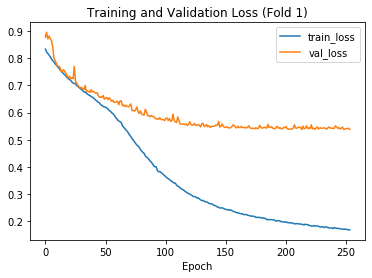

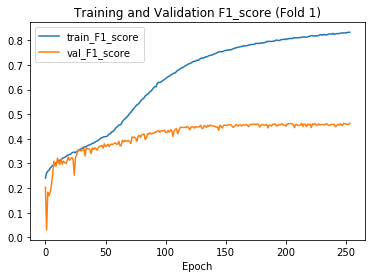

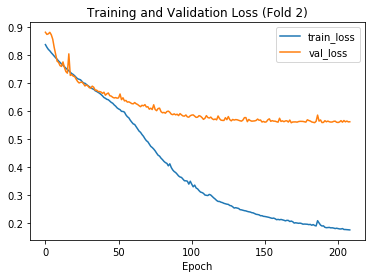

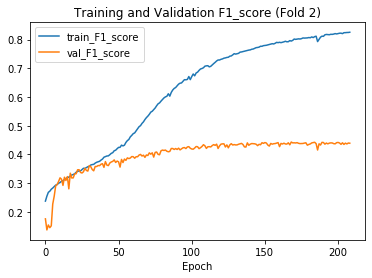

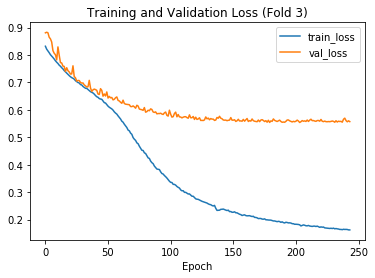

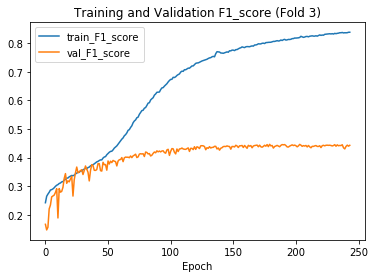

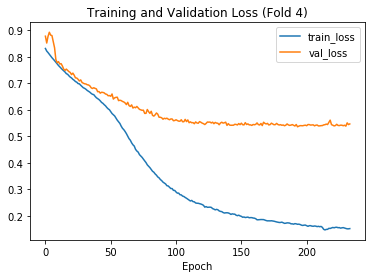

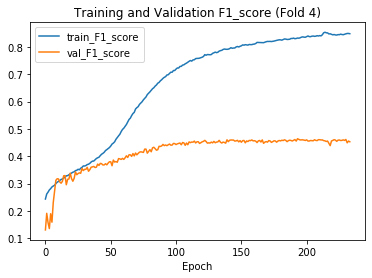

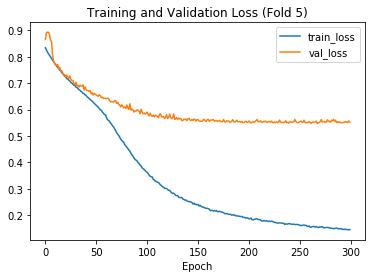

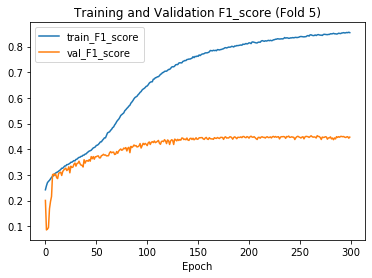

In [31]:
for fold in range(num_folds):
    train_loss = history_list[fold]['loss']
    val_loss = history_list[fold]['val_loss']
    train_F1_score = history_list[fold]['F1_score']
    val_F1_score = history_list[fold]['val_F1_score']
    plt.figure()
    plt.plot(train_loss, label='train_loss')
    plt.plot(val_loss, label='val_loss')
    plt.title('Training and Validation Loss (Fold {})'.format(fold+1))
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(train_F1_score, label='train_F1_score')
    plt.plot(val_F1_score, label='val_F1_score')
    plt.title('Training and Validation F1_score (Fold {})'.format(fold+1))
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [33]:
# Make predictions with the best fold before overfitting and save images.
folder_path_train = '/home/in18657@ad.umbc.edu/Laye_Detection/Prediction/train_clahe_otsu_aaai_aug_attention'
folder_path_test = '/home/in18657@ad.umbc.edu/Laye_Detection/Prediction/test_clahe_otsu_aaai_aug_attention'
import numpy as np
import cv2
import os
model = Attention_UNet(input_shape)
model.load_weights('best_model_layer_300_attention_clahe_otsu_aaai_aug_fold_4.h5')

def save_test_prediction(predictions):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(predictions)):
        pred = (predictions[i] * 255).astype(np.uint8)
        file_name = "Predicted_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), pred)

predictions = model.predict(X_test, batch_size=1)
save_test_prediction(predictions)


def save_original_mask_test(y_test):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(y_test)):
        y_test_i = (y_test[i, :, :, 0] * 255).astype(np.uint8)
        file_name = "Mask_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), y_test_i)

save_original_mask_test(y_test)


def save_original_X_test(X_test):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(X_test)):
        X_test_i = (X_test[i] * 255).astype(np.uint8)
        file_name = "Image_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), X_test_i)

save_original_X_test(X_test)
def save_train_prediction(predictions):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(predictions)):
        pred = (predictions[i] * 255).astype(np.uint8)
        file_name = "Predicted_train_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), pred)

predictions_train = model.predict(image, batch_size=1)
save_train_prediction(predictions_train)


def save_original_mask_train(y_train):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(y_train)):
        mask_i = (y_train[i, :, :, 0] * 255).astype(np.uint8)
        file_name = "Train_mask_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), mask_i)

save_original_mask_train(mask)


def save_original_X_train(X_train):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(X_train)):
        image_i = (X_train[i] * 255).astype(np.uint8)
        file_name = "Train_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), image_i)

save_original_X_train(image)

720/720 [==============================] - 21s 29ms/step


In [14]:
# U-Net
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))

num_folds = 5
history_list = []

kf = KFold(n_splits=num_folds, shuffle=False, random_state=None)


indices = np.arange(len(image))
indices = shuffle(indices, random_state=0)
images_shuffled = image
masks_shuffled = mask
# Train and evaluate the model with k-fold cross-validation
train_loss_scores = []
train_binary_iou_scores = []
train_dice_coef_scores = []
train_f1_scores = []

val_loss_scores = []
val_binary_iou_scores = []
val_dice_coef_scores = []
val_f1_scores = []

test_f1_scores = []
test_loss_scores = []
test_binary_iou_scores = []
test_dice_coef_scores = []
test_f1_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(images_shuffled)):
    print(f'Fold {fold}')
    # Split the data into train and validation sets for this fold
    train_images, val_images = images_shuffled[train_index], images_shuffled[val_index]
    train_masks, val_masks = masks_shuffled[train_index], masks_shuffled[val_index]
    
    IMAGE_DIMS = (512,512,3)

    with strategy.scope():

        model = Unet(IMAGE_DIMS, n_filters=16,  dropout=0.5, batchnorm=True, regularization=None, kernel_initializer="he_normal")

        binary_iou =tf.keras.metrics.BinaryIoU(name='binary_iou', threshold=0.5)
        # Compile the model
        model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=F1_score_Loss,
        metrics=[binary_iou,dice_coef,F1_score])
    
    
    # Define the EarlyStopping and ModelCheckpoint callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=40, verbose=1,  restore_best_weights=True)

    checkpoint = ModelCheckpoint(f'best_model_layer_300_UNet_clahe_otsu_aaai_aug_fold_{fold}.h5', monitor='val_F1_score',mode='max', save_best_only=True, verbose=1)


    history = model.fit(train_images, train_masks, epochs=300, batch_size=8,
                        validation_data=(val_images, val_masks),
                        callbacks=[early_stop, checkpoint],verbose=0)


    save_model(model, f'complete_best_model_layer_300_UNet_clahe_otsu_aaai_aug_fold_{fold}.h5')
    history_list.append(history.history)
   
    model.load_weights(f'best_model_layer_300_UNet_clahe_otsu_aaai_aug_fold_{fold}.h5')
    # Evaluate the performance of the best model on the train, validation, and test sets
    train_scores = model.evaluate(train_images, train_masks, batch_size=8)
    val_scores = model.evaluate(val_images, val_masks, batch_size=8)
    test_scores=model.evaluate(X_test,y_test, batch_size=8)

    # Print the performance of the best model on this fold's train, validation, and test sets
    train_loss_scores.append(train_scores[0])
    train_binary_iou_scores.append(train_scores[1])
    train_dice_coef_scores.append(train_scores[2])
    train_f1_scores.append(train_scores[3])

    val_loss_scores.append(val_scores[0])
    val_binary_iou_scores.append(val_scores[1])
    val_dice_coef_scores.append(val_scores[2])
    val_f1_scores.append(val_scores[3])

    test_loss_scores.append(test_scores[0])
    test_binary_iou_scores.append(test_scores[1])
    test_dice_coef_scores.append(test_scores[2])
    test_f1_scores.append(test_scores[3])

    print('Fold', fold+1)
    print('Train loss:', train_scores[0])
    print('Train binary IOU:', train_scores[1])
    print('Train dice coef:', train_scores[2])
    print('Train F1:', train_scores[3])
    print('------------------------')
    print('Val loss:', val_scores[0])
    print('Val binary IOU:', val_scores[1])
    print('Val dice coef:', val_scores[2])
    print('Val F1:', val_scores[3])
    print('------------------------')
    print('test loss:', test_scores[0])
    print('test binary IOU:', test_scores[1])
    print('test_dice coef:', test_scores[2])
    print('test F1:', test_scores[3])
    print('------------------------')

# Calculate the average scores over all folds
avg_train_loss = np.mean(train_loss_scores)
avg_train_binary_iou = np.mean(train_binary_iou_scores)
avg_train_dice_coef = np.mean(train_dice_coef_scores)
avg_train_f1 = np.mean(train_f1_scores)
print('------------------------')
avg_val_loss = np.mean(val_loss_scores)
avg_val_binary_iou = np.mean(val_binary_iou_scores)
avg_val_dice_coef = np.mean(val_dice_coef_scores)
avg_val_f1 = np.mean(val_f1_scores)
print('------------------------')
avg_test_loss = np.mean(test_loss_scores)
avg_test_binary_iou = np.mean(test_binary_iou_scores)
avg_test_dice_coef = np.mean(test_dice_coef_scores)
avg_test_f1 = np.mean(test_f1_scores)

# Print the final average scores
print('Average train loss:', avg_train_loss)
print('Average train binary IoU:', avg_train_binary_iou)
print('Average train Dice coefficient:', avg_train_dice_coef)

print('Average train F1 score:', avg_train_f1)
print('------------------------')
print('Average validation loss:', avg_val_loss)
print('Average validation binary IoU:', avg_val_binary_iou)
print('Average validation Dice coefficient:', avg_val_dice_coef)

print('Average validation F1 score:', avg_val_f1)
print('------------------------')
print('Average test loss:', avg_test_loss)
print('Average test binary IoU:', avg_test_binary_iou)
print('Average test Dice coefficient:', avg_test_dice_coef)
print('Average test F1 score:', avg_test_f1)
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))

Current Time = 13:25:09
Fold 0

Epoch 1: val_F1_score improved from -inf to 0.25200, saving model to best_model_layer_300_UNet_clahe_otsu_aaai_aug_fold_0.h5

Epoch 2: val_F1_score did not improve from 0.25200

Epoch 3: val_F1_score did not improve from 0.25200

Epoch 4: val_F1_score did not improve from 0.25200

Epoch 5: val_F1_score improved from 0.25200 to 0.28151, saving model to best_model_layer_300_UNet_clahe_otsu_aaai_aug_fold_0.h5

Epoch 6: val_F1_score improved from 0.28151 to 0.32648, saving model to best_model_layer_300_UNet_clahe_otsu_aaai_aug_fold_0.h5

Epoch 7: val_F1_score improved from 0.32648 to 0.33706, saving model to best_model_layer_300_UNet_clahe_otsu_aaai_aug_fold_0.h5

Epoch 8: val_F1_score improved from 0.33706 to 0.34213, saving model to best_model_layer_300_UNet_clahe_otsu_aaai_aug_fold_0.h5

Epoch 9: val_F1_score improved from 0.34213 to 0.34623, saving model to best_model_layer_300_UNet_clahe_otsu_aaai_aug_fold_0.h5

Epoch 10: val_F1_score improved from 0.34

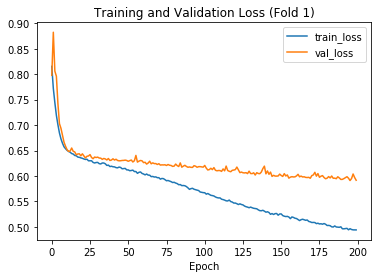

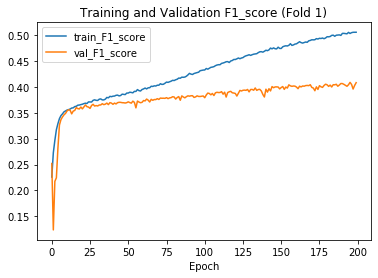

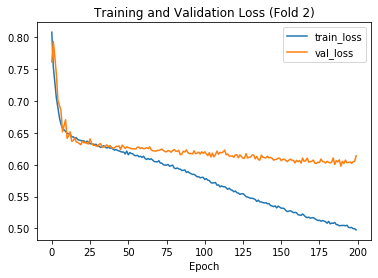

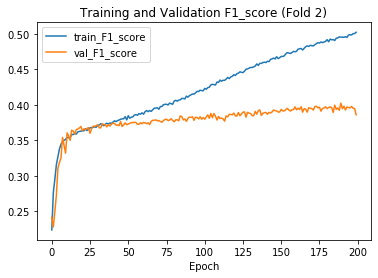

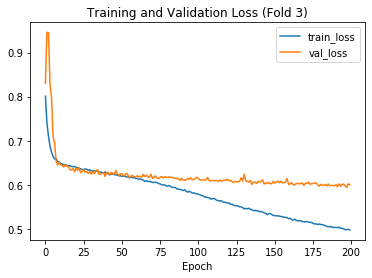

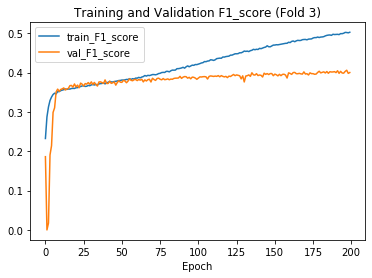

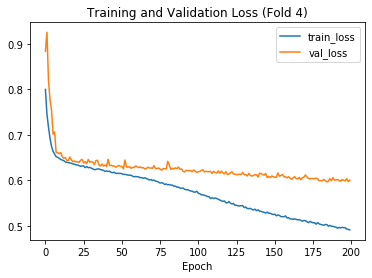

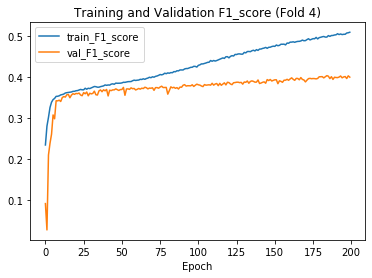

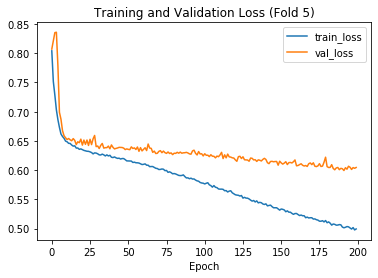

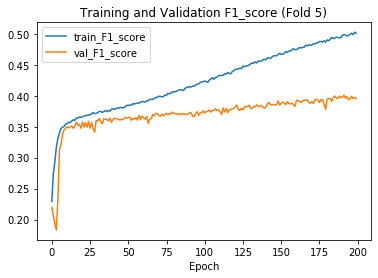

In [15]:
for fold in range(num_folds):
    train_loss = history_list[fold]['loss']
    val_loss = history_list[fold]['val_loss']
    train_F1_score = history_list[fold]['F1_score']
    val_F1_score = history_list[fold]['val_F1_score']
    plt.figure()
    plt.plot(train_loss, label='train_loss')
    plt.plot(val_loss, label='val_loss')
    plt.title('Training and Validation Loss (Fold {})'.format(fold+1))
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(train_F1_score, label='train_F1_score')
    plt.plot(val_F1_score, label='val_F1_score')
    plt.title('Training and Validation F1_score (Fold {})'.format(fold+1))
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [16]:
# Make predictions with the best fold before overfitting and save images.
folder_path_train = '/home/in18657@ad.umbc.edu/Laye_Detection/Prediction/train_clahe_otsu_aaai_aug_UNet'
folder_path_test = '/home/in18657@ad.umbc.edu/Laye_Detection/Prediction/test_clahe_otsu_aaai_aug_UNet'
import numpy as np
import cv2
import os
model = Unet(IMAGE_DIMS, n_filters=16, dropout=0.5, batchnorm=True, regularization=None, kernel_initializer="he_normal")
model.load_weights('best_model_layer_300_UNet_clahe_otsu_aaai_aug_fold_0.h5')


def save_test_prediction(predictions):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(predictions)):
        pred = (predictions[i] * 255).astype(np.uint8)
        file_name = "Predicted_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), pred)

predictions = model.predict(X_test, batch_size=1)
save_test_prediction(predictions)


def save_original_mask_test(y_test):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(y_test)):
        y_test_i = (y_test[i, :, :, 0] * 255).astype(np.uint8)
        file_name = "Mask_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), y_test_i)

save_original_mask_test(y_test)


def save_original_X_test(X_test):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(X_test)):
        X_test_i = (X_test[i] * 255).astype(np.uint8)"
        file_name = "Image_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), X_test_i)

save_original_X_test(X_test)
def save_train_prediction(predictions):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(predictions)):
        pred = (predictions[i] * 255).astype(np.uint8) "/"
        file_name = "Predicted_train_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), pred)

predictions_train = model.predict(image, batch_size=1)
save_train_prediction(predictions_train)


def save_original_mask_train(y_train):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(y_train)):
        mask_i = (y_train[i, :, :, 0] * 255).astype(np.uint8)
        file_name = "Train_mask_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), mask_i)

save_original_mask_train(mask)


def save_original_X_train(X_train):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(X_train)):
        image_i = (X_train[i] * 255).astype(np.uint8)
        file_name = "Train_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), image_i)

save_original_X_train(image)

720/720 [==============================] - 6s 9ms/step


In [18]:
# VGG19 + U-Net
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))

num_folds = 5
history_list = []

kf = KFold(n_splits=num_folds, shuffle=False, random_state=None)


indices = np.arange(len(image))
indices = shuffle(indices, random_state=0)
images_shuffled = image
masks_shuffled = mask


# Train and evaluate the model with k-fold cross-validation
train_loss_scores = []
train_binary_iou_scores = []
train_dice_coef_scores = []
train_f1_scores = []

val_loss_scores = []
val_binary_iou_scores = []
val_dice_coef_scores = []
val_f1_scores = []

test_f1_scores = []
test_loss_scores = []
test_binary_iou_scores = []
test_dice_coef_scores = []
test_f1_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(images_shuffled)):
    print(f'Fold {fold}')
    # Split the data into train and validation sets for this fold
    train_images, val_images = images_shuffled[train_index], images_shuffled[val_index]
    train_masks, val_masks = masks_shuffled[train_index], masks_shuffled[val_index]
    
    IMAGE_DIMS = (512,512,3)
    
   

    with strategy.scope():
        input_shape= (512,512,3)
    
        model = build_vgg19_unet(input_shape)

        binary_iou =tf.keras.metrics.BinaryIoU(name='binary_iou', threshold=0.5)
        # Compile the model
        model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=F1_score_Loss,
        metrics=[binary_iou,dice_coef,F1_score])
    
    
    # Define the EarlyStopping and ModelCheckpoint callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=40, verbose=1,  restore_best_weights=True)

    checkpoint = ModelCheckpoint(f'best_model_layer_300_vgg_clahe_otsu_aaai_aug_fold_{fold}.h5', monitor='val_F1_score',mode='max', save_best_only=True, verbose=1)


    history = model.fit(train_images, train_masks, epochs=300, batch_size=8,
                        validation_data=(val_images, val_masks),
                        callbacks=[early_stop, checkpoint],verbose=0)

    save_model(model, f'complete_best_model_layer_300_vgg_clahe_otsu_aaai_aug_fold_{fold}.h5')
    history_list.append(history.history)
   
    model.load_weights(f'best_model_layer_300_vgg_clahe_otsu_aaai_aug_fold_{fold}.h5')
    # Evaluate the performance of the best model on the train, validation, and test sets
    train_scores = model.evaluate(train_images, train_masks, batch_size=8)
    val_scores = model.evaluate(val_images, val_masks, batch_size=8)
    test_scores=model.evaluate(X_test,y_test, batch_size=8)

    # Print the performance of the best model on this fold's train, validation, and test sets
    train_loss_scores.append(train_scores[0])
    train_binary_iou_scores.append(train_scores[1])
    train_dice_coef_scores.append(train_scores[2])
    train_f1_scores.append(train_scores[3])

    val_loss_scores.append(val_scores[0])
    val_binary_iou_scores.append(val_scores[1])
    val_dice_coef_scores.append(val_scores[2])
    val_f1_scores.append(val_scores[3])

    test_loss_scores.append(test_scores[0])
    test_binary_iou_scores.append(test_scores[1])
    test_dice_coef_scores.append(test_scores[2])
    test_f1_scores.append(test_scores[3])


    print('Fold', fold+1)
    print('Train loss:', train_scores[0])
    print('Train binary IOU:', train_scores[1])
    print('Train dice coef:', train_scores[2])
    print('Train F1:', train_scores[3])
    print('------------------------')
    print('Val loss:', val_scores[0])
    print('Val binary IOU:', val_scores[1])
    print('Val dice coef:', val_scores[2])
    print('Val F1:', val_scores[3])
    print('------------------------')
    print('test loss:', test_scores[0])
    print('test binary IOU:', test_scores[1])
    print('test_dice coef:', test_scores[2])
    print('test F1:', test_scores[3])
    print('------------------------')

# Calculate the average scores over all folds
avg_train_loss = np.mean(train_loss_scores)
avg_train_binary_iou = np.mean(train_binary_iou_scores)
avg_train_dice_coef = np.mean(train_dice_coef_scores)
avg_train_f1 = np.mean(train_f1_scores)
print('------------------------')
avg_val_loss = np.mean(val_loss_scores)
avg_val_binary_iou = np.mean(val_binary_iou_scores)
avg_val_dice_coef = np.mean(val_dice_coef_scores)
avg_val_f1 = np.mean(val_f1_scores)
print('------------------------')
avg_test_loss = np.mean(test_loss_scores)
avg_test_binary_iou = np.mean(test_binary_iou_scores)
avg_test_dice_coef = np.mean(test_dice_coef_scores)
avg_test_f1 = np.mean(test_f1_scores)

# Print the final average scores
print('Average train loss:', avg_train_loss)
print('Average train binary IoU:', avg_train_binary_iou)
print('Average train Dice coefficient:', avg_train_dice_coef)

print('Average train F1 score:', avg_train_f1)
print('------------------------')
print('Average validation loss:', avg_val_loss)
print('Average validation binary IoU:', avg_val_binary_iou)
print('Average validation Dice coefficient:', avg_val_dice_coef)

print('Average validation F1 score:', avg_val_f1)
print('------------------------')
print('Average test loss:', avg_test_loss)
print('Average test binary IoU:', avg_test_binary_iou)
print('Average test Dice coefficient:', avg_test_dice_coef)
print('Average test F1 score:', avg_test_f1)
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))

Current Time = 18:40:10
Fold 0



Epoch 1: val_F1_score improved from -inf to 0.00411, saving model to best_model_layer_300_vgg_clahe_otsu_aaai_aug_fold_0.h5

Epoch 2: val_F1_score improved from 0.00411 to 0.07568, saving model to best_model_layer_300_vgg_clahe_otsu_aaai_aug_fold_0.h5

Epoch 3: val_F1_score did not improve from 0.07568

Epoch 4: val_F1_score did not improve from 0.07568

Epoch 5: val_F1_score improved from 0.07568 to 0.17210, saving model to best_model_layer_300_vgg_clahe_otsu_aaai_aug_fold_0.h5

Epoch 6: val_F1_score improved from 0.17210 to 0.21577, saving model to best_model_layer_300_vgg_clahe_otsu_aaai_aug_fold_0.h5

Epoch 7: val_F1_score improved from 0.21577 to 0.26898, saving model to best_model_layer_300_vgg_clahe_otsu_aaai_aug_fold_0.h5

Epoch 8: val_F1_score improved from 0.26898 to 0.33194, saving model to best_model_layer_300_vgg_clahe_otsu_aaai_aug_fold_0.h5

Epoch 9: val_F1_score did not improve from 0.33194

Epoch 10: val_F1_score did not improve from 0.33194

Epoch 11: val_F1_score di

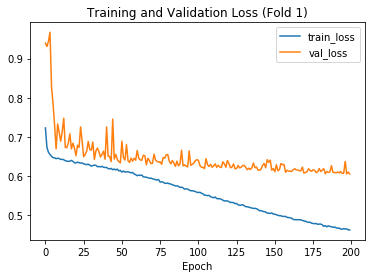

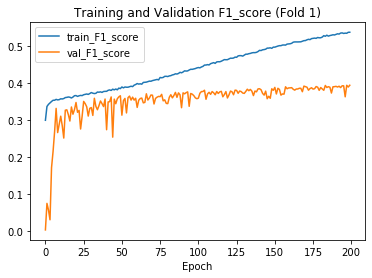

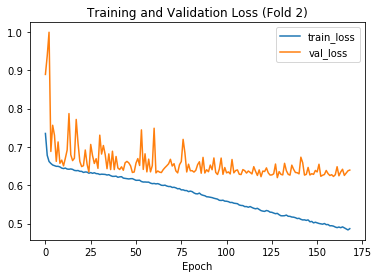

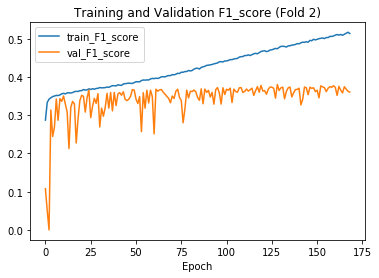

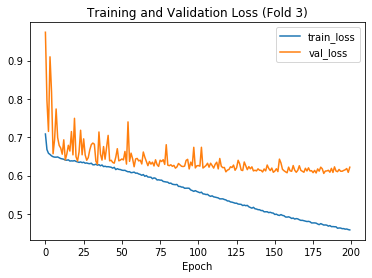

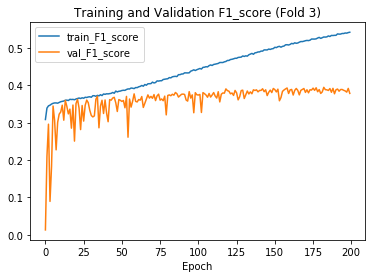

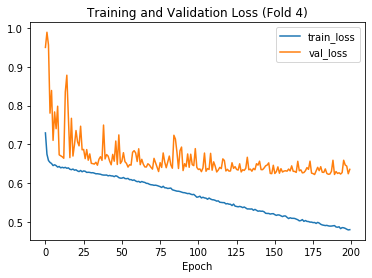

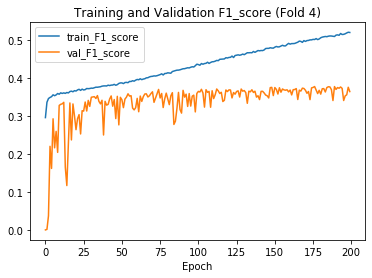

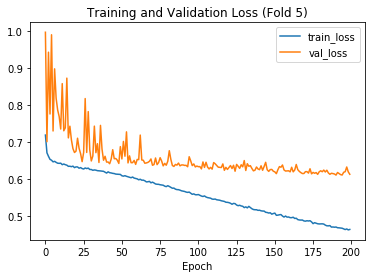

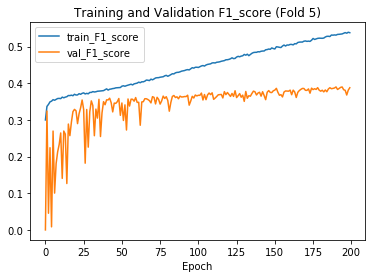

In [19]:

for fold in range(num_folds):
    train_loss = history_list[fold]['loss']
    val_loss = history_list[fold]['val_loss']
    train_F1_score = history_list[fold]['F1_score']
    val_F1_score = history_list[fold]['val_F1_score']

    plt.figure()
    plt.plot(train_loss, label='train_loss')
    plt.plot(val_loss, label='val_loss')
    plt.title('Training and Validation Loss (Fold {})'.format(fold+1))
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(train_F1_score, label='train_F1_score')
    plt.plot(val_F1_score, label='val_F1_score')
    plt.title('Training and Validation F1_score (Fold {})'.format(fold+1))
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [23]:
# Make predictions with the best fold before overfitting and save images.
folder_path_train = '/home/in18657@ad.umbc.edu/Laye_Detection/Prediction/train_clahe_otsu_aaai_aug_vgg'
folder_path_test = '/home/in18657@ad.umbc.edu/Laye_Detection/Prediction/test_clahe_otsu_aaai_aug_vgg'
import numpy as np
import cv2
import os
model = build_vgg19_unet(input_shape) 
model.load_weights('best_model_layer_300_vgg_clahe_otsu_aaai_aug_fold_3.h5')
def save_test_prediction(predictions):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(predictions)):
        pred = (predictions[i] * 255).astype(np.uint8)
        file_name = "Predicted_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), pred)

predictions = model.predict(X_test, batch_size=1)
save_test_prediction(predictions)


def save_original_mask_test(y_test):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(y_test)):
        y_test_i = (y_test[i, :, :, 0] * 255).astype(np.uint8)
        file_name = "Mask_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), y_test_i)

save_original_mask_test(y_test)


def save_original_X_test(X_test):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(X_test)):
        X_test_i = (X_test[i] * 255).astype(np.uint8)
        file_name = "Image_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), X_test_i)

save_original_X_test(X_test)
def save_train_prediction(predictions):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(predictions)):
        pred = (predictions[i] * 255).astype(np.uint8)
        file_name = "Predicted_train_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), pred)

predictions_train = model.predict(image, batch_size=1)
save_train_prediction(predictions_train)


def save_original_mask_train(y_train):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(y_train)):
        mask_i = (y_train[i, :, :, 0] * 255).astype(np.uint8)
        file_name = "Train_mask_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), mask_i)

save_original_mask_train(mask)


def save_original_X_train(X_train):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(X_train)):
        image_i = (X_train[i] * 255).astype(np.uint8)
        file_name = "Train_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), image_i)

save_original_X_train(image)

720/720 [==============================] - 17s 23ms/step


In [12]:

# Inception UNet
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))

num_folds = 5
history_list = []

kf = KFold(n_splits=num_folds, shuffle=False, random_state=None)
indices = np.arange(len(image))
indices = shuffle(indices, random_state=0)
images_shuffled = image
masks_shuffled = mask


# Train and evaluate the model with k-fold cross-validation
train_loss_scores = []
train_binary_iou_scores = []
train_dice_coef_scores = []
train_f1_scores = []

val_loss_scores = []
val_binary_iou_scores = []
val_dice_coef_scores = []
val_f1_scores = []

test_f1_scores = []
test_loss_scores = []
test_binary_iou_scores = []
test_dice_coef_scores = []
test_f1_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(images_shuffled)):
    print(f'Fold {fold}')
    # Split the data into train and validation sets for this fold
    train_images, val_images = images_shuffled[train_index], images_shuffled[val_index]
    train_masks, val_masks = masks_shuffled[train_index], masks_shuffled[val_index]
    with strategy.scope():
        input_shape= (512,512,3)
    
        model = unet_plus_inception(IMAGE_DIMS)

        binary_iou =tf.keras.metrics.BinaryIoU(name='binary_iou', threshold=0.5)
        # Compile the model
        model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=F1_score_Loss,
        metrics=[binary_iou,dice_coef,F1_score])
    
    
    # Define the EarlyStopping and ModelCheckpoint callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1,  restore_best_weights=True)

    checkpoint = ModelCheckpoint(f'best_model_layer_300_inception_clahe_otsu_aaai_aug_fold_{fold}.h5', monitor='val_F1_score',mode='max', save_best_only=True, verbose=1)


    history = model.fit(train_images, train_masks, epochs=300, batch_size=8,
                        validation_data=(val_images, val_masks),
                        callbacks=[early_stop, checkpoint],verbose=0)

    save_model(model, f'complete_best_model_layer_300_inception_clahe_otsu_aaai_aug_fold_{fold}.h5')
    history_list.append(history.history)
   
    model.load_weights(f'best_model_layer_300_inception_clahe_otsu_aaai_aug_fold_{fold}.h5')
    # Evaluate the performance of the best model on the train, validation, and test sets
    train_scores = model.evaluate(train_images, train_masks, batch_size=8)
    val_scores = model.evaluate(val_images, val_masks, batch_size=8)
    test_scores=model.evaluate(X_test,y_test, batch_size=8)

    # Print the performance of the best model on this fold's train, validation, and test sets
    train_loss_scores.append(train_scores[0])
    train_binary_iou_scores.append(train_scores[1])
    train_dice_coef_scores.append(train_scores[2])
    train_f1_scores.append(train_scores[3])

    val_loss_scores.append(val_scores[0])
    val_binary_iou_scores.append(val_scores[1])
    val_dice_coef_scores.append(val_scores[2])
    val_f1_scores.append(val_scores[3])

    test_loss_scores.append(test_scores[0])
    test_binary_iou_scores.append(test_scores[1])
    test_dice_coef_scores.append(test_scores[2])
    test_f1_scores.append(test_scores[3])


    print('Fold', fold+1)
    print('Train loss:', train_scores[0])
    print('Train binary IOU:', train_scores[1])
    print('Train dice coef:', train_scores[2])
    print('Train F1:', train_scores[3])
    print('------------------------')
    print('Val loss:', val_scores[0])
    print('Val binary IOU:', val_scores[1])
    print('Val dice coef:', val_scores[2])
    print('Val F1:', val_scores[3])
    print('------------------------')
    print('test loss:', test_scores[0])
    print('test binary IOU:', test_scores[1])
    print('test_dice coef:', test_scores[2])
    print('test F1:', test_scores[3])
    print('------------------------')

# Calculate the average scores over all folds
avg_train_loss = np.mean(train_loss_scores)
avg_train_binary_iou = np.mean(train_binary_iou_scores)
avg_train_dice_coef = np.mean(train_dice_coef_scores)
avg_train_f1 = np.mean(train_f1_scores)
print('------------------------')
avg_val_loss = np.mean(val_loss_scores)
avg_val_binary_iou = np.mean(val_binary_iou_scores)
avg_val_dice_coef = np.mean(val_dice_coef_scores)
avg_val_f1 = np.mean(val_f1_scores)
print('------------------------')
avg_test_loss = np.mean(test_loss_scores)
avg_test_binary_iou = np.mean(test_binary_iou_scores)
avg_test_dice_coef = np.mean(test_dice_coef_scores)
avg_test_f1 = np.mean(test_f1_scores)

# Print the final average scores
print('Average train loss:', avg_train_loss)
print('Average train binary IoU:', avg_train_binary_iou)
print('Average train Dice coefficient:', avg_train_dice_coef)

print('Average train F1 score:', avg_train_f1)
print('------------------------')
print('Average validation loss:', avg_val_loss)
print('Average validation binary IoU:', avg_val_binary_iou)
print('Average validation Dice coefficient:', avg_val_dice_coef)

print('Average validation F1 score:', avg_val_f1)
print('------------------------')
print('Average test loss:', avg_test_loss)
print('Average test binary IoU:', avg_test_binary_iou)
print('Average test Dice coefficient:', avg_test_dice_coef)
print('Average test F1 score:', avg_test_f1)
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))

Current Time = 12:10:55
Fold 0

Epoch 1: val_F1_score improved from -inf to 0.00000, saving model to best_model_layer_300_inception_clahe_otsu_aaai_aug_fold_0.h5

Epoch 2: val_F1_score did not improve from 0.00000

Epoch 3: val_F1_score improved from 0.00000 to 0.00002, saving model to best_model_layer_300_inception_clahe_otsu_aaai_aug_fold_0.h5

Epoch 4: val_F1_score improved from 0.00002 to 0.00483, saving model to best_model_layer_300_inception_clahe_otsu_aaai_aug_fold_0.h5

Epoch 5: val_F1_score improved from 0.00483 to 0.02385, saving model to best_model_layer_300_inception_clahe_otsu_aaai_aug_fold_0.h5

Epoch 6: val_F1_score improved from 0.02385 to 0.15538, saving model to best_model_layer_300_inception_clahe_otsu_aaai_aug_fold_0.h5

Epoch 7: val_F1_score improved from 0.15538 to 0.22798, saving model to best_model_layer_300_inception_clahe_otsu_aaai_aug_fold_0.h5

Epoch 8: val_F1_score improved from 0.22798 to 0.31335, saving model to best_model_layer_300_inception_clahe_otsu_a

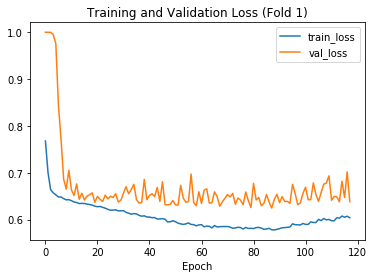

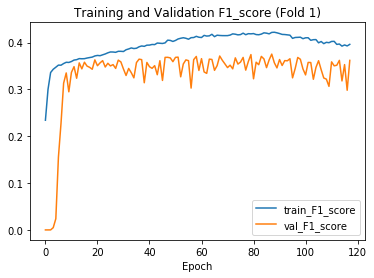

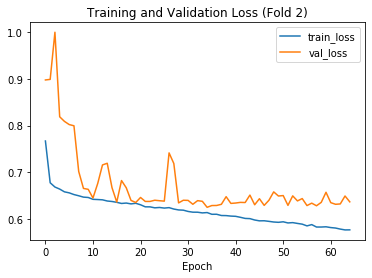

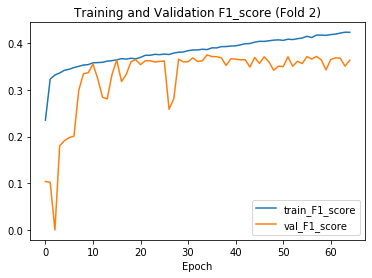

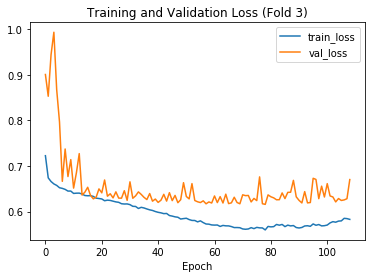

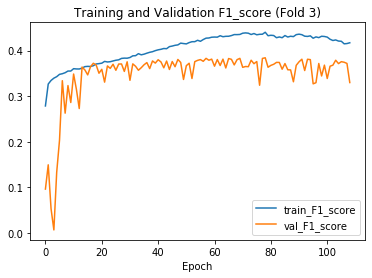

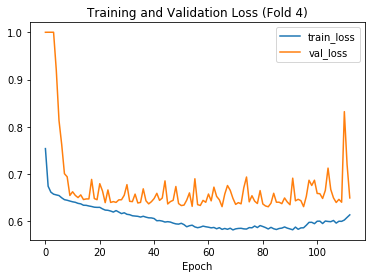

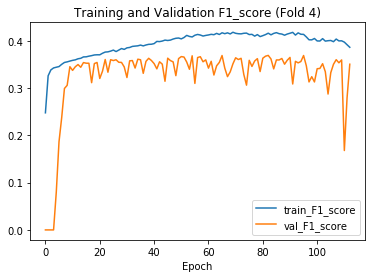

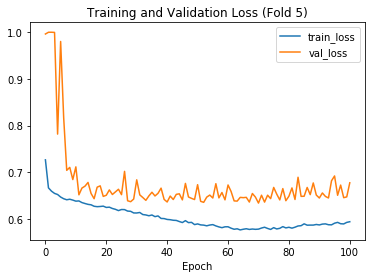

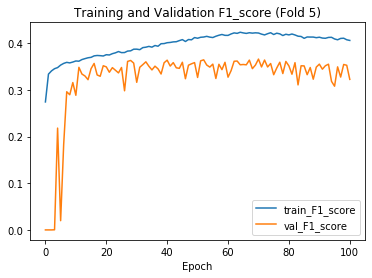

In [13]:

for fold in range(num_folds):

    train_loss = history_list[fold]['loss']
    val_loss = history_list[fold]['val_loss']
    train_F1_score = history_list[fold]['F1_score']
    val_F1_score = history_list[fold]['val_F1_score']
    plt.figure()
    plt.plot(train_loss, label='train_loss')
    plt.plot(val_loss, label='val_loss')
    plt.title('Training and Validation Loss (Fold {})'.format(fold+1))
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(train_F1_score, label='train_F1_score')
    plt.plot(val_F1_score, label='val_F1_score')
    plt.title('Training and Validation F1_score (Fold {})'.format(fold+1))
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()


In [15]:
# Make predictions with the best fold before overfitting and save images.
folder_path_train = '/home/in18657@ad.umbc.edu/Laye_Detection/Prediction/train_clahe_otsu_aaai_aug_inception'
folder_path_test = '/home/in18657@ad.umbc.edu/Laye_Detection/Prediction/test_clahe_otsu_aaai_aug_inception'
import numpy as np
import cv2
import os
model = unet_plus_inception(IMAGE_DIMS)
model.load_weights('best_model_layer_300_inception_clahe_otsu_aaai_aug_fold_3.h5')

def save_test_prediction(predictions):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(predictions)):
        pred = (predictions[i] * 255).astype(np.uint8)
        file_name = "Predicted_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), pred)

predictions = model.predict(X_test, batch_size=1)
save_test_prediction(predictions)

def save_original_mask_test(y_test):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(y_test)):
        y_test_i = (y_test[i, :, :, 0] * 255).astype(np.uint8)
        file_name = "Mask_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), y_test_i)

save_original_mask_test(y_test)


def save_original_X_test(X_test):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(X_test)):
        X_test_i = (X_test[i] * 255).astype(np.uint8)
        file_name = "Image_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), X_test_i)

save_original_X_test(X_test)
def save_train_prediction(predictions):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(predictions)):
        pred = (predictions[i] * 255).astype(np.uint8)
        file_name = "Predicted_train_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), pred)

predictions_train = model.predict(image, batch_size=1)
save_train_prediction(predictions_train)


def save_original_mask_train(y_train):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(y_train)):
        mask_i = (y_train[i, :, :, 0] * 255).astype(np.uint8)
        file_name = "Train_mask_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), mask_i)

save_original_mask_train(mask)


def save_original_X_train(X_train):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(X_train)):
        image_i = (X_train[i] * 255).astype(np.uint8)
        file_name = "Train_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), image_i)

save_original_X_train(image)

720/720 [==============================] - 23s 32ms/step


In [9]:
# train the model with size (1024,1408,1)
input_dir = "/home/in18657@ad.umbc.edu/Laye_Detection/raw"   
target_dir = "/home/in18657@ad.umbc.edu/Laye_Detection/gt_clahe_otsu_thresh_binary"
image_IMAGE_DIMS=(1024,1408,1)
mask_IMAGE_DIMS=(1024,1408,1) 
input_img_paths,target_img_paths=read_files(input_dir,target_dir)
images,masks=create_image_mask_new(input_img_paths,target_img_paths,mask_IMAGE_DIMS,image_IMAGE_DIMS)
from sklearn.model_selection import train_test_split
image, X_test, mask, y_test= train_test_split(images, masks, test_size=0.2, random_state=0)

Number of samples: 300
Number of samples: 300
/home/in18657@ad.umbc.edu/Laye_Detection/raw/Data_20110329_01_010.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt_clahe_otsu_thresh_binary/Data_20110329_01_010.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw/Data_20110329_01_011.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt_clahe_otsu_thresh_binary/Data_20110329_01_011.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw/Data_20110329_01_012.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt_clahe_otsu_thresh_binary/Data_20110329_01_012.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw/Data_20110329_01_013.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt_clahe_otsu_thresh_binary/Data_20110329_01_013.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw/Data_20110329_01_018.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt_clahe_otsu_thresh_binary/Data_20110329_01_018.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw/Data_20110329_01_019.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt_clahe_ot

In [11]:
# U-Net
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))
num_folds = 5
history_list = []

kf = KFold(n_splits=num_folds, shuffle=False, random_state=None)
indices = np.arange(len(image))
indices = shuffle(indices, random_state=0)
images_shuffled = image
masks_shuffled = mask


# Train and evaluate the model with k-fold cross-validation
train_loss_scores = []
train_binary_iou_scores = []
train_dice_coef_scores = []
train_f1_scores = []

val_loss_scores = []
val_binary_iou_scores = []
val_dice_coef_scores = []
val_f1_scores = []

test_f1_scores = []
test_loss_scores = []
test_binary_iou_scores = []
test_dice_coef_scores = []
test_f1_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(images_shuffled)):
    print(f'Fold {fold}')
    # Split the data into train and validation sets for this fold
    train_images, val_images = images_shuffled[train_index], images_shuffled[val_index]
    train_masks, val_masks = masks_shuffled[train_index], masks_shuffled[val_index]
    
    IMAGE_DIMS = (1024,1408,1)
    
   
    import tensorflow as tf
    gpus = tf.config.experimental.list_physical_devices("GPU")
    tf.config.experimental.set_visible_devices(gpus[:4], "GPU")
    
    strategy = tf.distribute.MirroredStrategy(devices=["GPU:0", "GPU:1","GPU:2", "GPU:3"])
    with strategy.scope():
    
        model = Unet(IMAGE_DIMS, n_filters=16,  dropout=0.5, batchnorm=True, regularization=None, kernel_initializer="he_normal")

        binary_iou =tf.keras.metrics.BinaryIoU(name='binary_iou', threshold=0.5)
        # Compile the model
        model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=F1_score_Loss,
        metrics=[binary_iou,dice_coef,F1_score])
    
    
    # Define the EarlyStopping and ModelCheckpoint callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=40, verbose=1,  restore_best_weights=True)

    checkpoint = ModelCheckpoint(f'best_model_layer_300_otsu_fold_{fold}.h5', monitor='val_F1_score',mode='max', save_best_only=True, verbose=1)


    history = model.fit(train_images, train_masks, epochs=300, batch_size=8,
                        validation_data=(val_images, val_masks),
                        callbacks=[early_stop, checkpoint],verbose=0)


    save_model(model, f'complete_model_layer_300_otsu_fold_{fold}.h5')
    history_list.append(history.history)
   
    model.load_weights(f'best_model_layer_300_otsu_fold_{fold}.h5')
    # Evaluate the performance of the best model on the train, validation, and test sets
    train_scores = model.evaluate(train_images, train_masks, batch_size=8)
    val_scores = model.evaluate(val_images, val_masks, batch_size=8)
    test_scores=model.evaluate(X_test,y_test, batch_size=8)


    # Print the performance of the best model on this fold's train, validation, and test sets
    train_loss_scores.append(train_scores[0])
    train_binary_iou_scores.append(train_scores[1])
    train_dice_coef_scores.append(train_scores[2])
    train_f1_scores.append(train_scores[3])

    val_loss_scores.append(val_scores[0])
    val_binary_iou_scores.append(val_scores[1])
    val_dice_coef_scores.append(val_scores[2])
    val_f1_scores.append(val_scores[3])

    test_loss_scores.append(test_scores[0])
    test_binary_iou_scores.append(test_scores[1])
    test_dice_coef_scores.append(test_scores[2])
    test_f1_scores.append(test_scores[3])
    


    print('Fold', fold+1)
    print('Train loss:', train_scores[0])
    print('Train binary IOU:', train_scores[1])
    print('Train dice coef:', train_scores[2])
    print('Train F1:', train_scores[3])
    print('------------------------')
    print('Val loss:', val_scores[0])
    print('Val binary IOU:', val_scores[1])
    print('Val dice coef:', val_scores[2])
    print('Val F1:', val_scores[3])
    print('------------------------')
    print('test loss:', test_scores[0])
    print('test binary IOU:', test_scores[1])
    print('test_dice coef:', test_scores[2])
    print('test F1:', test_scores[3])
    print('------------------------')

# Calculate the average scores over all folds
avg_train_loss = np.mean(train_loss_scores)
avg_train_binary_iou = np.mean(train_binary_iou_scores)
avg_train_dice_coef = np.mean(train_dice_coef_scores)
avg_train_f1 = np.mean(train_f1_scores)
print('------------------------')
avg_val_loss = np.mean(val_loss_scores)
avg_val_binary_iou = np.mean(val_binary_iou_scores)
avg_val_dice_coef = np.mean(val_dice_coef_scores)
avg_val_f1 = np.mean(val_f1_scores)
print('------------------------')
avg_test_loss = np.mean(test_loss_scores)
avg_test_binary_iou = np.mean(test_binary_iou_scores)
avg_test_dice_coef = np.mean(test_dice_coef_scores)
avg_test_f1 = np.mean(test_f1_scores)

# Print the final average scores
print('Average train loss:', avg_train_loss)
print('Average train binary IoU:', avg_train_binary_iou)
print('Average train Dice coefficient:', avg_train_dice_coef)
print('------------------------')
print('Average train F1 score:', avg_train_f1)
print('Average validation loss:', avg_val_loss)
print('Average validation binary IoU:', avg_val_binary_iou)
print('Average validation Dice coefficient:', avg_val_dice_coef)
print('------------------------')
print('Average validation F1 score:', avg_val_f1)
print('Average test loss:', avg_test_loss)
print('Average test binary IoU:', avg_test_binary_iou)
print('Average test Dice coefficient:', avg_test_dice_coef)
print('Average test F1 score:', avg_test_f1)
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))

Current Time = 00:44:33
Fold 0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
INFO:tensorflow:batch_all_reduce: 82 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 82 all-reduces with algorithm = nccl, num_packs = 1

Epoch 1: val_F1_score improved from -inf to 0.19746, saving model to best_model_layer_300_otsu_fold_0.h5

Epoch 2: val_F1_score did not improve from 0.19746

Epoch 3: val_F1_score did not improve from 0.19746

Epoch 4: val_F1_score did not improve from 0.19746

Epoch 5: val_F1_score did not improve from 0.19746

Epoch 6: val_F1_score did not improve from 0.19746

Epoch 7: val_F1_score did not improve from 0.19746

Epoch 8: val_F1_score did not improve from 0.19746

Epoch 9: val_F1_score improved from 0.19746 to 0.22294, saving model to best_mode

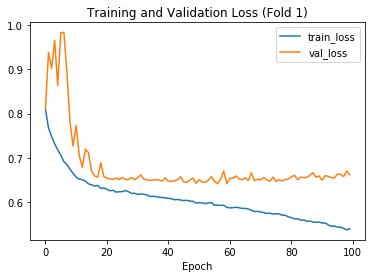

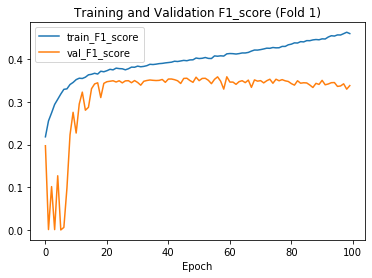

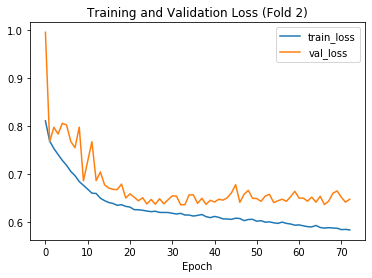

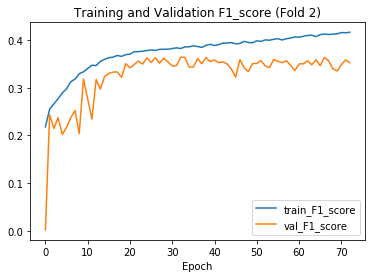

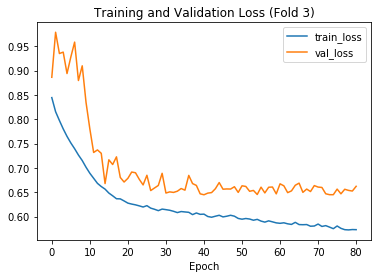

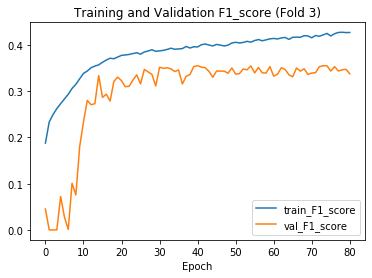

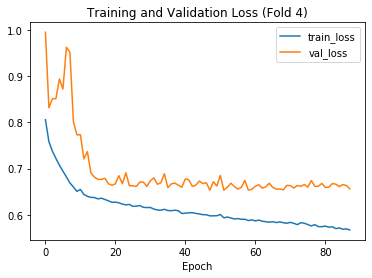

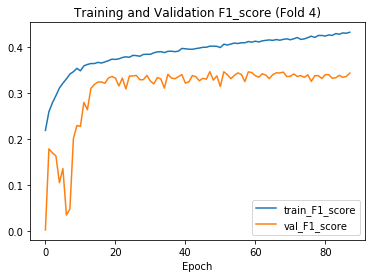

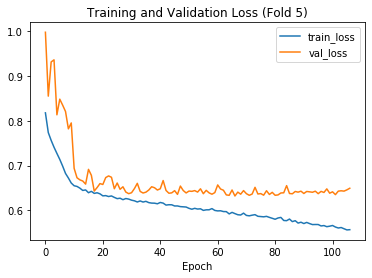

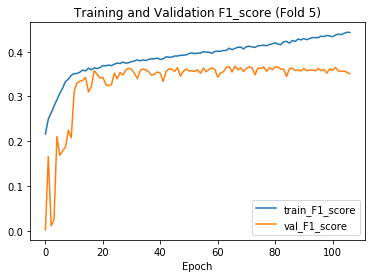

In [12]:
for fold in range(num_folds):
    train_loss = history_list[fold]['loss']
    val_loss = history_list[fold]['val_loss']
    train_F1_score = history_list[fold]['F1_score']
    val_F1_score = history_list[fold]['val_F1_score']
    plt.figure()
    plt.plot(train_loss, label='train_loss')
    plt.plot(val_loss, label='val_loss')
    plt.title('Training and Validation Loss (Fold {})'.format(fold+1))
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(train_F1_score, label='train_F1_score')
    plt.plot(val_F1_score, label='val_F1_score')
    plt.title('Training and Validation F1_score (Fold {})'.format(fold+1))
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [13]:
# Make predictions with the best fold before overfitting and save images.
folder_path_train = '/home/in18657@ad.umbc.edu/Laye_Detection/Prediction/train_otsu_clahe_UNet'
folder_path_test = '/home/in18657@ad.umbc.edu/Laye_Detection/Prediction/test_otsu_clahe_UNet'
import numpy as np
import cv2
import os
model = Unet(IMAGE_DIMS, n_filters=16, dropout=0.5, batchnorm=True, regularization=None, kernel_initializer="he_normal")
model.load_weights('best_model_layer_300_otsu_fold_1.h5')
def save_test_prediction(predictions):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(predictions)):
        pred = (predictions[i] * 255).astype(np.uint8)
        file_name = "Predicted_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), pred)

predictions = model.predict(X_test, batch_size=1)
save_test_prediction(predictions)


def save_original_mask_test(y_test):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(y_test)):
        y_test_i = (y_test[i, :, :, 0] * 255).astype(np.uint8)
        file_name = "Mask_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), y_test_i)

save_original_mask_test(y_test)


def save_original_X_test(X_test):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(X_test)):
        X_test_i = (X_test[i] * 255).astype(np.uint8)
        file_name = "Image_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), X_test_i)

save_original_X_test(X_test)
def save_train_prediction(predictions):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(predictions)):
        pred = (predictions[i] * 255).astype(np.uint8)"
        file_name = "Predicted_train_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), pred)

predictions_train = model.predict(image, batch_size=1)
save_train_prediction(predictions_train)


def save_original_mask_train(y_train):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(y_train)):
        mask_i = (y_train[i, :, :, 0] * 255).astype(np.uint8)
        file_name = "Train_mask_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), mask_i)

save_original_mask_train(mask)


def save_original_X_train(X_train):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(X_train)):
        image_i = (X_train[i] * 255).astype(np.uint8)
        file_name = "Train_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), image_i)

save_original_X_train(image)

240/240 [==============================] - 6s 25ms/step


In [17]:
# Train models with the original number of images.
input_dir = "/home/in18657@ad.umbc.edu/Laye_Detection/raw"   
target_dir = "/home/in18657@ad.umbc.edu/Laye_Detection/gt_clahe_otsu_thresh_binary"
image_IMAGE_DIMS=(512,512,3)
mask_IMAGE_DIMS=(512,512,1) 
input_img_paths,target_img_paths=read_files(input_dir,target_dir)
images,masks=create_image_mask_new(input_img_paths,target_img_paths,mask_IMAGE_DIMS,image_IMAGE_DIMS)
from sklearn.model_selection import train_test_split
image, X_test, mask, y_test= train_test_split(images, masks, test_size=0.2, random_state=0)

Number of samples: 300
Number of samples: 300
/home/in18657@ad.umbc.edu/Laye_Detection/raw/Data_20110329_01_010.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt_clahe_otsu_thresh_binary/Data_20110329_01_010.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw/Data_20110329_01_011.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt_clahe_otsu_thresh_binary/Data_20110329_01_011.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw/Data_20110329_01_012.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt_clahe_otsu_thresh_binary/Data_20110329_01_012.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw/Data_20110329_01_013.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt_clahe_otsu_thresh_binary/Data_20110329_01_013.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw/Data_20110329_01_018.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt_clahe_otsu_thresh_binary/Data_20110329_01_018.png
/home/in18657@ad.umbc.edu/Laye_Detection/raw/Data_20110329_01_019.png | /home/in18657@ad.umbc.edu/Laye_Detection/gt_clahe_ot

In [19]:
# VGG-19 +U-Net
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))
num_folds = 5
history_list = []

kf = KFold(n_splits=num_folds, shuffle=False, random_state=None)
indices = np.arange(len(image))
indices = shuffle(indices, random_state=0)
images_shuffled = image
masks_shuffled = mask


# Train and evaluate the model with k-fold cross-validation
train_loss_scores = []
train_binary_iou_scores = []
train_dice_coef_scores = []
train_f1_scores = []

val_loss_scores = []
val_binary_iou_scores = []
val_dice_coef_scores = []
val_f1_scores = []

test_f1_scores = []
test_loss_scores = []
test_binary_iou_scores = []
test_dice_coef_scores = []
test_f1_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(images_shuffled)):
    print(f'Fold {fold}')
    # Split the data into train and validation sets for this fold
    train_images, val_images = images_shuffled[train_index], images_shuffled[val_index]
    train_masks, val_masks = masks_shuffled[train_index], masks_shuffled[val_index]
    
    input_shape = (512, 512, 3)
    
   
    import tensorflow as tf
    gpus = tf.config.experimental.list_physical_devices("GPU")
    tf.config.experimental.set_visible_devices(gpus[:4], "GPU")
    
    strategy = tf.distribute.MirroredStrategy(devices=["GPU:0", "GPU:1","GPU:2", "GPU:3"])
    with strategy.scope():
    
        

        model = build_vgg19_unet(input_shape)

        binary_iou =tf.keras.metrics.BinaryIoU(name='binary_iou', threshold=0.5)
        # Compile the model
        model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=F1_score_Loss,
        metrics=[binary_iou,dice_coef,F1_score])
    
    
    # Define the EarlyStopping and ModelCheckpoint callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50, verbose=1,  restore_best_weights=True)

    checkpoint = ModelCheckpoint(f'best_model_layer_300_otsu_vgg_fold_{fold}.h5', monitor='val_F1_score',mode='max', save_best_only=True, verbose=1)


    history = model.fit(train_images, train_masks, epochs=300, batch_size=8,
                        validation_data=(val_images, val_masks),
                        callbacks=[early_stop, checkpoint],verbose=0)


    save_model(model, f'complete_model_layer_300_otsu_vgg_fold_{fold}.h5')
    history_list.append(history.history)
   
    model.load_weights(f'best_model_layer_300_otsu_vgg_fold_{fold}.h5')
    # Evaluate the performance of the best model on the train, validation, and test sets
    train_scores = model.evaluate(train_images, train_masks, batch_size=8)
    val_scores = model.evaluate(val_images, val_masks, batch_size=8)
    test_scores=model.evaluate(X_test,y_test, batch_size=8)
    # Print the performance of the best model on this fold's train, validation, and test sets
    train_loss_scores.append(train_scores[0])
    train_binary_iou_scores.append(train_scores[1])
    train_dice_coef_scores.append(train_scores[2])
    train_f1_scores.append(train_scores[3])

    val_loss_scores.append(val_scores[0])
    val_binary_iou_scores.append(val_scores[1])
    val_dice_coef_scores.append(val_scores[2])
    val_f1_scores.append(val_scores[3])

    test_loss_scores.append(test_scores[0])
    test_binary_iou_scores.append(test_scores[1])
    test_dice_coef_scores.append(test_scores[2])
    test_f1_scores.append(test_scores[3])

    print('Fold', fold+1)
    print('Train loss:', train_scores[0])
    print('Train binary IOU:', train_scores[1])
    print('Train dice coef:', train_scores[2])
    print('Train F1:', train_scores[3])
    print('------------------------')
    print('Val loss:', val_scores[0])
    print('Val binary IOU:', val_scores[1])
    print('Val dice coef:', val_scores[2])
    print('Val F1:', val_scores[3])
    print('------------------------')
    print('test loss:', test_scores[0])
    print('test binary IOU:', test_scores[1])
    print('test_dice coef:', test_scores[2])
    print('test F1:', test_scores[3])
    print('------------------------')

# Calculate the average scores over all folds
avg_train_loss = np.mean(train_loss_scores)
avg_train_binary_iou = np.mean(train_binary_iou_scores)
avg_train_dice_coef = np.mean(train_dice_coef_scores)
avg_train_f1 = np.mean(train_f1_scores)
print('------------------------')
avg_val_loss = np.mean(val_loss_scores)
avg_val_binary_iou = np.mean(val_binary_iou_scores)
avg_val_dice_coef = np.mean(val_dice_coef_scores)
avg_val_f1 = np.mean(val_f1_scores)
print('------------------------')
avg_test_loss = np.mean(test_loss_scores)
avg_test_binary_iou = np.mean(test_binary_iou_scores)
avg_test_dice_coef = np.mean(test_dice_coef_scores)
avg_test_f1 = np.mean(test_f1_scores)

# Print the final average scores
print('Average train loss:', avg_train_loss)
print('Average train binary IoU:', avg_train_binary_iou)
print('Average train Dice coefficient:', avg_train_dice_coef)
print('------------------------')
print('Average train F1 score:', avg_train_f1)
print('Average validation loss:', avg_val_loss)
print('Average validation binary IoU:', avg_val_binary_iou)
print('Average validation Dice coefficient:', avg_val_dice_coef)
print('------------------------')
print('Average validation F1 score:', avg_val_f1)
print('Average test loss:', avg_test_loss)
print('Average test binary IoU:', avg_test_binary_iou)
print('Average test Dice coefficient:', avg_test_dice_coef)
print('Average test F1 score:', avg_test_f1)
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))

Current Time = 02:32:48
Fold 0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')

Epoch 1: val_F1_score improved from -inf to 0.03152, saving model to best_model_layer_300_otsu_vgg_fold_0.h5

Epoch 2: val_F1_score improved from 0.03152 to 0.28953, saving model to best_model_layer_300_otsu_vgg_fold_0.h5

Epoch 3: val_F1_score did not improve from 0.28953

Epoch 4: val_F1_score did not improve from 0.28953

Epoch 5: val_F1_score did not improve from 0.28953

Epoch 6: val_F1_score did not improve from 0.28953

Epoch 7: val_F1_score improved from 0.28953 to 0.29897, saving model to best_model_layer_300_otsu_vgg_fold_0.h5

Epoch 8: val_F1_score improved from 0.29897 to 0.30665, saving model to best_model_layer_300_otsu_vgg_fold_0.h5

Epoch 9: val_F1_score did not improve from 0.30665

Epoch 10: val_

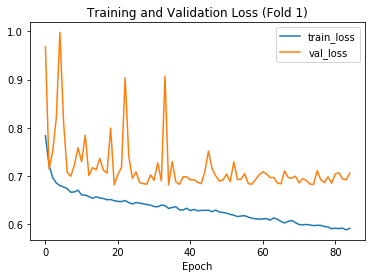

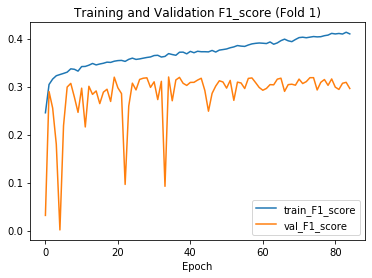

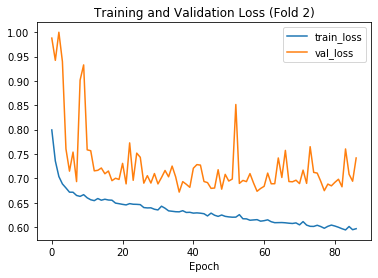

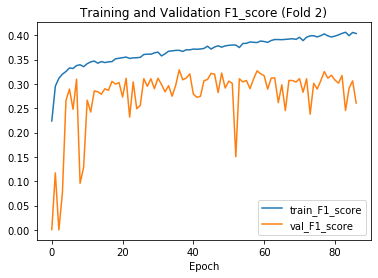

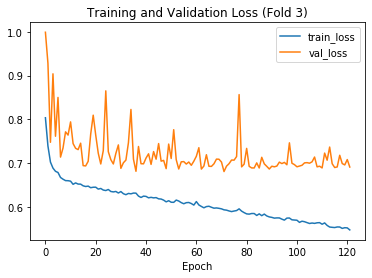

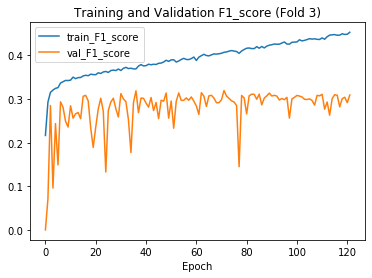

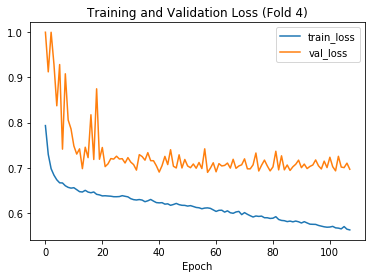

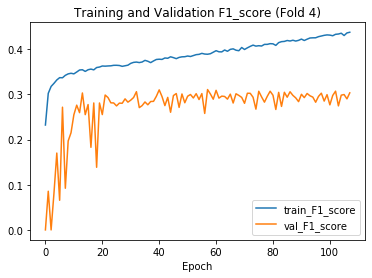

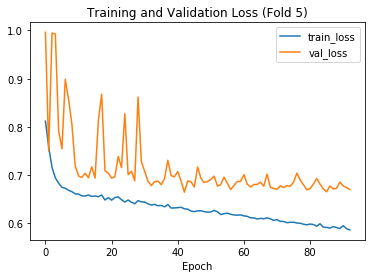

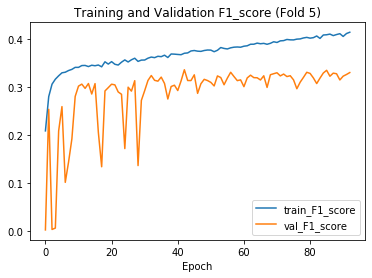

In [20]:
for fold in range(num_folds):
    train_loss = history_list[fold]['loss']
    val_loss = history_list[fold]['val_loss']
    train_F1_score = history_list[fold]['F1_score']
    val_F1_score = history_list[fold]['val_F1_score']
    plt.figure()
    plt.plot(train_loss, label='train_loss')
    plt.plot(val_loss, label='val_loss')
    plt.title('Training and Validation Loss (Fold {})'.format(fold+1))
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(train_F1_score, label='train_F1_score')
    plt.plot(val_F1_score, label='val_F1_score')
    plt.title('Training and Validation F1_score (Fold {})'.format(fold+1))
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [24]:
# Make predictions with the best fold before overfitting and save images.
folder_path_train = '/home/in18657@ad.umbc.edu/Laye_Detection/Prediction/train_clahe_OTSU_vgg'
folder_path_test = '/home/in18657@ad.umbc.edu/Laye_Detection/Prediction/test_clahe_OTSU_vgg'
import numpy as np
import cv2
import os
input_shape = (512, 512, 3)
model = build_vgg19_unet(input_shape)
model.load_weights('best_model_layer_300_otsu_vgg_fold_1.h5')

def save_test_prediction(predictions):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(predictions)):
        pred = (predictions[i] * 255).astype(np.uint8)
        #save_path = folder_path_test + "/"
        file_name = "Predicted_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), pred)

predictions = model.predict(X_test, batch_size=1)
save_test_prediction(predictions)


def save_original_mask_test(y_test):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(y_test)):
        y_test_i = (y_test[i, :, :, 0] * 255).astype(np.uint8)
        file_name = "Mask_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), y_test_i)

save_original_mask_test(y_test)


def save_original_X_test(X_test):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(X_test)):
        X_test_i = (X_test[i] * 255).astype(np.uint8)
        file_name = "Image_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), X_test_i)

save_original_X_test(X_test)
def save_train_prediction(predictions):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(predictions)):
        pred = (predictions[i] * 255).astype(np.uint8)
        file_name = "Predicted_train_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), pred)

predictions_train = model.predict(image, batch_size=1)
save_train_prediction(predictions_train)


def save_original_mask_train(y_train):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(y_train)):
        mask_i = (y_train[i, :, :, 0] * 255).astype(np.uint8)
        file_name = "Train_mask_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), mask_i)

save_original_mask_train(mask)


def save_original_X_train(X_train):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(X_train)):
        image_i = (X_train[i] * 255).astype(np.uint8)
        file_name = "Train_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), image_i)

save_original_X_train(image)

240/240 [==============================] - 6s 23ms/step


In [30]:
# Inception U-Net
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))
num_folds = 5
history_list = []

kf = KFold(n_splits=num_folds, shuffle=False, random_state=None)


indices = np.arange(len(image))
indices = shuffle(indices, random_state=0)
images_shuffled = image
masks_shuffled = mask
# Train and evaluate the model with k-fold cross-validation
train_loss_scores = []
train_binary_iou_scores = []
train_dice_coef_scores = []
train_f1_scores = []

val_loss_scores = []
val_binary_iou_scores = []
val_dice_coef_scores = []
val_f1_scores = []

test_f1_scores = []
test_loss_scores = []
test_binary_iou_scores = []
test_dice_coef_scores = []
test_f1_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(images_shuffled)):
    print(f'Fold {fold}')
    # Split the data into train and validation sets for this fold
    train_images, val_images = images_shuffled[train_index], images_shuffled[val_index]
    train_masks, val_masks = masks_shuffled[train_index], masks_shuffled[val_index]
    
    IMAGE_DIMS = (512,512,3)
    import tensorflow as tf
    gpus = tf.config.experimental.list_physical_devices("GPU")
    tf.config.experimental.set_visible_devices(gpus[:4], "GPU")
    
    strategy = tf.distribute.MirroredStrategy(devices=["GPU:0", "GPU:1","GPU:2", "GPU:3"])
    with strategy.scope():

        model = unet_plus_inception(IMAGE_DIMS)

        binary_iou =tf.keras.metrics.BinaryIoU(name='binary_iou', threshold=0.5)
        # Compile the model
        model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=F1_score_Loss,
        metrics=[binary_iou,dice_coef,F1_score])
    
    
    # Define the EarlyStopping and ModelCheckpoint callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=40, verbose=1,  restore_best_weights=True)

    checkpoint = ModelCheckpoint(f'best_model_layer_300_otsu_inception_fold_{fold}.h5', monitor='val_F1_score',mode='max', save_best_only=True, verbose=1)


    history = model.fit(train_images, train_masks, epochs=300, batch_size=8,
                        validation_data=(val_images, val_masks),
                        callbacks=[early_stop, checkpoint],verbose=0)


    save_model(model, f'complete_model_layer_300_otsu_inception_fold_{fold}.h5')
    history_list.append(history.history)
   
    model.load_weights(f'best_model_layer_300_otsu_inception_fold_{fold}.h5')
    # Evaluate the performance of the best model on the train, validation, and test sets
    train_scores = model.evaluate(train_images, train_masks, batch_size=8)
    val_scores = model.evaluate(val_images, val_masks, batch_size=8)
    test_scores=model.evaluate(X_test,y_test, batch_size=8)



    # Print the performance of the best model on this fold's train, validation, and test sets
    train_loss_scores.append(train_scores[0])
    train_binary_iou_scores.append(train_scores[1])
    train_dice_coef_scores.append(train_scores[2])
    train_f1_scores.append(train_scores[3])

    val_loss_scores.append(val_scores[0])
    val_binary_iou_scores.append(val_scores[1])
    val_dice_coef_scores.append(val_scores[2])
    val_f1_scores.append(val_scores[3])

    test_loss_scores.append(test_scores[0])
    test_binary_iou_scores.append(test_scores[1])
    test_dice_coef_scores.append(test_scores[2])
    test_f1_scores.append(test_scores[3])
    


    print('Fold', fold+1)
    print('Train loss:', train_scores[0])
    print('Train binary IOU:', train_scores[1])
    print('Train dice coef:', train_scores[2])
    print('Train F1:', train_scores[3])
    print('------------------------')
    print('Val loss:', val_scores[0])
    print('Val binary IOU:', val_scores[1])
    print('Val dice coef:', val_scores[2])
    print('Val F1:', val_scores[3])
    print('------------------------')
    print('test loss:', test_scores[0])
    print('test binary IOU:', test_scores[1])
    print('test_dice coef:', test_scores[2])
    print('test F1:', test_scores[3])
    print('------------------------')

# Calculate the average scores over all folds
avg_train_loss = np.mean(train_loss_scores)
avg_train_binary_iou = np.mean(train_binary_iou_scores)
avg_train_dice_coef = np.mean(train_dice_coef_scores)
avg_train_f1 = np.mean(train_f1_scores)
print('------------------------')
avg_val_loss = np.mean(val_loss_scores)
avg_val_binary_iou = np.mean(val_binary_iou_scores)
avg_val_dice_coef = np.mean(val_dice_coef_scores)
avg_val_f1 = np.mean(val_f1_scores)
print('------------------------')
avg_test_loss = np.mean(test_loss_scores)
avg_test_binary_iou = np.mean(test_binary_iou_scores)
avg_test_dice_coef = np.mean(test_dice_coef_scores)
avg_test_f1 = np.mean(test_f1_scores)

# Print the final average scores
print('Average train loss:', avg_train_loss)
print('Average train binary IoU:', avg_train_binary_iou)
print('Average train Dice coefficient:', avg_train_dice_coef)
print('------------------------')
print('Average train F1 score:', avg_train_f1)
print('Average validation loss:', avg_val_loss)
print('Average validation binary IoU:', avg_val_binary_iou)
print('Average validation Dice coefficient:', avg_val_dice_coef)
print('------------------------')
print('Average validation F1 score:', avg_val_f1)
print('Average test loss:', avg_test_loss)
print('Average test binary IoU:', avg_test_binary_iou)
print('Average test Dice coefficient:', avg_test_dice_coef)
print('Average test F1 score:', avg_test_f1)
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))

Current Time = 20:05:11
Fold 0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')

Epoch 1: val_F1_score improved from -inf to 0.13318, saving model to best_model_layer_300_otsu_inception_fold_0.h5

Epoch 2: val_F1_score improved from 0.13318 to 0.13494, saving model to best_model_layer_300_otsu_inception_fold_0.h5

Epoch 3: val_F1_score did not improve from 0.13494

Epoch 4: val_F1_score did not improve from 0.13494

Epoch 5: val_F1_score did not improve from 0.13494

Epoch 6: val_F1_score did not improve from 0.13494

Epoch 7: val_F1_score did not improve from 0.13494

Epoch 8: val_F1_score did not improve from 0.13494

Epoch 9: val_F1_score did not improve from 0.13494

Epoch 10: val_F1_score did not improve from 0.13494

Epoch 11: val_F1_score did not improve from 0.13494

Epoch 12: val_F1_s

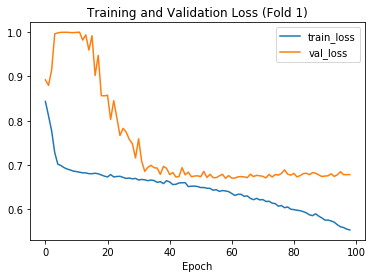

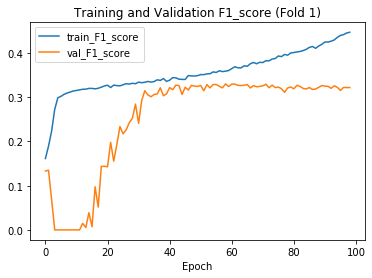

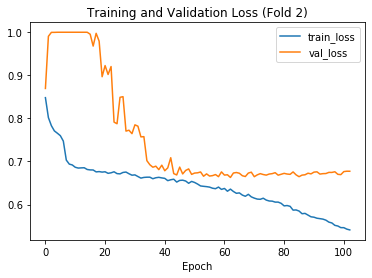

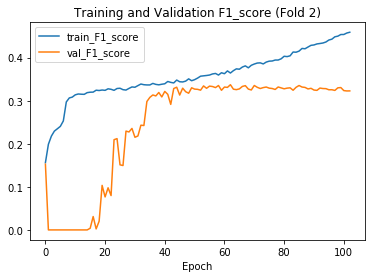

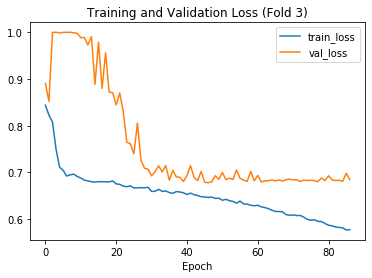

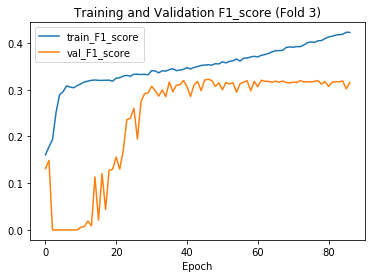

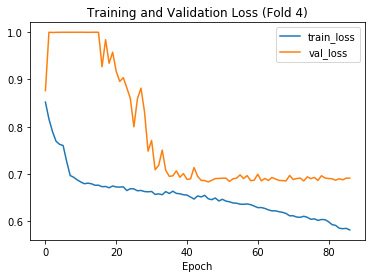

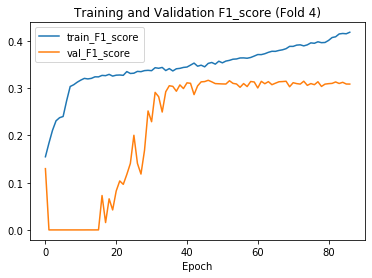

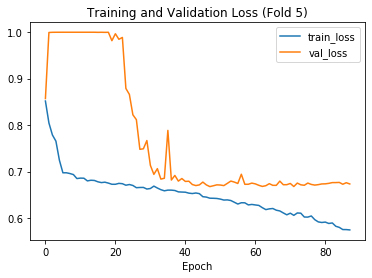

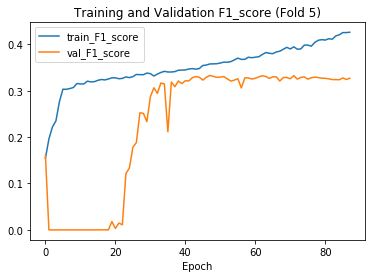

In [31]:
for fold in range(num_folds):
    train_loss = history_list[fold]['loss']
    val_loss = history_list[fold]['val_loss']
    train_F1_score = history_list[fold]['F1_score']
    val_F1_score = history_list[fold]['val_F1_score']

    plt.figure()
    plt.plot(train_loss, label='train_loss')
    plt.plot(val_loss, label='val_loss')
    plt.title('Training and Validation Loss (Fold {})'.format(fold+1))
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(train_F1_score, label='train_F1_score')
    plt.plot(val_F1_score, label='val_F1_score')
    plt.title('Training and Validation F1_score (Fold {})'.format(fold+1))
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()


In [35]:
# Make predictions with the best fold before overfitting and save images.

folder_path_train = '/home/in18657@ad.umbc.edu/Laye_Detection/train_clahe_otsu_inception'
folder_path_test = '/home/in18657@ad.umbc.edu/Laye_Detection/test_clahe_otsu_inception'
import numpy as np
import cv2
import os
model = unet_plus_inception(IMAGE_DIMS)
model.load_weights('best_model_layer_300_otsu_inception_fold_1.h5')

def save_test_prediction(predictions):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(predictions)):
        pred = (predictions[i] * 255).astype(np.uint8)"
        file_name = "Predicted_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), pred)

predictions = model.predict(X_test, batch_size=1)
save_test_prediction(predictions)


def save_original_mask_test(y_test):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(y_test)):
        y_test_i = (y_test[i, :, :, 0] * 255).astype(np.uint8)
        file_name = "Mask_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), y_test_i)

save_original_mask_test(y_test)


def save_original_X_test(X_test):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(X_test)):
        X_test_i = (X_test[i] * 255).astype(np.uint8)

        file_name = "Image_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), X_test_i)

save_original_X_test(X_test)
def save_train_prediction(predictions):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(predictions)):
        pred = (predictions[i] * 255).astype(np.uint8)
        file_name = "Predicted_train_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), pred)

predictions_train = model.predict(image, batch_size=1)
save_train_prediction(predictions_train)


def save_original_mask_train(y_train):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(y_train)):
        mask_i = (y_train[i, :, :, 0] * 255).astype(np.uint8)

        file_name = "Train_mask_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), mask_i)

save_original_mask_train(mask)


def save_original_X_train(X_train):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(X_train)):
        image_i = (X_train[i] * 255).astype(np.uint8)
        file_name = "Train_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), image_i)

save_original_X_train(image)

240/240 [==============================] - 8s 32ms/step


In [21]:
# U-Net
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))
num_folds = 5
history_list = []

kf = KFold(n_splits=num_folds, shuffle=False, random_state=None)


indices = np.arange(len(image))
indices = shuffle(indices, random_state=0)
images_shuffled = image
masks_shuffled = mask


# Train and evaluate the model with k-fold cross-validation
train_loss_scores = []
train_binary_iou_scores = []
train_dice_coef_scores = []
train_f1_scores = []

val_loss_scores = []
val_binary_iou_scores = []
val_dice_coef_scores = []
val_f1_scores = []

test_f1_scores = []
test_loss_scores = []
test_binary_iou_scores = []
test_dice_coef_scores = []
test_f1_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(images_shuffled)):
    print(f'Fold {fold}')
    # Split the data into train and validation sets for this fold
    train_images, val_images = images_shuffled[train_index], images_shuffled[val_index]
    train_masks, val_masks = masks_shuffled[train_index], masks_shuffled[val_index]
    
    IMAGE_DIMS = (1024,1408,1)
    
   
    import tensorflow as tf
    gpus = tf.config.experimental.list_physical_devices("GPU")
    tf.config.experimental.set_visible_devices(gpus[:4], "GPU")
    
    strategy = tf.distribute.MirroredStrategy(devices=["GPU:0", "GPU:1","GPU:2", "GPU:3"])
    with strategy.scope():
    
        

        model = Unet(IMAGE_DIMS, n_filters=16,  dropout=0.5, batchnorm=True, regularization=None, kernel_initializer="he_normal")

        binary_iou =tf.keras.metrics.BinaryIoU(name='binary_iou', threshold=0.5)
        # Compile the model
        model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=F1_score_Loss,
        metrics=[binary_iou,dice_coef,F1_score])
    
    
    # Define the EarlyStopping and ModelCheckpoint callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1,  restore_best_weights=True)

    checkpoint = ModelCheckpoint(f'best_model_layer_300_new_fold_{fold}.h5', monitor='val_F1_score',mode='max', save_best_only=True, verbose=1)


    history = model.fit(train_images, train_masks, epochs=300, batch_size=8,
                        validation_data=(val_images, val_masks),
                        callbacks=[early_stop, checkpoint],verbose=0)


    save_model(model, f'complete_model_layer_300_new_fold_{fold}.h5')
    history_list.append(history.history)
   
    model.load_weights(f'best_model_layer_300_new_fold_{fold}.h5')
    # Evaluate the performance of the best model on the train, validation, and test sets
    train_scores = model.evaluate(train_images, train_masks, batch_size=8)
    val_scores = model.evaluate(val_images, val_masks, batch_size=8)
    test_scores=model.evaluate(X_test,y_test, batch_size=8)

    model.evaluate(train_images, train_masks, batch_size=8)
    model.evaluate(val_images, val_masks, batch_size=8)
    model.evaluate(X_test,y_test, batch_size=8)

    # Print the performance of the best model on this fold's train, validation, and test sets
    train_loss_scores.append(train_scores[0])
    train_binary_iou_scores.append(train_scores[1])
    train_dice_coef_scores.append(train_scores[2])
    train_f1_scores.append(train_scores[3])

    val_loss_scores.append(val_scores[0])
    val_binary_iou_scores.append(val_scores[1])
    val_dice_coef_scores.append(val_scores[2])
    val_f1_scores.append(val_scores[3])

    test_loss_scores.append(test_scores[0])
    test_binary_iou_scores.append(test_scores[1])
    test_dice_coef_scores.append(test_scores[2])
    test_f1_scores.append(test_scores[3])
    


    print('Fold', fold+1)
    print('Train loss:', train_scores[0])
    print('Train binary IOU:', train_scores[1])
    print('Train dice coef:', train_scores[2])
    print('Train F1:', train_scores[3])
    print('------------------------')
    print('Val loss:', val_scores[0])
    print('Val binary IOU:', val_scores[1])
    print('Val dice coef:', val_scores[2])
    print('Val F1:', val_scores[3])
    print('------------------------')
    print('test loss:', test_scores[0])
    print('test binary IOU:', test_scores[1])
    print('test_dice coef:', test_scores[2])
    print('test F1:', test_scores[3])
    print('------------------------')

# Calculate the average scores over all folds
avg_train_loss = np.mean(train_loss_scores)
avg_train_binary_iou = np.mean(train_binary_iou_scores)
avg_train_dice_coef = np.mean(train_dice_coef_scores)
avg_train_f1 = np.mean(train_f1_scores)
print('------------------------')
avg_val_loss = np.mean(val_loss_scores)
avg_val_binary_iou = np.mean(val_binary_iou_scores)
avg_val_dice_coef = np.mean(val_dice_coef_scores)
avg_val_f1 = np.mean(val_f1_scores)
print('------------------------')
avg_test_loss = np.mean(test_loss_scores)
avg_test_binary_iou = np.mean(test_binary_iou_scores)
avg_test_dice_coef = np.mean(test_dice_coef_scores)
avg_test_f1 = np.mean(test_f1_scores)

# Print the final average scores
print('Average train loss:', avg_train_loss)
print('Average train binary IoU:', avg_train_binary_iou)
print('Average train Dice coefficient:', avg_train_dice_coef)
print('------------------------')
print('Average train F1 score:', avg_train_f1)
print('Average validation loss:', avg_val_loss)
print('Average validation binary IoU:', avg_val_binary_iou)
print('Average validation Dice coefficient:', avg_val_dice_coef)
print('------------------------')
print('Average validation F1 score:', avg_val_f1)
print('Average test loss:', avg_test_loss)
print('Average test binary IoU:', avg_test_binary_iou)
print('Average test Dice coefficient:', avg_test_dice_coef)
print('Average test F1 score:', avg_test_f1)
print("Current Time =", datetime.datetime.now().strftime("%H:%M:%S"))

Current Time = 00:56:34
Fold 0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce t

In [22]:
# Make predictions with the best fold before overfitting and save images.
folder_path_train = '/home/in18657@ad.umbc.edu/ice_layer_augest/Prediction/train_Unet_clahe_otsu'
folder_path_test = '/home/in18657@ad.umbc.edu/ice_layer_augest/Prediction/test_Unet_clahe_otsu'
import numpy as np
import cv2
import os
model = Unet(IMAGE_DIMS, n_filters=16, dropout=0.5, batchnorm=True, regularization=None, kernel_initializer="he_normal")
model.load_weights('best_model_layer_300_new_fold_1.h5')


def save_test_prediction(predictions):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(predictions)):
        pred = (predictions[i] * 255).astype(np.uint8)
        file_name = "Predicted_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), pred)

predictions = model.predict(X_test, batch_size=1)
save_test_prediction(predictions)


def save_original_mask_test(y_test):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(y_test)):
        y_test_i = (y_test[i, :, :, 0] * 255).astype(np.uint8)
        file_name = "Mask_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), y_test_i)

save_original_mask_test(y_test)


def save_original_X_test(X_test):
    os.makedirs(folder_path_test, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(X_test)):
        X_test_i = (X_test[i] * 255).astype(np.uint8)
        file_name = "Image_test_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_test, file_name), X_test_i)

save_original_X_test(X_test)
def save_train_prediction(predictions):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(predictions)):
        pred = (predictions[i] * 255).astype(np.uint8)
        file_name = "Predicted_train_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), pred)

predictions_train = model.predict(image, batch_size=1)
save_train_prediction(predictions_train)


def save_original_mask_train(y_train):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(y_train)):
        mask_i = (y_train[i, :, :, 0] * 255).astype(np.uint8)
        file_name = "Train_mask_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), mask_i)

save_original_mask_train(mask)


def save_original_X_train(X_train):
    os.makedirs(folder_path_train, exist_ok=True)  # Create the directory if it doesn't exist
    for i in range(len(X_train)):
        image_i = (X_train[i] * 255).astype(np.uint8)
        file_name = "Train_img_{}.png".format(i)
        cv2.imwrite(os.path.join(folder_path_train, file_name), image_i)

save_original_X_train(image)

240/240 [==============================] - 5s 20ms/step


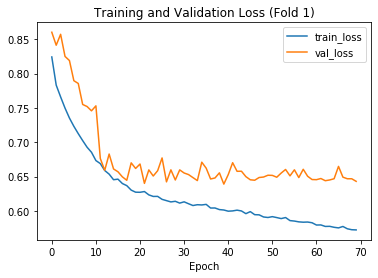

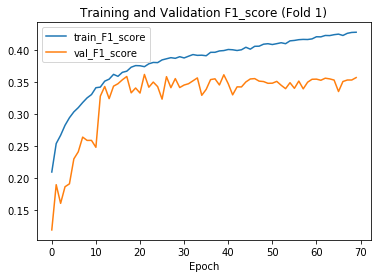

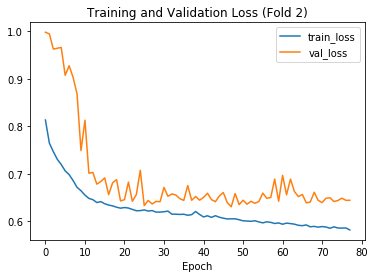

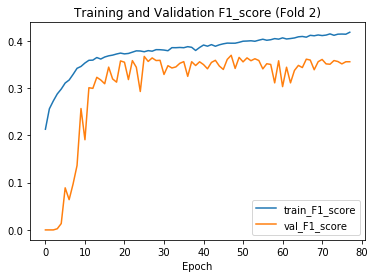

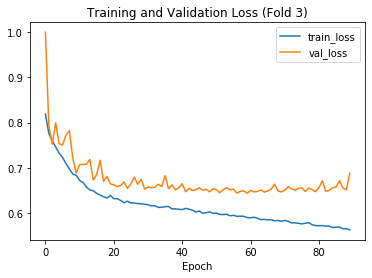

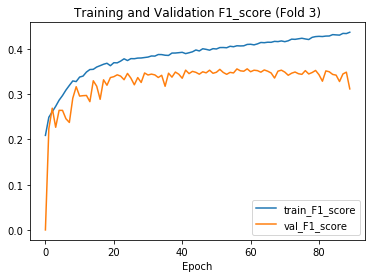

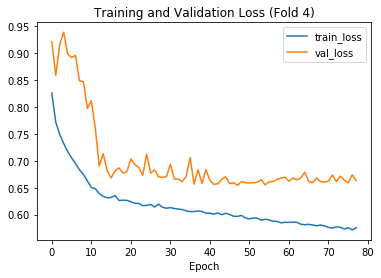

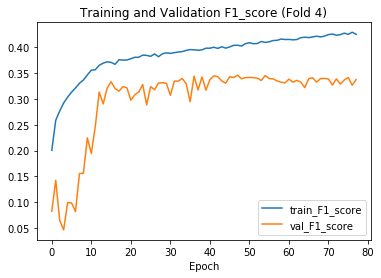

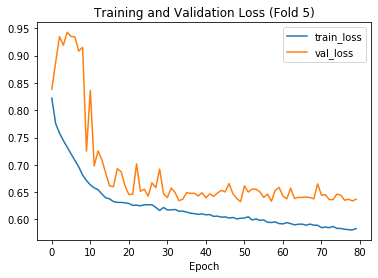

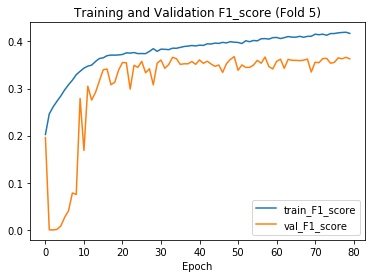

In [23]:
for fold in range(num_folds):
    train_loss = history_list[fold]['loss']
    val_loss = history_list[fold]['val_loss']
    train_F1_score = history_list[fold]['F1_score']
    val_F1_score = history_list[fold]['val_F1_score']

    plt.figure()
    plt.plot(train_loss, label='train_loss')
    plt.plot(val_loss, label='val_loss')
    plt.title('Training and Validation Loss (Fold {})'.format(fold+1))
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(train_F1_score, label='train_F1_score')
    plt.plot(val_F1_score, label='val_F1_score')
    plt.title('Training and Validation F1_score (Fold {})'.format(fold+1))
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()